In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import model
import time
from datetime import datetime
from datetime import timedelta
sns.set()

%matplotlib notebook

In [2]:
df = pd.read_csv('../dataset/predict-set-20190527-0531.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Timestamp,Close,High,Low,Open,Volume
0,1558915200,8653.011422,8660.000000,8607.303062,8616.502752,20803.498272
1,1558915500,8689.545605,8729.091604,8653.815050,8653.815050,122780.290759
2,1558915800,8682.085232,8698.578593,8658.146320,8682.595359,48788.811247
3,1558916100,8733.177325,8733.177325,8700.000000,8700.000000,36294.412783
4,1558916400,8811.826574,8815.225937,8734.000000,8734.000000,164608.486049


In [3]:
print(df.iloc[:, 3].values)

[8607.30306214 8653.81505023 8658.14631965 ... 8276.7639935  8289.24261714
 8285.95789154]


In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 4].values.reshape((-1,1)))
close_normalize = minmax.transform(df.iloc[:, 4].values.reshape((-1,1))).reshape((-1))

In [5]:
close_normalize.shape

(1300,)

In [6]:
class encoder:
    def __init__(self, input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20):
        input_size = input_.shape[1]
        self.X = tf.placeholder("float", [None, input_.shape[1]])
    
        weights = {
        'encoder_h1': tf.Variable(tf.random_normal([input_size, hidden_layer])),
        'encoder_h2': tf.Variable(tf.random_normal([hidden_layer, dimension])),
        'decoder_h1': tf.Variable(tf.random_normal([dimension, hidden_layer])),
        'decoder_h2': tf.Variable(tf.random_normal([hidden_layer, input_size])),
        }
    
        biases = {
        'encoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'encoder_b2': tf.Variable(tf.random_normal([dimension])),
        'decoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'decoder_b2': tf.Variable(tf.random_normal([input_size])),
        }
    
        first_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(self.X, weights['encoder_h1']), biases['encoder_b1']))
        self.second_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder_h2']), biases['encoder_b2']))
        first_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(self.second_layer_encoder, weights['decoder_h1']), biases['decoder_b1']))
        second_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder_h2']), biases['decoder_b2']))
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
        for i in range(epoch):
            last_time = time.time()
            _, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            if (i + 1) % 10 == 0:
                print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
    
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})

In [7]:
tf.reset_default_graph()
Encoder=encoder(close_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalize.reshape((-1,1)))
thought_vector.shape

Instructions for updating:
Colocations handled automatically by placer.
epoch: 10 loss: 0.25508356 time: 0.002386331558227539
epoch: 20 loss: 0.032823842 time: 0.002199888229370117
epoch: 30 loss: 0.015350427 time: 0.0033872127532958984
epoch: 40 loss: 0.011692491 time: 0.0024802684783935547
epoch: 50 loss: 0.007910037 time: 0.0022809505462646484
epoch: 60 loss: 0.004685413 time: 0.002288818359375
epoch: 70 loss: 0.002752675 time: 0.003807544708251953
epoch: 80 loss: 0.0008291875 time: 0.0020799636840820312
epoch: 90 loss: 0.16382828 time: 0.003503561019897461
epoch: 100 loss: 0.13360284 time: 0.003161907196044922


(1300, 32)

In [8]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [9]:
ada.fit(thought_vector[:-1, :], close_normalize[1:])
bagging.fit(thought_vector[:-1, :], close_normalize[1:])
et.fit(thought_vector[:-1, :], close_normalize[1:])
gb.fit(thought_vector[:-1, :], close_normalize[1:])
rf.fit(thought_vector[:-1, :], close_normalize[1:])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

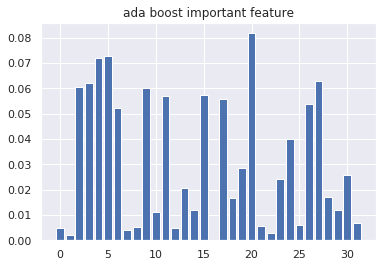

In [10]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

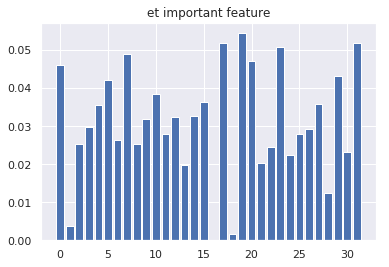

In [11]:
plt.bar(np.arange(32), et.feature_importances_)
plt.title('et important feature')
plt.show()

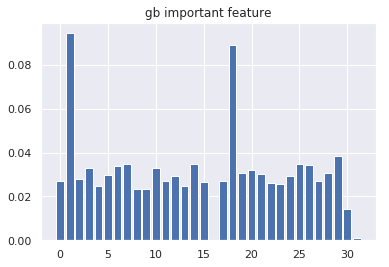

In [12]:
plt.bar(np.arange(32), gb.feature_importances_)
plt.title('gb important feature')
plt.show()

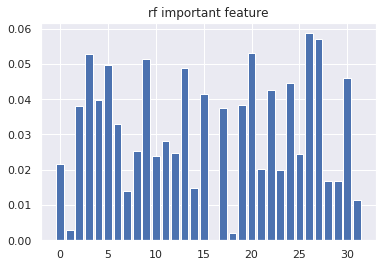

In [13]:
plt.bar(np.arange(32), rf.feature_importances_)
plt.title('rf important feature')
plt.show()

In [14]:
ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)

In [15]:
ada_actual = np.hstack([close_normalize[0],ada_pred[:-1]])
bagging_actual = np.hstack([close_normalize[0],bagging_pred[:-1]])
et_actual = np.hstack([close_normalize[0],et_pred[:-1]])
gb_actual = np.hstack([close_normalize[0],gb_pred[:-1]])
rf_actual = np.hstack([close_normalize[0],rf_pred[:-1]])
stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,close_normalize]).T
corr_df = pd.DataFrame(stack_predict)

In [16]:
print(ada_actual[0:5])
print(et_actual[0:5])
print(stack_predict[0:5])

[0.52661307 0.5355719  0.56672047 0.60223314 0.62642193]
[0.52661307 0.56928082 0.60219198 0.62209472 0.62748179]
[[0.52661307 0.52661307 0.52661307 0.52661307 0.52661307 0.52661307]
 [0.5355719  0.55624452 0.56928082 0.54987622 0.55625198 0.56928082]
 [0.56672047 0.59009861 0.60219198 0.57657667 0.58984276 0.60219198]
 [0.60223314 0.60529105 0.62209472 0.60759872 0.60542193 0.62209472]
 [0.62642193 0.62744579 0.62748179 0.6259174  0.62740187 0.66097476]]


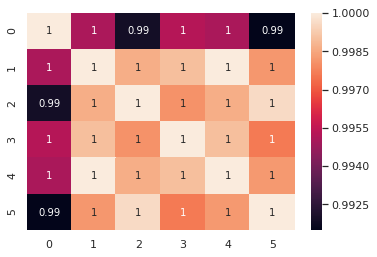

In [17]:
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

# Wow, I do not expect this heatmap. Totally a heat!

In [18]:
import xgboost as xgb
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = close_normalize[1:]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict[:-1,:],train_Y, eval_set=[(stack_predict[:-1,:],train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [19]:
xgb_pred = clf.predict(stack_predict)
xgb_actual = np.hstack([close_normalize[0],xgb_pred[:-1]])
date_original=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

In [20]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

In [ ]:

plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.plot(x_range, reverse_close(xgb_pred), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range[::50], date_original[::50])
plt.title('stacked')
plt.show()

In [22]:
# 基于上次的预测结果，按照history窗口，又堆叠起来，再做一次预测 ?

ada_list = ada_pred.tolist()
bagging_list = bagging_pred.tolist()
et_list = et_pred.tolist()
gb_list = gb_pred.tolist()
rf_list = rf_pred.tolist()
xgb_list = xgb_pred.tolist()
def predict(count, history = 5):
    for i in range(count):
        roll = np.array(xgb_list[-history:])
        thought_vector = Encoder.encode(roll.reshape((-1,1)))
        ada_pred=ada.predict(thought_vector)
        bagging_pred=bagging.predict(thought_vector)
        et_pred=et.predict(thought_vector)
        gb_pred=gb.predict(thought_vector)
        rf_pred=rf.predict(thought_vector)
        ada_list.append(ada_pred[-1])
        bagging_list.append(bagging_pred[-1])
        et_list.append(et_pred[-1])
        gb_list.append(gb_pred[-1])
        rf_list.append(rf_pred[-1])
        ada_actual = np.hstack([xgb_list[-history],ada_pred[:-1]])
        bagging_actual = np.hstack([xgb_list[-history],bagging_pred[:-1]])
        et_actual = np.hstack([xgb_list[-history],et_pred[:-1]])
        gb_actual = np.hstack([xgb_list[-history],gb_pred[:-1]])
        rf_actual = np.hstack([xgb_list[-history],rf_pred[:-1]])
        stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,xgb_list[-history:]]).T
        xgb_pred = clf.predict(stack_predict)
        xgb_list.append(xgb_pred[-1])
        date_ori.append(date_ori[-1]+timedelta(days=1))

In [23]:
predict(30, history = 5)

In [ ]:
%matplotlib notebook

plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range_future, reverse_close(np.array(ada_list)), label = 'ada Close')
plt.plot(x_range_future, reverse_close(np.array(bagging_list)), label = 'bagging Close')
plt.plot(x_range_future, reverse_close(np.array(et_list)), label = 'et Close')
plt.plot(x_range_future, reverse_close(np.array(gb_list)), label = 'gb Close')
plt.plot(x_range_future, reverse_close(np.array(rf_list)), label = 'rf Close')
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

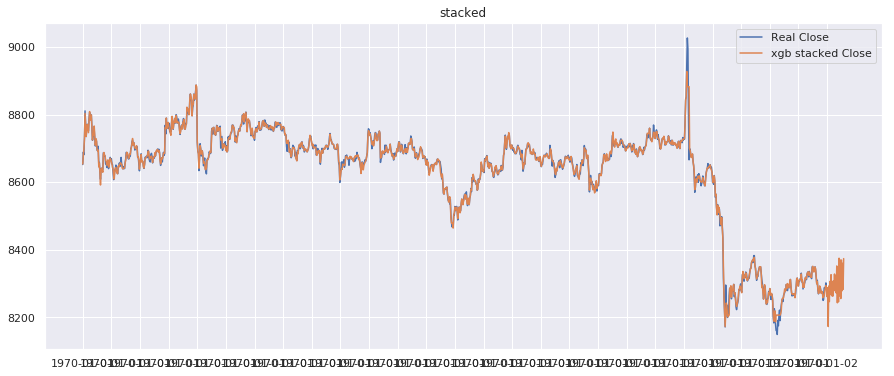

In [25]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')

plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

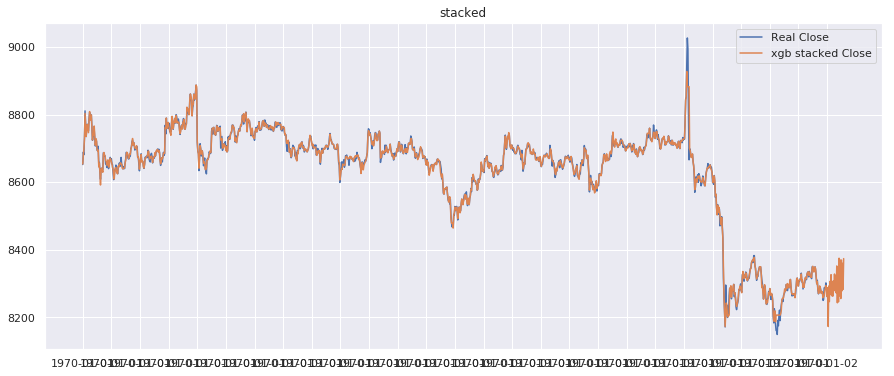

In [26]:

plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

# predict one time data

In [27]:
df_ = pd.read_csv('../dataset/predict-set-20190527-0531.csv')
date_ori = pd.to_datetime(df_.iloc[:, 0]).tolist()
print(df_.head())
print(df_.shape,len(df),df_.iloc[1])

    Timestamp        Close         High          Low         Open  \
0  1558915200  8653.011422  8660.000000  8607.303062  8616.502752   
1  1558915500  8689.545605  8729.091604  8653.815050  8653.815050   
2  1558915800  8682.085232  8698.578593  8658.146320  8682.595359   
3  1558916100  8733.177325  8733.177325  8700.000000  8700.000000   
4  1558916400  8811.826574  8815.225937  8734.000000  8734.000000   

          Volume  
0   20803.498272  
1  122780.290759  
2   48788.811247  
3   36294.412783  
4  164608.486049  
(1300, 6) 1300 Timestamp    1.558916e+09
Close        8.689546e+03
High         8.729092e+03
Low          8.653815e+03
Open         8.653815e+03
Volume       1.227803e+05
Name: 1, dtype: float64


In [28]:
predicted_ = []
for i in range(len(df_)):
    # 如果单一数据放进scaler的话，可能使返回的归一化的数据恒为0.
    #minmax_ = MinMaxScaler().fit(df_.iloc[i, 4].values.reshape((-1,1)))
    minmax_ = MinMaxScaler().fit(df_.iloc[i, 4])
    #data_normalize = minmax_.transform(df_.iloc[i, 4].values.reshape((-1,1))).reshape((-1))
    data_normalize = minmax_.transform(df_.iloc[i, 4])
    
    tf.reset_default_graph()
    Encoder_=encoder(data_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
    encoded_vector = Encoder_.encode(data_normalize.reshape((-1,1)))
    
    ada_pred_=ada.predict(encoded_vector)
    bagging_pred_=bagging.predict(encoded_vector)
    et_pred_=et.predict(encoded_vector)
    gb_pred_=gb.predict(encoded_vector)
    rf_pred_=rf.predict(encoded_vector)
    
    ada_actual_ = np.hstack([data_normalize[0],ada_pred_[:-1]])
    bagging_actual_ = np.hstack([data_normalize[0],bagging_pred_[:-1]])
    et_actual_ = np.hstack([data_normalize[0],et_pred_[:-1]])
    gb_actual_ = np.hstack([data_normalize[0],gb_pred_[:-1]])
    rf_actual_ = np.hstack([data_normalize[0],rf_pred_[:-1]])
    stack_predict_ = np.vstack([ada_actual_,bagging_actual_,et_actual_,gb_actual_,rf_actual_,data_normalize]).T
    
    xgb_pred_ = clf.predict(stack_predict_)
#    xgb_actual_ = np.hstack([data_normalize[0],xgb_pred_[:-1]])

    def reverse_close(array):
        return minmax_.inverse_transform(array.reshape((-1,1))).reshape((-1))
    predicted_.append(reverse_close(xgb_pred_)[-1])
    
    if (i + 1) % 10 == 0:
        print('at times:', i + 1,)
    
plt.figure(figsize = (15,6))
x_range = np.arange(df_.Close.shape[0])
plt.plot(x_range, df_.Close, label = 'Real Close')
#plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
#plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
#plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
#plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
#plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.plot(x_range, predicted_, label = 'xgb stacked Close')
plt.legend()
#plt.xticks(x_range[::50], date_original[::50])
plt.title('stacked')
plt.show()

/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9984385 time: 0.0005371570587158203
epoch: 20 loss: 0.9983855 time: 0.0004420280456542969
epoch: 30 loss: 0.9982865 time: 0.0003180503845214844
epoch: 40 loss: 0.99808866 time: 0.0003437995910644531
epoch: 50 loss: 0.9976232 time: 0.0003314018249511719
epoch: 60 loss: 0.9959656 time: 0.00032806396484375
epoch: 70 loss: 0.56745595 time: 0.00036072731018066406
epoch: 80 loss: 6.4721695e-05 time: 0.00039076805114746094
epoch: 90 loss: 5.7448233e-05 time: 0.00039458274841308594
epoch: 100 loss: 4.820776e-05 time: 0.0003921985626220703


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0012603541 time: 0.0004737377166748047
epoch: 20 loss: 0.0011455877 time: 0.0003859996795654297
epoch: 30 loss: 0.0009915569 time: 0.0003807544708251953
epoch: 40 loss: 0.00080618035 time: 0.00036334991455078125
epoch: 50 loss: 0.0006105582 time: 0.0003387928009033203
epoch: 60 loss: 0.00043109144 time: 0.0003173351287841797
epoch: 70 loss: 0.0002865935 time: 0.00036263465881347656
epoch: 80 loss: 0.00018205217 time: 0.00037360191345214844
epoch: 90 loss: 0.00011211404 time: 0.00038170814514160156
epoch: 100 loss: 6.7711575e-05 time: 0.0003864765167236328


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 9.238376e-08 time: 0.0004961490631103516
epoch: 20 loss: 9.238358e-08 time: 0.00035834312438964844
epoch: 30 loss: 9.238358e-08 time: 0.0003979206085205078
epoch: 40 loss: 9.2383225e-08 time: 0.00033736228942871094
epoch: 50 loss: 9.238216e-08 time: 0.0003364086151123047
epoch: 60 loss: 9.2378286e-08 time: 0.00033402442932128906
epoch: 70 loss: 9.237071e-08 time: 0.0003669261932373047
epoch: 80 loss: 9.23538e-08 time: 0.0003314018249511719
epoch: 90 loss: 9.232423e-08 time: 0.0005042552947998047
epoch: 100 loss: 9.2268436e-08 time: 0.00041794776916503906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 5.9202026e-05 time: 0.002041339874267578
epoch: 20 loss: 5.8912752e-05 time: 0.0010614395141601562
epoch: 30 loss: 5.8429297e-05 time: 0.0005705356597900391
epoch: 40 loss: 5.7628095e-05 time: 0.0006768703460693359
epoch: 50 loss: 5.6319834e-05 time: 0.00074005126953125
epoch: 60 loss: 5.4232998e-05 time: 0.0011243820190429688
epoch: 70 loss: 5.1027262e-05 time: 0.0005538463592529297
epoch: 80 loss: 4.6376557e-05 time: 0.0005023479461669922
epoch: 90 loss: 4.016255e-05 time: 0.0005061626434326172
epoch: 100 loss: 3.271744e-05 time: 0.00040149688720703125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0450672 time: 0.0005154609680175781
epoch: 20 loss: 0.009694397 time: 0.00038909912109375
epoch: 30 loss: 0.00393633 time: 0.0004773139953613281
epoch: 40 loss: 0.001925109 time: 0.00044727325439453125
epoch: 50 loss: 0.0010220543 time: 0.000339508056640625
epoch: 60 loss: 0.0005663172 time: 0.0005021095275878906
epoch: 70 loss: 0.00032150757 time: 0.0003695487976074219
epoch: 80 loss: 0.00018519483 time: 0.00035309791564941406
epoch: 90 loss: 0.000107636944 time: 0.0003414154052734375
epoch: 100 loss: 6.291584e-05 time: 0.0003342628479003906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.47910422 time: 0.0005314350128173828
epoch: 20 loss: 0.024239965 time: 0.000499725341796875
epoch: 30 loss: 0.007228811 time: 0.0004391670227050781
epoch: 40 loss: 0.003197487 time: 0.0003533363342285156
epoch: 50 loss: 0.0016251132 time: 0.000347137451171875
epoch: 60 loss: 0.0008821152 time: 0.000362396240234375
epoch: 70 loss: 0.00049617136 time: 0.0003714561462402344
epoch: 80 loss: 0.0002849509 time: 0.00033974647521972656
epoch: 90 loss: 0.00016574572 time: 0.0003402233123779297
epoch: 100 loss: 9.719379e-05 time: 0.00035881996154785156


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.8365426 time: 0.0005090236663818359
epoch: 20 loss: 0.055265978 time: 0.00034427642822265625
epoch: 30 loss: 0.008698497 time: 0.0003361701965332031
epoch: 40 loss: 0.0033081358 time: 0.0003323554992675781
epoch: 50 loss: 0.0015660668 time: 0.0003724098205566406
epoch: 60 loss: 0.0008132821 time: 0.0003540515899658203
epoch: 70 loss: 0.00044291967 time: 0.0003402233123779297
epoch: 80 loss: 0.00024785433 time: 0.00042510032653808594
epoch: 90 loss: 0.00014102172 time: 0.00036215782165527344
epoch: 100 loss: 8.1109545e-05 time: 0.00042366981506347656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.0 time: 0.0004734992980957031
epoch: 20 loss: 1.0 time: 0.0005161762237548828
epoch: 30 loss: 1.0 time: 0.0003814697265625
epoch: 40 loss: 1.0 time: 0.00040078163146972656
epoch: 50 loss: 1.0 time: 0.0006146430969238281
epoch: 60 loss: 1.0 time: 0.00042128562927246094
epoch: 70 loss: 1.0 time: 0.00037860870361328125
epoch: 80 loss: 1.0 time: 0.0003948211669921875
epoch: 90 loss: 1.0 time: 0.0005071163177490234
epoch: 100 loss: 1.0 time: 0.0003457069396972656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.11329423 time: 0.0004730224609375
epoch: 20 loss: 0.010493436 time: 0.0004570484161376953
epoch: 30 loss: 0.0038002757 time: 0.0004115104675292969
epoch: 40 loss: 0.0017907151 time: 0.00040149688720703125
epoch: 50 loss: 0.00093672506 time: 0.0003304481506347656
epoch: 60 loss: 0.0005161857 time: 0.0003616809844970703
epoch: 70 loss: 0.0002928064 time: 0.0003566741943359375
epoch: 80 loss: 0.00016897987 time: 0.0003695487976074219
epoch: 90 loss: 9.856848e-05 time: 0.0003325939178466797
epoch: 100 loss: 5.7893012e-05 time: 0.000408172607421875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.4069273e-11 time: 0.0004317760467529297
epoch: 20 loss: 2.4069273e-11 time: 0.0004031658172607422
epoch: 30 loss: 2.4069273e-11 time: 0.00035834312438964844
epoch: 40 loss: 2.4069273e-11 time: 0.00033283233642578125
epoch: 50 loss: 2.4069273e-11 time: 0.00032520294189453125
epoch: 60 loss: 2.4069273e-11 time: 0.00033736228942871094
epoch: 70 loss: 2.4069273e-11 time: 0.0003209114074707031
epoch: 80 loss: 2.4069273e-11 time: 0.0004019737243652344
epoch: 90 loss: 2.4069273e-11 time: 0.00036025047302246094
epoch: 100 loss: 2.4069273e-11 time: 0.0003561973571777344
at times: 10


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.0076761e-06 time: 0.0005609989166259766
epoch: 20 loss: 2.0073987e-06 time: 0.0003628730773925781
epoch: 30 loss: 2.0069056e-06 time: 0.00045228004455566406
epoch: 40 loss: 2.006e-06 time: 0.00034737586975097656
epoch: 50 loss: 2.0044147e-06 time: 0.00036144256591796875
epoch: 60 loss: 2.0016853e-06 time: 0.00034332275390625
epoch: 70 loss: 1.9970755e-06 time: 0.0005075931549072266
epoch: 80 loss: 1.989289e-06 time: 0.0003788471221923828
epoch: 90 loss: 1.9762392e-06 time: 0.0003829002380371094
epoch: 100 loss: 1.9545078e-06 time: 0.0003590583801269531


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0027985056 time: 0.0006091594696044922
epoch: 20 loss: 0.0021707327 time: 0.00039076805114746094
epoch: 30 loss: 0.0015690512 time: 0.00044083595275878906
epoch: 40 loss: 0.0010651516 time: 0.0003571510314941406
epoch: 50 loss: 0.0006886917 time: 0.0003724098205566406
epoch: 60 loss: 0.00043050604 time: 0.0004253387451171875
epoch: 70 loss: 0.0002634141 time: 0.0003409385681152344
epoch: 80 loss: 0.0001591395 time: 0.00034356117248535156
epoch: 90 loss: 9.5453506e-05 time: 0.001135110855102539
epoch: 100 loss: 5.703012e-05 time: 0.0003437995910644531


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9963686 time: 0.0004754066467285156
epoch: 20 loss: 0.9959779 time: 0.0003871917724609375
epoch: 30 loss: 0.9950896 time: 0.00046896934509277344
epoch: 40 loss: 0.99224263 time: 0.0003299713134765625
epoch: 50 loss: 0.9354418 time: 0.0003960132598876953
epoch: 60 loss: 0.00087817555 time: 0.0003407001495361328
epoch: 70 loss: 0.00051344757 time: 0.00042557716369628906
epoch: 80 loss: 0.0003018549 time: 0.00042819976806640625
epoch: 90 loss: 0.00017813925 time: 0.0003631114959716797
epoch: 100 loss: 0.000105402694 time: 0.0003764629364013672


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00018665814 time: 0.0005192756652832031
epoch: 20 loss: 0.00018256535 time: 0.0003914833068847656
epoch: 30 loss: 0.0001760239 time: 0.0004253387451171875
epoch: 40 loss: 0.0001659476 time: 0.0003714561462402344
epoch: 50 loss: 0.00015126418 time: 0.00034999847412109375
epoch: 60 loss: 0.00013152673 time: 0.0003490447998046875
epoch: 70 loss: 0.00010769549 time: 0.000335693359375
epoch: 80 loss: 8.239686e-05 time: 0.00034689903259277344
epoch: 90 loss: 5.896702e-05 time: 0.0003681182861328125
epoch: 100 loss: 3.984944e-05 time: 0.00037550926208496094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.02772888 time: 0.0012240409851074219
epoch: 20 loss: 0.009145124 time: 0.0009586811065673828
epoch: 30 loss: 0.0041212025 time: 0.0010747909545898438
epoch: 40 loss: 0.00209963 time: 0.0006957054138183594
epoch: 50 loss: 0.0011364535 time: 0.0005488395690917969
epoch: 60 loss: 0.000636049 time: 0.00078582763671875
epoch: 70 loss: 0.00036308166 time: 0.0005483627319335938
epoch: 80 loss: 0.0002097994 time: 0.0005784034729003906
epoch: 90 loss: 0.00012216775 time: 0.00048041343688964844
epoch: 100 loss: 7.149717e-05 time: 0.00042748451232910156


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.35864505 time: 0.0004558563232421875
epoch: 20 loss: 0.016542483 time: 0.0004343986511230469
epoch: 30 loss: 0.005686301 time: 0.00035190582275390625
epoch: 40 loss: 0.0026692958 time: 0.00038313865661621094
epoch: 50 loss: 0.0014046222 time: 0.0005557537078857422
epoch: 60 loss: 0.0007805413 time: 0.0003781318664550781
epoch: 70 loss: 0.00044661423 time: 0.00048828125
epoch: 80 loss: 0.00025984153 time: 0.00038909912109375
epoch: 90 loss: 0.00015266793 time: 0.0004544258117675781
epoch: 100 loss: 9.022695e-05 time: 0.0004405975341796875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99010766 time: 0.0005970001220703125
epoch: 20 loss: 0.9875885 time: 0.0003859996795654297
epoch: 30 loss: 0.97853327 time: 0.0006060600280761719
epoch: 40 loss: 0.3638074 time: 0.0005333423614501953
epoch: 50 loss: 0.0027933072 time: 0.0004968643188476562
epoch: 60 loss: 0.0010553859 time: 0.0004200935363769531
epoch: 70 loss: 0.00051221886 time: 0.0003597736358642578
epoch: 80 loss: 0.0002734075 time: 0.00034880638122558594
epoch: 90 loss: 0.00015280547 time: 0.00044274330139160156
epoch: 100 loss: 8.7545006e-05 time: 0.0010612010955810547


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0008919564 time: 0.0004839897155761719
epoch: 20 loss: 0.00082209334 time: 0.0003726482391357422
epoch: 30 loss: 0.00072535576 time: 0.00044727325439453125
epoch: 40 loss: 0.00060407486 time: 0.0003402233123779297
epoch: 50 loss: 0.00046979796 time: 0.0003745555877685547
epoch: 60 loss: 0.00034033332 time: 0.00034499168395996094
epoch: 70 loss: 0.00023125889 time: 0.0003838539123535156
epoch: 80 loss: 0.00014938034 time: 0.0003418922424316406
epoch: 90 loss: 9.308703e-05 time: 0.0003383159637451172
epoch: 100 loss: 5.6663703e-05 time: 0.00035881996154785156


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99687237 time: 0.0004374980926513672
epoch: 20 loss: 0.99671525 time: 0.0007112026214599609
epoch: 30 loss: 0.9964112 time: 0.0011320114135742188
epoch: 40 loss: 0.9957485 time: 0.0004477500915527344
epoch: 50 loss: 0.99385136 time: 0.00036072731018066406
epoch: 60 loss: 0.97868466 time: 0.0003552436828613281
epoch: 70 loss: 0.002178075 time: 0.00045037269592285156
epoch: 80 loss: 0.00065268157 time: 0.0003592967987060547
epoch: 90 loss: 0.00029494922 time: 0.0003662109375
epoch: 100 loss: 0.00015166751 time: 0.00037097930908203125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 7.123268e-06 time: 0.00055694580078125
epoch: 20 loss: 7.1195636e-06 time: 0.0009005069732666016
epoch: 30 loss: 7.1130853e-06 time: 0.0003972053527832031
epoch: 40 loss: 7.101986e-06 time: 0.0003650188446044922
epoch: 50 loss: 7.083164e-06 time: 0.00038313865661621094
epoch: 60 loss: 7.05153e-06 time: 0.0003502368927001953
epoch: 70 loss: 6.998537e-06 time: 0.00035452842712402344
epoch: 80 loss: 6.9105404e-06 time: 0.00036215782165527344
epoch: 90 loss: 6.7662936e-06 time: 0.0003266334533691406
epoch: 100 loss: 6.5351305e-06 time: 0.00033354759216308594
at times: 20


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.033323e-07 time: 0.0005011558532714844
epoch: 20 loss: 2.0333191e-07 time: 0.0004050731658935547
epoch: 30 loss: 2.0333039e-07 time: 0.0005552768707275391
epoch: 40 loss: 2.0332782e-07 time: 0.00048279762268066406
epoch: 50 loss: 2.0331989e-07 time: 0.00041222572326660156
epoch: 60 loss: 2.0329877e-07 time: 0.000522613525390625
epoch: 70 loss: 2.0325827e-07 time: 0.0004394054412841797
epoch: 80 loss: 2.0317924e-07 time: 0.0003571510314941406
epoch: 90 loss: 2.0304371e-07 time: 0.00034737586975097656
epoch: 100 loss: 2.0280542e-07 time: 0.0003666877746582031


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9804919 time: 0.0005042552947998047
epoch: 20 loss: 0.9642316 time: 0.00037479400634765625
epoch: 30 loss: 0.04954975 time: 0.00044727325439453125
epoch: 40 loss: 0.003877995 time: 0.0003762245178222656
epoch: 50 loss: 0.0015138537 time: 0.0003764629364013672
epoch: 60 loss: 0.000745834 time: 0.0013473033905029297
epoch: 70 loss: 0.0004023402 time: 0.00040221214294433594
epoch: 80 loss: 0.00022688431 time: 0.0003592967987060547
epoch: 90 loss: 0.00013105886 time: 0.0003504753112792969
epoch: 100 loss: 7.675908e-05 time: 0.0004062652587890625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0044766706 time: 0.0005424022674560547
epoch: 20 loss: 0.0028511072 time: 0.0003552436828613281
epoch: 30 loss: 0.001759202 time: 0.002064943313598633
epoch: 40 loss: 0.0010661893 time: 0.00039315223693847656
epoch: 50 loss: 0.00064049667 time: 0.0004494190216064453
epoch: 60 loss: 0.00038338877 time: 0.00036597251892089844
epoch: 70 loss: 0.00022929032 time: 0.0004711151123046875
epoch: 80 loss: 0.00013717411 time: 0.0009367465972900391
epoch: 90 loss: 8.212492e-05 time: 0.00041413307189941406
epoch: 100 loss: 4.920291e-05 time: 0.0005750656127929688


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99069816 time: 0.0005624294281005859
epoch: 20 loss: 0.98712194 time: 0.0004906654357910156
epoch: 30 loss: 0.96687907 time: 0.0004949569702148438
epoch: 40 loss: 0.011837073 time: 0.0007619857788085938
epoch: 50 loss: 0.0025390044 time: 0.0004467964172363281
epoch: 60 loss: 0.0010801549 time: 0.0008513927459716797
epoch: 70 loss: 0.0005452509 time: 0.00044345855712890625
epoch: 80 loss: 0.00029595883 time: 0.0006487369537353516
epoch: 90 loss: 0.00016665268 time: 0.0005125999450683594
epoch: 100 loss: 9.5759315e-05 time: 0.0012989044189453125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9999974 time: 0.0013325214385986328
epoch: 20 loss: 0.9999974 time: 0.0004439353942871094
epoch: 30 loss: 0.9999974 time: 0.0006732940673828125
epoch: 40 loss: 0.9999974 time: 0.0004870891571044922
epoch: 50 loss: 0.9999974 time: 0.0003662109375
epoch: 60 loss: 0.9999974 time: 0.00038361549377441406
epoch: 70 loss: 0.9999974 time: 0.0004973411560058594
epoch: 80 loss: 0.9999974 time: 0.0012252330780029297
epoch: 90 loss: 0.9999974 time: 0.0003566741943359375
epoch: 100 loss: 0.9999974 time: 0.00040268898010253906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.3418206e-07 time: 0.0004787445068359375
epoch: 20 loss: 1.3418179e-07 time: 0.0004677772521972656
epoch: 30 loss: 1.3418129e-07 time: 0.00033855438232421875
epoch: 40 loss: 1.3417949e-07 time: 0.0004124641418457031
epoch: 50 loss: 1.341745e-07 time: 0.00035071372985839844
epoch: 60 loss: 1.3416428e-07 time: 0.0003657341003417969
epoch: 70 loss: 1.3413998e-07 time: 0.0003497600555419922
epoch: 80 loss: 1.34091e-07 time: 0.0003421306610107422
epoch: 90 loss: 1.3399747e-07 time: 0.0003559589385986328
epoch: 100 loss: 1.3383365e-07 time: 0.0003612041473388672


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0038897155 time: 0.0004901885986328125
epoch: 20 loss: 0.0030147235 time: 0.0004012584686279297
epoch: 30 loss: 0.0021718144 time: 0.00034618377685546875
epoch: 40 loss: 0.0014650571 time: 0.0004527568817138672
epoch: 50 loss: 0.0009388644 time: 0.001512289047241211
epoch: 60 loss: 0.00058068807 time: 0.0003612041473388672
epoch: 70 loss: 0.00035124779 time: 0.0016679763793945312
epoch: 80 loss: 0.00020973178 time: 0.0017926692962646484
epoch: 90 loss: 0.00012435253 time: 0.0004973411560058594
epoch: 100 loss: 7.346579e-05 time: 0.0007233619689941406


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 4.924569e-08 time: 0.0004138946533203125
epoch: 20 loss: 4.924569e-08 time: 0.0008301734924316406
epoch: 30 loss: 4.924569e-08 time: 0.0004994869232177734
epoch: 40 loss: 4.924569e-08 time: 0.00040268898010253906
epoch: 50 loss: 4.924531e-08 time: 0.00039958953857421875
epoch: 60 loss: 4.9244836e-08 time: 0.0004012584686279297
epoch: 70 loss: 4.9242956e-08 time: 0.0003514289855957031
epoch: 80 loss: 4.923949e-08 time: 0.0003514289855957031
epoch: 90 loss: 4.9231602e-08 time: 0.0003695487976074219
epoch: 100 loss: 4.9216204e-08 time: 0.00036072731018066406


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.009365422 time: 0.0004892349243164062
epoch: 20 loss: 0.005038541 time: 0.0004730224609375
epoch: 30 loss: 0.0027504207 time: 0.0003674030303955078
epoch: 40 loss: 0.0015234087 time: 0.00034999847412109375
epoch: 50 loss: 0.000854476 time: 0.0004839897155761719
epoch: 60 loss: 0.00048423573 time: 0.000354766845703125
epoch: 70 loss: 0.0002766938 time: 0.0003542900085449219
epoch: 80 loss: 0.00015915208 time: 0.00039267539978027344
epoch: 90 loss: 9.203168e-05 time: 0.00034046173095703125
epoch: 100 loss: 5.345036e-05 time: 0.0003421306610107422


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99999976 time: 0.00048422813415527344
epoch: 20 loss: 0.99999976 time: 0.0004515647888183594
epoch: 30 loss: 0.99999976 time: 0.0003859996795654297
epoch: 40 loss: 0.99999976 time: 0.00033926963806152344
epoch: 50 loss: 0.99999976 time: 0.0003688335418701172
epoch: 60 loss: 0.99999976 time: 0.0003490447998046875
epoch: 70 loss: 0.99999976 time: 0.0003437995910644531
epoch: 80 loss: 0.99999976 time: 0.000354766845703125
epoch: 90 loss: 0.99999976 time: 0.00037026405334472656
epoch: 100 loss: 0.99999976 time: 0.0003275871276855469
at times: 30


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.2747522e-09 time: 0.00044846534729003906
epoch: 20 loss: 3.2747522e-09 time: 0.0004153251647949219
epoch: 30 loss: 3.2747522e-09 time: 0.0003528594970703125
epoch: 40 loss: 3.2747522e-09 time: 0.00037479400634765625
epoch: 50 loss: 3.2747522e-09 time: 0.0003612041473388672
epoch: 60 loss: 3.2747522e-09 time: 0.0003566741943359375
epoch: 70 loss: 3.2747522e-09 time: 0.000354766845703125
epoch: 80 loss: 3.2747522e-09 time: 0.00039768218994140625
epoch: 90 loss: 3.2747463e-09 time: 0.0003542900085449219
epoch: 100 loss: 3.2747338e-09 time: 0.00035071372985839844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.020840354 time: 0.0005028247833251953
epoch: 20 loss: 0.006546834 time: 0.00034046173095703125
epoch: 30 loss: 0.0029659406 time: 0.0004017353057861328
epoch: 40 loss: 0.0015314939 time: 0.0003287792205810547
epoch: 50 loss: 0.00084154063 time: 0.0003466606140136719
epoch: 60 loss: 0.00047822652 time: 0.0003368854522705078
epoch: 70 loss: 0.00027711372 time: 0.00032401084899902344
epoch: 80 loss: 0.00016248252 time: 0.00036835670471191406
epoch: 90 loss: 9.59716e-05 time: 0.0004057884216308594
epoch: 100 loss: 5.6949855e-05 time: 0.000370025634765625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.012731444 time: 0.0004978179931640625
epoch: 20 loss: 0.0061153956 time: 0.00042319297790527344
epoch: 30 loss: 0.0031777504 time: 0.0003848075866699219
epoch: 40 loss: 0.0017291314 time: 0.00042176246643066406
epoch: 50 loss: 0.00096803886 time: 0.00038814544677734375
epoch: 60 loss: 0.0005519368 time: 0.0003566741943359375
epoch: 70 loss: 0.0003185184 time: 0.00037670135498046875
epoch: 80 loss: 0.00018532517 time: 0.000370025634765625
epoch: 90 loss: 0.00010843754 time: 0.0004067420959472656
epoch: 100 loss: 6.369949e-05 time: 0.0005185604095458984


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.017192172 time: 0.0004937648773193359
epoch: 20 loss: 0.0061987042 time: 0.00044465065002441406
epoch: 30 loss: 0.0028647275 time: 0.0003592967987060547
epoch: 40 loss: 0.0014717517 time: 0.00033593177795410156
epoch: 50 loss: 0.00079859 time: 0.0003783702850341797
epoch: 60 loss: 0.00044709814 time: 0.0003643035888671875
epoch: 70 loss: 0.00025515363 time: 0.0003421306610107422
epoch: 80 loss: 0.00014741895 time: 0.0003674030303955078
epoch: 90 loss: 8.587731e-05 time: 0.0003421306610107422
epoch: 100 loss: 5.0314397e-05 time: 0.000335693359375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.938189 time: 0.0004105567932128906
epoch: 20 loss: 0.7994225 time: 0.0003905296325683594
epoch: 30 loss: 0.0269563 time: 0.00037860870361328125
epoch: 40 loss: 0.006302645 time: 0.0003383159637451172
epoch: 50 loss: 0.0026357947 time: 0.00034427642822265625
epoch: 60 loss: 0.0013069015 time: 0.00034308433532714844
epoch: 70 loss: 0.00069885416 time: 0.0003409385681152344
epoch: 80 loss: 0.00038873462 time: 0.00034880638122558594
epoch: 90 loss: 0.00022113009 time: 0.00036025047302246094
epoch: 100 loss: 0.00012748865 time: 0.0003674030303955078


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.051936e-10 time: 0.0004127025604248047
epoch: 20 loss: 3.051936e-10 time: 0.0004024505615234375
epoch: 30 loss: 3.051936e-10 time: 0.00043392181396484375
epoch: 40 loss: 3.051936e-10 time: 0.0009317398071289062
epoch: 50 loss: 3.051936e-10 time: 0.0011360645294189453
epoch: 60 loss: 3.051936e-10 time: 0.0009899139404296875
epoch: 70 loss: 3.051936e-10 time: 0.0005536079406738281
epoch: 80 loss: 3.051936e-10 time: 0.002977609634399414
epoch: 90 loss: 3.051936e-10 time: 0.0010707378387451172
epoch: 100 loss: 3.051936e-10 time: 0.0010786056518554688


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9875577 time: 0.0004990100860595703
epoch: 20 loss: 0.98331827 time: 0.0004000663757324219
epoch: 30 loss: 0.9626167 time: 0.00047469139099121094
epoch: 40 loss: 0.01824458 time: 0.00037217140197753906
epoch: 50 loss: 0.003229088 time: 0.0004818439483642578
epoch: 60 loss: 0.0013357355 time: 0.00035762786865234375
epoch: 70 loss: 0.0006674796 time: 0.00035834312438964844
epoch: 80 loss: 0.00036066733 time: 0.0003743171691894531
epoch: 90 loss: 0.00020264949 time: 0.00034809112548828125
epoch: 100 loss: 0.00011632312 time: 0.00034046173095703125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.018317247 time: 0.00048232078552246094
epoch: 20 loss: 0.00798679 time: 0.00034737586975097656
epoch: 30 loss: 0.003957218 time: 0.0003409385681152344
epoch: 40 loss: 0.0020974323 time: 0.0003478527069091797
epoch: 50 loss: 0.0011557324 time: 0.0003407001495361328
epoch: 60 loss: 0.00065214414 time: 0.0003361701965332031
epoch: 70 loss: 0.00037360305 time: 0.00033783912658691406
epoch: 80 loss: 0.00021617857 time: 0.0003616809844970703
epoch: 90 loss: 0.00012593396 time: 0.0003337860107421875
epoch: 100 loss: 7.370388e-05 time: 0.00036144256591796875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9996037 time: 0.000484466552734375
epoch: 20 loss: 0.99959916 time: 0.0004558563232421875
epoch: 30 loss: 0.99959105 time: 0.0003647804260253906
epoch: 40 loss: 0.99957675 time: 0.0003936290740966797
epoch: 50 loss: 0.99955004 time: 0.00033473968505859375
epoch: 60 loss: 0.9994964 time: 0.0003414154052734375
epoch: 70 loss: 0.9993712 time: 0.0003802776336669922
epoch: 80 loss: 0.9989309 time: 0.0004017353057861328
epoch: 90 loss: 0.9596164 time: 0.0009362697601318359
epoch: 100 loss: 2.3434548e-07 time: 0.0004680156707763672


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.001370502 time: 0.0005419254302978516
epoch: 20 loss: 0.0012227414 time: 0.00041866302490234375
epoch: 30 loss: 0.0010326321 time: 0.0003459453582763672
epoch: 40 loss: 0.00081560155 time: 0.000335693359375
epoch: 50 loss: 0.0005996031 time: 0.0003445148468017578
epoch: 60 loss: 0.00041238093 time: 0.00035881996154785156
epoch: 70 loss: 0.0002687147 time: 0.0003459453582763672
epoch: 80 loss: 0.00016844849 time: 0.0003428459167480469
epoch: 90 loss: 0.00010296565 time: 0.001667022705078125
epoch: 100 loss: 6.199052e-05 time: 0.00035190582275390625
at times: 40


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9837518 time: 0.0006210803985595703
epoch: 20 loss: 0.9753597 time: 0.0015151500701904297
epoch: 30 loss: 0.887192 time: 0.0005013942718505859
epoch: 40 loss: 0.007245352 time: 0.00047278404235839844
epoch: 50 loss: 0.0021309862 time: 0.0005118846893310547
epoch: 60 loss: 0.00095504423 time: 0.0005383491516113281
epoch: 70 loss: 0.0004894609 time: 0.0004336833953857422
epoch: 80 loss: 0.00026660436 time: 0.00042629241943359375
epoch: 90 loss: 0.00014991194 time: 0.0003330707550048828
epoch: 100 loss: 8.58122e-05 time: 0.0003724098205566406


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99999976 time: 0.0004756450653076172
epoch: 20 loss: 0.99999976 time: 0.00034689903259277344
epoch: 30 loss: 0.99999976 time: 0.0003287792205810547
epoch: 40 loss: 0.99999976 time: 0.00035572052001953125
epoch: 50 loss: 0.99999976 time: 0.00036215782165527344
epoch: 60 loss: 0.99999976 time: 0.00035381317138671875
epoch: 70 loss: 0.99999976 time: 0.0003361701965332031
epoch: 80 loss: 0.99999976 time: 0.00035500526428222656
epoch: 90 loss: 0.99999976 time: 0.0003542900085449219
epoch: 100 loss: 0.99999976 time: 0.0003414154052734375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.196118e-14 time: 0.00045418739318847656
epoch: 20 loss: 1.196118e-14 time: 0.0003905296325683594
epoch: 30 loss: 1.196118e-14 time: 0.0003635883331298828
epoch: 40 loss: 1.196118e-14 time: 0.0003705024719238281
epoch: 50 loss: 1.196118e-14 time: 0.0003402233123779297
epoch: 60 loss: 1.196118e-14 time: 0.0003459453582763672
epoch: 70 loss: 1.196118e-14 time: 0.0004298686981201172
epoch: 80 loss: 1.196118e-14 time: 0.0004725456237792969
epoch: 90 loss: 1.196118e-14 time: 0.001851797103881836
epoch: 100 loss: 1.196118e-14 time: 0.0009312629699707031


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00014722688 time: 0.0004868507385253906
epoch: 20 loss: 0.00014542411 time: 0.0003952980041503906
epoch: 30 loss: 0.00014246773 time: 0.0004639625549316406
epoch: 40 loss: 0.00013772171 time: 0.000331878662109375
epoch: 50 loss: 0.00013035424 time: 0.0005118846893310547
epoch: 60 loss: 0.000119498836 time: 0.00034809112548828125
epoch: 70 loss: 0.00010467804 time: 0.00034236907958984375
epoch: 80 loss: 8.6430286e-05 time: 0.00035691261291503906
epoch: 90 loss: 6.6634224e-05 time: 0.001272439956665039
epoch: 100 loss: 4.7919617e-05 time: 0.00034499168395996094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.8902957 time: 0.0004475116729736328
epoch: 20 loss: 0.055517502 time: 0.0004532337188720703
epoch: 30 loss: 0.007304317 time: 0.00033354759216308594
epoch: 40 loss: 0.0028179523 time: 0.00040030479431152344
epoch: 50 loss: 0.0013638755 time: 0.00035262107849121094
epoch: 60 loss: 0.00072410004 time: 0.0003590583801269531
epoch: 70 loss: 0.00040270522 time: 0.0003581047058105469
epoch: 80 loss: 0.00022980823 time: 0.0003590583801269531
epoch: 90 loss: 0.00013314438 time: 0.0003714561462402344
epoch: 100 loss: 7.785545e-05 time: 0.00036025047302246094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00013481436 time: 0.0005059242248535156
epoch: 20 loss: 0.00013302495 time: 0.0003592967987060547
epoch: 30 loss: 0.00013009815 time: 0.0003781318664550781
epoch: 40 loss: 0.00012541845 time: 0.0003428459167480469
epoch: 50 loss: 0.00011819951 time: 0.0003407001495361328
epoch: 60 loss: 0.00010766458 time: 0.00036716461181640625
epoch: 70 loss: 9.347433e-05 time: 0.0003294944763183594
epoch: 80 loss: 7.631007e-05 time: 0.0004696846008300781
epoch: 90 loss: 5.8074987e-05 time: 0.00037980079650878906
epoch: 100 loss: 4.1212974e-05 time: 0.0003695487976074219


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.0400142e-12 time: 0.0005478858947753906
epoch: 20 loss: 3.0400142e-12 time: 0.00052642822265625
epoch: 30 loss: 3.0400142e-12 time: 0.000499725341796875
epoch: 40 loss: 3.0400142e-12 time: 0.0003962516784667969
epoch: 50 loss: 3.0400142e-12 time: 0.00042891502380371094
epoch: 60 loss: 3.0400142e-12 time: 0.00039196014404296875
epoch: 70 loss: 3.0400142e-12 time: 0.0003323554992675781
epoch: 80 loss: 3.0400142e-12 time: 0.00043272972106933594
epoch: 90 loss: 3.0400142e-12 time: 0.0004973411560058594
epoch: 100 loss: 3.0400142e-12 time: 0.0003657341003417969


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9994492 time: 0.0004608631134033203
epoch: 20 loss: 0.9994423 time: 0.0003933906555175781
epoch: 30 loss: 0.99943036 time: 0.00040149688720703125
epoch: 40 loss: 0.9994089 time: 0.00036978721618652344
epoch: 50 loss: 0.9993688 time: 0.0003571510314941406
epoch: 60 loss: 0.99928725 time: 0.0003783702850341797
epoch: 70 loss: 0.99909097 time: 0.00034165382385253906
epoch: 80 loss: 0.9983459 time: 0.0010013580322265625
epoch: 90 loss: 0.16423057 time: 0.00034427642822265625
epoch: 100 loss: 1.2022729e-06 time: 0.0003643035888671875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 4.250932e-09 time: 0.00045371055603027344
epoch: 20 loss: 4.250932e-09 time: 0.0003504753112792969
epoch: 30 loss: 4.250932e-09 time: 0.00043463706970214844
epoch: 40 loss: 4.250932e-09 time: 0.0003933906555175781
epoch: 50 loss: 4.250932e-09 time: 0.0004296302795410156
epoch: 60 loss: 4.250932e-09 time: 0.0003612041473388672
epoch: 70 loss: 4.250932e-09 time: 0.00037932395935058594
epoch: 80 loss: 4.250932e-09 time: 0.0003445148468017578
epoch: 90 loss: 4.250932e-09 time: 0.00035858154296875
epoch: 100 loss: 4.2508996e-09 time: 0.0003666877746582031


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 8.340049e-10 time: 0.0005564689636230469
epoch: 20 loss: 8.340049e-10 time: 0.0003790855407714844
epoch: 30 loss: 8.340049e-10 time: 0.00039386749267578125
epoch: 40 loss: 8.340049e-10 time: 0.0003566741943359375
epoch: 50 loss: 8.340049e-10 time: 0.00036644935607910156
epoch: 60 loss: 8.340049e-10 time: 0.00035858154296875
epoch: 70 loss: 8.340049e-10 time: 0.00039839744567871094
epoch: 80 loss: 8.340049e-10 time: 0.0003578662872314453
epoch: 90 loss: 8.340049e-10 time: 0.0004985332489013672
epoch: 100 loss: 8.340049e-10 time: 0.000713348388671875
at times: 50


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9999473 time: 0.0005671977996826172
epoch: 20 loss: 0.9999471 time: 0.0004832744598388672
epoch: 30 loss: 0.9999471 time: 0.0003809928894042969
epoch: 40 loss: 0.99994683 time: 0.0003380775451660156
epoch: 50 loss: 0.99994636 time: 0.0003619194030761719
epoch: 60 loss: 0.99994564 time: 0.00035262107849121094
epoch: 70 loss: 0.99994445 time: 0.0003478527069091797
epoch: 80 loss: 0.99994254 time: 0.00035572052001953125
epoch: 90 loss: 0.9999385 time: 0.00035071372985839844
epoch: 100 loss: 0.9999304 time: 0.0003643035888671875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.038346034 time: 0.0005204677581787109
epoch: 20 loss: 0.012060089 time: 0.0004279613494873047
epoch: 30 loss: 0.005284494 time: 0.00035858154296875
epoch: 40 loss: 0.0026444772 time: 0.0003371238708496094
epoch: 50 loss: 0.0014134297 time: 0.0003571510314941406
epoch: 60 loss: 0.0007835985 time: 0.0003533363342285156
epoch: 70 loss: 0.00044397102 time: 0.00033664703369140625
epoch: 80 loss: 0.00025496693 time: 0.00040149688720703125
epoch: 90 loss: 0.00014770188 time: 0.00041675567626953125
epoch: 100 loss: 8.6054555e-05 time: 0.0003650188446044922


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.2052072e-05 time: 0.0004649162292480469
epoch: 20 loss: 1.2033885e-05 time: 0.0003781318664550781
epoch: 30 loss: 1.2002954e-05 time: 0.0003509521484375
epoch: 40 loss: 1.1950743e-05 time: 0.0003387928009033203
epoch: 50 loss: 1.1863392e-05 time: 0.00037384033203125
epoch: 60 loss: 1.1718321e-05 time: 0.0003657341003417969
epoch: 70 loss: 1.1480457e-05 time: 0.0003654956817626953
epoch: 80 loss: 1.1098948e-05 time: 0.0003719329833984375
epoch: 90 loss: 1.0507474e-05 time: 0.0004227161407470703
epoch: 100 loss: 9.6374315e-06 time: 0.000362396240234375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0008586384 time: 0.00046372413635253906
epoch: 20 loss: 0.0007845122 time: 0.0004265308380126953
epoch: 30 loss: 0.00068388676 time: 0.0003688335418701172
epoch: 40 loss: 0.0005609768 time: 0.0003592967987060547
epoch: 50 loss: 0.00042899905 time: 0.00037384033203125
epoch: 60 loss: 0.00030571193 time: 0.0003581047058105469
epoch: 70 loss: 0.00020478843 time: 0.0003654956817626953
epoch: 80 loss: 0.00013078412 time: 0.00033736228942871094
epoch: 90 loss: 8.0787315e-05 time: 0.0003612041473388672
epoch: 100 loss: 4.8840393e-05 time: 0.00034427642822265625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.019690234 time: 0.00044345855712890625
epoch: 20 loss: 0.006342151 time: 0.00034880638122558594
epoch: 30 loss: 0.0028871747 time: 0.0003516674041748047
epoch: 40 loss: 0.0014920839 time: 0.00031685829162597656
epoch: 50 loss: 0.00081956555 time: 0.00034165382385253906
epoch: 60 loss: 0.0004653498 time: 0.00035881996154785156
epoch: 70 loss: 0.0002693827 time: 0.00039958953857421875
epoch: 80 loss: 0.00015778265 time: 0.0004131793975830078
epoch: 90 loss: 9.309372e-05 time: 0.00039958953857421875
epoch: 100 loss: 5.5179422e-05 time: 0.0003445148468017578


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.83321595 time: 0.00045680999755859375
epoch: 20 loss: 0.024558859 time: 0.0004603862762451172
epoch: 30 loss: 0.0058222148 time: 0.0004532337188720703
epoch: 40 loss: 0.0024758591 time: 0.00045871734619140625
epoch: 50 loss: 0.001244908 time: 0.0013391971588134766
epoch: 60 loss: 0.00067401474 time: 0.0004851818084716797
epoch: 70 loss: 0.00037923572 time: 0.0004067420959472656
epoch: 80 loss: 0.00021807692 time: 0.0004496574401855469
epoch: 90 loss: 0.00012704474 time: 0.00039386749267578125
epoch: 100 loss: 7.460858e-05 time: 0.0003647804260253906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.0 time: 0.0004718303680419922
epoch: 20 loss: 1.0 time: 0.00038909912109375
epoch: 30 loss: 1.0 time: 0.0003647804260253906
epoch: 40 loss: 1.0 time: 0.00034880638122558594
epoch: 50 loss: 1.0 time: 0.0003962516784667969
epoch: 60 loss: 1.0 time: 0.0003914833068847656
epoch: 70 loss: 1.0 time: 0.00040459632873535156
epoch: 80 loss: 1.0 time: 0.00035500526428222656
epoch: 90 loss: 1.0 time: 0.0003590583801269531
epoch: 100 loss: 1.0 time: 0.0003299713134765625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.0323915e-16 time: 0.0004820823669433594
epoch: 20 loss: 3.0323915e-16 time: 0.0037772655487060547
epoch: 30 loss: 3.0323915e-16 time: 0.0005726814270019531
epoch: 40 loss: 3.0323915e-16 time: 0.0004062652587890625
epoch: 50 loss: 3.0323915e-16 time: 0.0003554821014404297
epoch: 60 loss: 3.0323915e-16 time: 0.0003848075866699219
epoch: 70 loss: 3.0323915e-16 time: 0.0003311634063720703
epoch: 80 loss: 3.0323915e-16 time: 0.00035071372985839844
epoch: 90 loss: 3.0323915e-16 time: 0.0003485679626464844
epoch: 100 loss: 3.0323915e-16 time: 0.0003345012664794922


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00010611483 time: 0.0004019737243652344
epoch: 20 loss: 0.000105121224 time: 0.0003731250762939453
epoch: 30 loss: 0.000103479346 time: 0.00033974647521972656
epoch: 40 loss: 0.00010081037 time: 0.0003376007080078125
epoch: 50 loss: 9.6584095e-05 time: 0.0003657341003417969
epoch: 60 loss: 9.016474e-05 time: 0.0003376007080078125
epoch: 70 loss: 8.100873e-05 time: 0.0003314018249511719
epoch: 80 loss: 6.9060734e-05 time: 0.0003731250762939453
epoch: 90 loss: 5.517148e-05 time: 0.0003819465637207031
epoch: 100 loss: 4.1055664e-05 time: 0.0003819465637207031


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9970338 time: 0.0003685951232910156
epoch: 20 loss: 0.9967391 time: 0.0003941059112548828
epoch: 30 loss: 0.99608225 time: 0.00040650367736816406
epoch: 40 loss: 0.9940887 time: 0.0003685951232910156
epoch: 50 loss: 0.9704452 time: 0.0003540515899658203
epoch: 60 loss: 0.000688738 time: 0.00034737586975097656
epoch: 70 loss: 0.0004351632 time: 0.0003459453582763672
epoch: 80 loss: 0.0002668861 time: 0.0003535747528076172
epoch: 90 loss: 0.00016068453 time: 0.00033974647521972656
epoch: 100 loss: 9.570074e-05 time: 0.00034332275390625
at times: 60


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.96110815 time: 0.00045943260192871094
epoch: 20 loss: 0.85920984 time: 0.00041365623474121094
epoch: 30 loss: 0.014097199 time: 0.0003631114959716797
epoch: 40 loss: 0.0037354354 time: 0.00035691261291503906
epoch: 50 loss: 0.0016338466 time: 0.00035309791564941406
epoch: 60 loss: 0.000830796 time: 0.000331878662109375
epoch: 70 loss: 0.00045189483 time: 0.0003478527069091797
epoch: 80 loss: 0.00025459012 time: 0.0003848075866699219
epoch: 90 loss: 0.00014630628 time: 0.0003914833068847656
epoch: 100 loss: 8.507591e-05 time: 0.0003757476806640625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.0 time: 0.00048422813415527344
epoch: 20 loss: 1.0 time: 0.0005717277526855469
epoch: 30 loss: 1.0 time: 0.0006062984466552734
epoch: 40 loss: 1.0 time: 0.0006780624389648438
epoch: 50 loss: 1.0 time: 0.000484466552734375
epoch: 60 loss: 1.0 time: 0.00034809112548828125
epoch: 70 loss: 1.0 time: 0.0004010200500488281
epoch: 80 loss: 1.0 time: 0.0006625652313232422
epoch: 90 loss: 1.0 time: 0.000698089599609375
epoch: 100 loss: 1.0 time: 0.0004544258117675781


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.515036e-08 time: 0.0005090236663818359
epoch: 20 loss: 1.515036e-08 time: 0.000518798828125
epoch: 30 loss: 1.515036e-08 time: 0.0003883838653564453
epoch: 40 loss: 1.515036e-08 time: 0.0003631114959716797
epoch: 50 loss: 1.515033e-08 time: 0.00035881996154785156
epoch: 60 loss: 1.51503e-08 time: 0.0003726482391357422
epoch: 70 loss: 1.5150272e-08 time: 0.00041866302490234375
epoch: 80 loss: 1.5150071e-08 time: 0.0004031658172607422
epoch: 90 loss: 1.5149666e-08 time: 0.00040268898010253906
epoch: 100 loss: 1.5148595e-08 time: 0.00038123130798339844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00623265 time: 0.00047707557678222656
epoch: 20 loss: 0.003921239 time: 0.00039386749267578125
epoch: 30 loss: 0.0023693377 time: 0.00034427642822265625
epoch: 40 loss: 0.0013991977 time: 0.0003952980041503906
epoch: 50 loss: 0.00081754953 time: 0.0004734992980957031
epoch: 60 loss: 0.00047614553 time: 0.0005624294281005859
epoch: 70 loss: 0.00027752362 time: 0.0004856586456298828
epoch: 80 loss: 0.00016219472 time: 0.0003311634063720703
epoch: 90 loss: 9.512488e-05 time: 0.00035190582275390625
epoch: 100 loss: 5.59946e-05 time: 0.00034689903259277344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.7161707e-07 time: 0.0003876686096191406
epoch: 20 loss: 1.7161707e-07 time: 0.00042176246643066406
epoch: 30 loss: 1.7161643e-07 time: 0.00033783912658691406
epoch: 40 loss: 1.716143e-07 time: 0.00035643577575683594
epoch: 50 loss: 1.7160893e-07 time: 0.0003561973571777344
epoch: 60 loss: 1.7159434e-07 time: 0.0003452301025390625
epoch: 70 loss: 1.7156589e-07 time: 0.00034737586975097656
epoch: 80 loss: 1.7151389e-07 time: 0.0003440380096435547
epoch: 90 loss: 1.7141876e-07 time: 0.00035071372985839844
epoch: 100 loss: 1.7125203e-07 time: 0.0003535747528076172


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99881136 time: 0.00043892860412597656
epoch: 20 loss: 0.9987775 time: 0.0004799365997314453
epoch: 30 loss: 0.99871594 time: 0.0021774768829345703
epoch: 40 loss: 0.99859667 time: 0.0007038116455078125
epoch: 50 loss: 0.99833536 time: 0.0004973411560058594
epoch: 60 loss: 0.99758023 time: 0.00043272972106933594
epoch: 70 loss: 0.99100417 time: 0.00040078163146972656
epoch: 80 loss: 5.0103317e-06 time: 0.0003402233123779297
epoch: 90 loss: 4.9759233e-06 time: 0.0003504753112792969
epoch: 100 loss: 4.9187024e-06 time: 0.00033855438232421875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.80475307 time: 0.0004622936248779297
epoch: 20 loss: 0.017381812 time: 0.0005159378051757812
epoch: 30 loss: 0.0048108967 time: 0.00036597251892089844
epoch: 40 loss: 0.0021317832 time: 0.00034809112548828125
epoch: 50 loss: 0.0010928655 time: 0.00035381317138671875
epoch: 60 loss: 0.00059828593 time: 0.0004093647003173828
epoch: 70 loss: 0.00033894728 time: 0.0003635883331298828
epoch: 80 loss: 0.000195764 time: 0.00034737586975097656
epoch: 90 loss: 0.00011435472 time: 0.0004410743713378906
epoch: 100 loss: 6.725807e-05 time: 0.00039839744567871094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.1288664e-07 time: 0.00047588348388671875
epoch: 20 loss: 3.1288388e-07 time: 0.0004494190216064453
epoch: 30 loss: 3.1287763e-07 time: 0.00036025047302246094
epoch: 40 loss: 3.1285947e-07 time: 0.0003604888916015625
epoch: 50 loss: 3.128219e-07 time: 0.000362396240234375
epoch: 60 loss: 3.1273993e-07 time: 0.00034689903259277344
epoch: 70 loss: 3.1258136e-07 time: 0.000354766845703125
epoch: 80 loss: 3.123059e-07 time: 0.00033473968505859375
epoch: 90 loss: 3.11824e-07 time: 0.0003876686096191406
epoch: 100 loss: 3.110113e-07 time: 0.00034618377685546875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.019804846 time: 0.0005526542663574219
epoch: 20 loss: 0.007034867 time: 0.0007107257843017578
epoch: 30 loss: 0.003218158 time: 0.0004756450653076172
epoch: 40 loss: 0.0016393962 time: 0.00040793418884277344
epoch: 50 loss: 0.00088264595 time: 0.0003921985626220703
epoch: 60 loss: 0.0004904368 time: 0.0003829002380371094
epoch: 70 loss: 0.00027779624 time: 0.0003826618194580078
epoch: 80 loss: 0.0001593035 time: 0.00036644935607910156
epoch: 90 loss: 9.211386e-05 time: 0.0003726482391357422
epoch: 100 loss: 5.3574124e-05 time: 0.0003502368927001953


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0027016834 time: 0.0004439353942871094
epoch: 20 loss: 0.002320858 time: 0.0003979206085205078
epoch: 30 loss: 0.0018699488 time: 0.00044155120849609375
epoch: 40 loss: 0.001402917 time: 0.00039696693420410156
epoch: 50 loss: 0.0009824234 time: 0.0003705024719238281
epoch: 60 loss: 0.00064931926 time: 0.0003304481506347656
epoch: 70 loss: 0.00041121562 time: 0.0003426074981689453
epoch: 80 loss: 0.00025311564 time: 0.0003864765167236328
epoch: 90 loss: 0.00015309328 time: 0.00040984153747558594
epoch: 100 loss: 9.165969e-05 time: 0.00035953521728515625
at times: 70


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9208654 time: 0.00045943260192871094
epoch: 20 loss: 0.19615951 time: 0.00048041343688964844
epoch: 30 loss: 0.010080201 time: 0.0008485317230224609
epoch: 40 loss: 0.0035369266 time: 0.0003979206085205078
epoch: 50 loss: 0.0016523722 time: 0.00036454200744628906
epoch: 60 loss: 0.0008605003 time: 0.0004067420959472656
epoch: 70 loss: 0.00047240284 time: 0.00037479400634765625
epoch: 80 loss: 0.00026690963 time: 0.0003814697265625
epoch: 90 loss: 0.0001533454 time: 0.00036334991455078125
epoch: 100 loss: 8.8996465e-05 time: 0.00036215782165527344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00029140065 time: 0.0005114078521728516
epoch: 20 loss: 0.0002825257 time: 0.00036215782165527344
epoch: 30 loss: 0.00026864736 time: 0.00048160552978515625
epoch: 40 loss: 0.00024797203 time: 0.0004985332489013672
epoch: 50 loss: 0.00021928859 time: 0.00042128562927246094
epoch: 60 loss: 0.00018322743 time: 0.0003638267517089844
epoch: 70 loss: 0.00014313865 time: 0.0003516674041748047
epoch: 80 loss: 0.00010427211 time: 0.0003535747528076172
epoch: 90 loss: 7.130427e-05 time: 0.0003535747528076172
epoch: 100 loss: 4.6368354e-05 time: 0.00038909912109375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.015762728 time: 0.00040793418884277344
epoch: 20 loss: 0.005129459 time: 0.0003972053527832031
epoch: 30 loss: 0.002286036 time: 0.00035262107849121094
epoch: 40 loss: 0.0011531836 time: 0.0006937980651855469
epoch: 50 loss: 0.0006190427 time: 0.00036978721618652344
epoch: 60 loss: 0.0003442812 time: 0.0003345012664794922
epoch: 70 loss: 0.0001957055 time: 0.00037217140197753906
epoch: 80 loss: 0.00011286084 time: 0.0003428459167480469
epoch: 90 loss: 6.5738655e-05 time: 0.0003216266632080078
epoch: 100 loss: 3.8569622e-05 time: 0.0003972053527832031


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9860666 time: 0.00042748451232910156
epoch: 20 loss: 0.97042125 time: 0.0004932880401611328
epoch: 30 loss: 0.009751225 time: 0.0004534721374511719
epoch: 40 loss: 0.0024108824 time: 0.0013890266418457031
epoch: 50 loss: 0.0010804309 time: 0.0004215240478515625
epoch: 60 loss: 0.0005647708 time: 0.0004563331604003906
epoch: 70 loss: 0.0003151863 time: 0.0003581047058105469
epoch: 80 loss: 0.00018175796 time: 0.0003325939178466797
epoch: 90 loss: 0.00010668181 time: 0.0003733634948730469
epoch: 100 loss: 6.323511e-05 time: 0.0003871917724609375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00092317094 time: 0.000469207763671875
epoch: 20 loss: 0.00086132635 time: 0.00047707557678222656
epoch: 30 loss: 0.00077316427 time: 0.0005028247833251953
epoch: 40 loss: 0.00065823033 time: 0.0004432201385498047
epoch: 50 loss: 0.0005248495 time: 0.00044918060302734375
epoch: 60 loss: 0.00038963807 time: 0.00046825408935546875
epoch: 70 loss: 0.00027030252 time: 0.0005400180816650391
epoch: 80 loss: 0.0001772901 time: 0.00048828125
epoch: 90 loss: 0.00011159066 time: 0.0005280971527099609
epoch: 100 loss: 6.8331254e-05 time: 0.0007877349853515625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.92013204 time: 0.0004239082336425781
epoch: 20 loss: 0.1406206 time: 0.0006093978881835938
epoch: 30 loss: 0.008797027 time: 0.0013935565948486328
epoch: 40 loss: 0.0031507525 time: 0.0004096031188964844
epoch: 50 loss: 0.001481783 time: 0.0004363059997558594
epoch: 60 loss: 0.0007739889 time: 0.00041294097900390625
epoch: 70 loss: 0.00042560598 time: 0.0004937648773193359
epoch: 80 loss: 0.00024071903 time: 0.0006842613220214844
epoch: 90 loss: 0.00013840964 time: 0.0003752708435058594
epoch: 100 loss: 8.03886e-05 time: 0.00035762786865234375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.09286311 time: 0.0005896091461181641
epoch: 20 loss: 0.012703936 time: 0.0005030632019042969
epoch: 30 loss: 0.0047541927 time: 0.0010890960693359375
epoch: 40 loss: 0.0022573376 time: 0.0004425048828125
epoch: 50 loss: 0.0011824061 time: 0.0005247592926025391
epoch: 60 loss: 0.0006508617 time: 0.0007641315460205078
epoch: 70 loss: 0.00036835493 time: 0.00045561790466308594
epoch: 80 loss: 0.00021193735 time: 0.0006444454193115234
epoch: 90 loss: 0.00012319135 time: 0.0008509159088134766
epoch: 100 loss: 7.207414e-05 time: 0.0010921955108642578


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.1388063e-05 time: 0.0005469322204589844
epoch: 20 loss: 3.131784e-05 time: 0.0005445480346679688
epoch: 30 loss: 3.119964e-05 time: 0.0006234645843505859
epoch: 40 loss: 3.1001215e-05 time: 0.0005981922149658203
epoch: 50 loss: 3.0670693e-05 time: 0.0005908012390136719
epoch: 60 loss: 3.0126448e-05 time: 0.0006008148193359375
epoch: 70 loss: 2.9246965e-05 time: 0.0004417896270751953
epoch: 80 loss: 2.7868076e-05 time: 0.0015506744384765625
epoch: 90 loss: 2.5804744e-05 time: 0.0005698204040527344
epoch: 100 loss: 2.292453e-05 time: 0.00039696693420410156


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9996841 time: 0.0006170272827148438
epoch: 20 loss: 0.99968195 time: 0.0003726482391357422
epoch: 30 loss: 0.99967813 time: 0.0006709098815917969
epoch: 40 loss: 0.9996712 time: 0.0008571147918701172
epoch: 50 loss: 0.99965906 time: 0.00109100341796875
epoch: 60 loss: 0.99963635 time: 0.0005118846893310547
epoch: 70 loss: 0.9995901 time: 0.0010762214660644531
epoch: 80 loss: 0.9994785 time: 0.0009200572967529297
epoch: 90 loss: 0.99905443 time: 0.0010380744934082031
epoch: 100 loss: 0.10294081 time: 0.0007445812225341797


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.6706037e-09 time: 0.0005023479461669922
epoch: 20 loss: 1.6706037e-09 time: 0.0005676746368408203
epoch: 30 loss: 1.6706037e-09 time: 0.0005030632019042969
epoch: 40 loss: 1.6706037e-09 time: 0.0005390644073486328
epoch: 50 loss: 1.6706037e-09 time: 0.0004336833953857422
epoch: 60 loss: 1.6706037e-09 time: 0.0010712146759033203
epoch: 70 loss: 1.6706037e-09 time: 0.0004696846008300781
epoch: 80 loss: 1.6706037e-09 time: 0.0006787776947021484
epoch: 90 loss: 1.6706037e-09 time: 0.0004849433898925781
epoch: 100 loss: 1.6706037e-09 time: 0.001378774642944336
at times: 80


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99942726 time: 0.0004684925079345703
epoch: 20 loss: 0.9994201 time: 0.0012972354888916016
epoch: 30 loss: 0.99940723 time: 0.0006015300750732422
epoch: 40 loss: 0.9993845 time: 0.0006506443023681641
epoch: 50 loss: 0.9993416 time: 0.0012121200561523438
epoch: 60 loss: 0.9992534 time: 0.0005872249603271484
epoch: 70 loss: 0.9990368 time: 0.0004961490631103516
epoch: 80 loss: 0.9981445 time: 0.0008535385131835938
epoch: 90 loss: 6.131233e-06 time: 0.0004532337188720703
epoch: 100 loss: 6.057522e-06 time: 0.00044846534729003906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.024411228 time: 0.0004639625549316406
epoch: 20 loss: 0.008416645 time: 0.0004534721374511719
epoch: 30 loss: 0.0037829182 time: 0.0004451274871826172
epoch: 40 loss: 0.0019050618 time: 0.0005099773406982422
epoch: 50 loss: 0.0010172031 time: 0.00046181678771972656
epoch: 60 loss: 0.0005615285 time: 0.0004374980926513672
epoch: 70 loss: 0.00031630934 time: 0.0004382133483886719
epoch: 80 loss: 0.00018047774 time: 0.00041961669921875
epoch: 90 loss: 0.00010385092 time: 0.0003848075866699219
epoch: 100 loss: 6.0103175e-05 time: 0.00037360191345214844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.04398772 time: 0.0004897117614746094
epoch: 20 loss: 0.009857723 time: 0.0003604888916015625
epoch: 30 loss: 0.00403317 time: 0.0003204345703125
epoch: 40 loss: 0.0019779014 time: 0.00037026405334472656
epoch: 50 loss: 0.0010516532 time: 0.0003452301025390625
epoch: 60 loss: 0.0005834291 time: 0.0003402233123779297
epoch: 70 loss: 0.0003316557 time: 0.0003540515899658203
epoch: 80 loss: 0.00019134206 time: 0.0003314018249511719
epoch: 90 loss: 0.000111429144 time: 0.00032520294189453125
epoch: 100 loss: 6.5289336e-05 time: 0.0008823871612548828


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.022033041 time: 0.0005123615264892578
epoch: 20 loss: 0.0061865146 time: 0.00044608116149902344
epoch: 30 loss: 0.0027112763 time: 0.00042128562927246094
epoch: 40 loss: 0.0013787355 time: 0.0003814697265625
epoch: 50 loss: 0.0007514602 time: 0.00034356117248535156
epoch: 60 loss: 0.00042518662 time: 0.0003414154052734375
epoch: 70 loss: 0.00024589914 time: 0.0003554821014404297
epoch: 80 loss: 0.00014414484 time: 0.0003516674041748047
epoch: 90 loss: 8.5229265e-05 time: 0.00034332275390625
epoch: 100 loss: 5.0679035e-05 time: 0.00036525726318359375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.98972744 time: 0.000438690185546875
epoch: 20 loss: 0.9859765 time: 0.00039196014404296875
epoch: 30 loss: 0.9661205 time: 0.00033354759216308594
epoch: 40 loss: 0.011337844 time: 0.0003802776336669922
epoch: 50 loss: 0.0022893443 time: 0.00035691261291503906
epoch: 60 loss: 0.0009623276 time: 0.00036787986755371094
epoch: 70 loss: 0.0004827839 time: 0.00035071372985839844
epoch: 80 loss: 0.0002609454 time: 0.0004551410675048828
epoch: 90 loss: 0.00014644527 time: 0.0010292530059814453
epoch: 100 loss: 8.390942e-05 time: 0.0003592967987060547


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99394035 time: 0.0004749298095703125
epoch: 20 loss: 0.99321544 time: 0.0003571510314941406
epoch: 30 loss: 0.9915072 time: 0.00039696693420410156
epoch: 40 loss: 0.9854104 time: 0.00034546852111816406
epoch: 50 loss: 0.48533645 time: 0.00035452842712402344
epoch: 60 loss: 0.0017488501 time: 0.0003490447998046875
epoch: 70 loss: 0.0006460473 time: 0.000370025634765625
epoch: 80 loss: 0.00030477985 time: 0.00034427642822265625
epoch: 90 loss: 0.00015784688 time: 0.00034809112548828125
epoch: 100 loss: 8.548365e-05 time: 0.00036263465881347656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.031748727 time: 0.0004799365997314453
epoch: 20 loss: 0.007684303 time: 0.00038123130798339844
epoch: 30 loss: 0.0032793412 time: 0.0004227161407470703
epoch: 40 loss: 0.0016560951 time: 0.00040078163146972656
epoch: 50 loss: 0.0009015656 time: 0.0004019737243652344
epoch: 60 loss: 0.00051051035 time: 0.0004627704620361328
epoch: 70 loss: 0.00029563726 time: 0.0003597736358642578
epoch: 80 loss: 0.0001735254 time: 0.00035262107849121094
epoch: 90 loss: 0.0001027017 time: 0.0003552436828613281
epoch: 100 loss: 6.11028e-05 time: 0.00035262107849121094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.035729893 time: 0.0004353523254394531
epoch: 20 loss: 0.007372098 time: 0.0004112720489501953
epoch: 30 loss: 0.0030432446 time: 0.0004870891571044922
epoch: 40 loss: 0.0015128787 time: 0.0003421306610107422
epoch: 50 loss: 0.0008149886 time: 0.00040078163146972656
epoch: 60 loss: 0.00045757362 time: 0.00033736228942871094
epoch: 70 loss: 0.00026296175 time: 0.0005135536193847656
epoch: 80 loss: 0.000153225 time: 0.0004100799560546875
epoch: 90 loss: 9.0044654e-05 time: 0.00046515464782714844
epoch: 100 loss: 5.319941e-05 time: 0.0003590583801269531


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.1821869e-07 time: 0.0004985332489013672
epoch: 20 loss: 1.1821847e-07 time: 0.00036644935607910156
epoch: 30 loss: 1.1821801e-07 time: 0.00037932395935058594
epoch: 40 loss: 1.1821679e-07 time: 0.00034499168395996094
epoch: 50 loss: 1.1821385e-07 time: 0.00035309791564941406
epoch: 60 loss: 1.182064e-07 time: 0.0004706382751464844
epoch: 70 loss: 1.18187934e-07 time: 0.00047087669372558594
epoch: 80 loss: 1.181502e-07 time: 0.0004322528839111328
epoch: 90 loss: 1.1807756e-07 time: 0.00041222572326660156
epoch: 100 loss: 1.1795076e-07 time: 0.00041294097900390625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9998224 time: 0.00048470497131347656
epoch: 20 loss: 0.99982166 time: 0.0004229545593261719
epoch: 30 loss: 0.9998207 time: 0.0003952980041503906
epoch: 40 loss: 0.99981904 time: 0.0003428459167480469
epoch: 50 loss: 0.99981594 time: 0.00034689903259277344
epoch: 60 loss: 0.99981046 time: 0.0003485679626464844
epoch: 70 loss: 0.9998007 time: 0.0003399848937988281
epoch: 80 loss: 0.99978113 time: 0.00035071372985839844
epoch: 90 loss: 0.99973845 time: 0.00038313865661621094
epoch: 100 loss: 0.9996106 time: 0.0003402233123779297
at times: 90


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 5.1163417e-11 time: 0.0004324913024902344
epoch: 20 loss: 5.1163417e-11 time: 0.0003681182861328125
epoch: 30 loss: 5.1163417e-11 time: 0.0003600120544433594
epoch: 40 loss: 5.1163417e-11 time: 0.000339508056640625
epoch: 50 loss: 5.1163417e-11 time: 0.00034809112548828125
epoch: 60 loss: 5.1163417e-11 time: 0.0003345012664794922
epoch: 70 loss: 5.1163417e-11 time: 0.0003962516784667969
epoch: 80 loss: 5.1163417e-11 time: 0.00036835670471191406
epoch: 90 loss: 5.1163417e-11 time: 0.0004794597625732422
epoch: 100 loss: 5.1163417e-11 time: 0.0003654956817626953


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.03844978 time: 0.0004661083221435547
epoch: 20 loss: 0.009929567 time: 0.0003924369812011719
epoch: 30 loss: 0.004170619 time: 0.0004093647003173828
epoch: 40 loss: 0.0020604644 time: 0.0003707408905029297
epoch: 50 loss: 0.0010971759 time: 0.00034165382385253906
epoch: 60 loss: 0.00060808833 time: 0.00036716461181640625
epoch: 70 loss: 0.00034491037 time: 0.0003476142883300781
epoch: 80 loss: 0.0001984103 time: 0.0003650188446044922
epoch: 90 loss: 0.000115156006 time: 0.0003466606140136719
epoch: 100 loss: 6.72234e-05 time: 0.0003821849822998047


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99292946 time: 0.0006976127624511719
epoch: 20 loss: 0.9915296 time: 0.00040340423583984375
epoch: 30 loss: 0.98739946 time: 0.00034928321838378906
epoch: 40 loss: 0.9493586 time: 0.0003859996795654297
epoch: 50 loss: 0.0041617835 time: 0.0003819465637207031
epoch: 60 loss: 0.0012869403 time: 0.00037980079650878906
epoch: 70 loss: 0.0005863232 time: 0.0004048347473144531
epoch: 80 loss: 0.00030284285 time: 0.00038361549377441406
epoch: 90 loss: 0.00016561364 time: 0.00038361549377441406
epoch: 100 loss: 9.3301096e-05 time: 0.0003886222839355469


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.92037094 time: 0.0004620552062988281
epoch: 20 loss: 0.062636375 time: 0.0004239082336425781
epoch: 30 loss: 0.007202408 time: 0.00046181678771972656
epoch: 40 loss: 0.0027623058 time: 0.0003857612609863281
epoch: 50 loss: 0.0013358584 time: 0.00033545494079589844
epoch: 60 loss: 0.0007090629 time: 0.0010857582092285156
epoch: 70 loss: 0.00039421098 time: 0.0004322528839111328
epoch: 80 loss: 0.00022483635 time: 0.00039649009704589844
epoch: 90 loss: 0.00013016794 time: 0.0004379749298095703
epoch: 100 loss: 7.6050244e-05 time: 0.0003476142883300781


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9992577 time: 0.0003914833068847656
epoch: 20 loss: 0.99924386 time: 0.0004973411560058594
epoch: 30 loss: 0.9992195 time: 0.0004458427429199219
epoch: 40 loss: 0.99917394 time: 0.00039505958557128906
epoch: 50 loss: 0.9990835 time: 0.00037932395935058594
epoch: 60 loss: 0.99887604 time: 0.0003333091735839844
epoch: 70 loss: 0.9981915 time: 0.0003619194030761719
epoch: 80 loss: 0.97586834 time: 0.00034427642822265625
epoch: 90 loss: 0.0004262125 time: 0.0003314018249511719
epoch: 100 loss: 0.00016993495 time: 0.00034046173095703125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.95234704 time: 0.0006871223449707031
epoch: 20 loss: 0.060116198 time: 0.00044798851013183594
epoch: 30 loss: 0.004863872 time: 0.00035119056701660156
epoch: 40 loss: 0.0019137636 time: 0.0003628730773925781
epoch: 50 loss: 0.0009501994 time: 0.0004215240478515625
epoch: 60 loss: 0.00051644514 time: 0.0003535747528076172
epoch: 70 loss: 0.00029335034 time: 0.0004315376281738281
epoch: 80 loss: 0.00017064615 time: 0.0004012584686279297
epoch: 90 loss: 0.00010061944 time: 0.0003924369812011719
epoch: 100 loss: 5.9799542e-05 time: 0.0004372596740722656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 4.464809e-05 time: 0.0006029605865478516
epoch: 20 loss: 4.4491204e-05 time: 0.0005016326904296875
epoch: 30 loss: 4.4228265e-05 time: 0.0003943443298339844
epoch: 40 loss: 4.3789463e-05 time: 0.0003724098205566406
epoch: 50 loss: 4.3065495e-05 time: 0.0003998279571533203
epoch: 60 loss: 4.1891926e-05 time: 0.0003597736358642578
epoch: 70 loss: 4.0041443e-05 time: 0.0003521442413330078
epoch: 80 loss: 3.724891e-05 time: 0.00035643577575683594
epoch: 90 loss: 3.330352e-05 time: 0.00034117698669433594
epoch: 100 loss: 2.821998e-05 time: 0.0003609657287597656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 8.0478617e-07 time: 0.0004851818084716797
epoch: 20 loss: 8.047569e-07 time: 0.0004508495330810547
epoch: 30 loss: 8.0468413e-07 time: 0.0003409385681152344
epoch: 40 loss: 8.0454004e-07 time: 0.00033164024353027344
epoch: 50 loss: 8.042441e-07 time: 0.0003590583801269531
epoch: 60 loss: 8.0372337e-07 time: 0.0003337860107421875
epoch: 70 loss: 8.0283013e-07 time: 0.00033736228942871094
epoch: 80 loss: 8.013024e-07 time: 0.0003676414489746094
epoch: 90 loss: 7.987258e-07 time: 0.00035500526428222656
epoch: 100 loss: 7.943974e-07 time: 0.00037479400634765625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9998119 time: 0.00040435791015625
epoch: 20 loss: 0.9998112 time: 0.0004119873046875
epoch: 30 loss: 0.99981 time: 0.00035119056701660156
epoch: 40 loss: 0.9998081 time: 0.0003266334533691406
epoch: 50 loss: 0.9998045 time: 0.00032210350036621094
epoch: 60 loss: 0.9997983 time: 0.0003466606140136719
epoch: 70 loss: 0.99978685 time: 0.0003502368927001953
epoch: 80 loss: 0.9997642 time: 0.0003752708435058594
epoch: 90 loss: 0.99971247 time: 0.00041031837463378906
epoch: 100 loss: 0.9995455 time: 0.0003960132598876953


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.998694 time: 0.0004630088806152344
epoch: 20 loss: 0.99866104 time: 0.00034737586975097656
epoch: 30 loss: 0.99860096 time: 0.000335693359375
epoch: 40 loss: 0.99848664 time: 0.00039196014404296875
epoch: 50 loss: 0.9982454 time: 0.0003571510314941406
epoch: 60 loss: 0.99760985 time: 0.00039005279541015625
epoch: 70 loss: 0.99424005 time: 0.0003476142883300781
epoch: 80 loss: 0.0011269785 time: 0.0005142688751220703
epoch: 90 loss: 0.00051063474 time: 0.00036025047302246094
epoch: 100 loss: 0.00026446453 time: 0.0003521442413330078
at times: 100


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.023752395 time: 0.00040650367736816406
epoch: 20 loss: 0.009933933 time: 0.0004076957702636719
epoch: 30 loss: 0.0048017553 time: 0.0004417896270751953
epoch: 40 loss: 0.0025044929 time: 0.0003802776336669922
epoch: 50 loss: 0.0013644943 time: 0.00037789344787597656
epoch: 60 loss: 0.00076338835 time: 0.0003445148468017578
epoch: 70 loss: 0.00043435648 time: 0.00034546852111816406
epoch: 80 loss: 0.00024989527 time: 0.0003502368927001953
epoch: 90 loss: 0.0001448483 time: 0.0003390312194824219
epoch: 100 loss: 8.439281e-05 time: 0.0003285408020019531


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9819613 time: 0.0004558563232421875
epoch: 20 loss: 0.96780896 time: 0.0004749298095703125
epoch: 30 loss: 0.22368462 time: 0.000453948974609375
epoch: 40 loss: 0.0042620474 time: 0.0004372596740722656
epoch: 50 loss: 0.0015691385 time: 0.00038433074951171875
epoch: 60 loss: 0.00075188465 time: 0.0005319118499755859
epoch: 70 loss: 0.0003979916 time: 0.00043129920959472656
epoch: 80 loss: 0.00022106779 time: 0.00032973289489746094
epoch: 90 loss: 0.00012604112 time: 0.00043129920959472656
epoch: 100 loss: 7.295541e-05 time: 0.0004563331604003906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0023837623 time: 0.0004315376281738281
epoch: 20 loss: 0.0020297484 time: 0.00048828125
epoch: 30 loss: 0.001617669 time: 0.000400543212890625
epoch: 40 loss: 0.0011991092 time: 0.0003635883331298828
epoch: 50 loss: 0.0008297067 time: 0.0003814697265625
epoch: 60 loss: 0.0005424036 time: 0.0003752708435058594
epoch: 70 loss: 0.00034022887 time: 0.0004410743713378906
epoch: 80 loss: 0.00020769265 time: 0.0004425048828125
epoch: 90 loss: 0.00012471 time: 0.00040721893310546875
epoch: 100 loss: 7.4183605e-05 time: 0.00035643577575683594


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.08718113 time: 0.0004608631134033203
epoch: 20 loss: 0.013625591 time: 0.0004630088806152344
epoch: 30 loss: 0.0051316926 time: 0.0004839897155761719
epoch: 40 loss: 0.0024308036 time: 0.00047659873962402344
epoch: 50 loss: 0.0012684789 time: 0.000347137451171875
epoch: 60 loss: 0.0006955236 time: 0.0003578662872314453
epoch: 70 loss: 0.00039217004 time: 0.00036025047302246094
epoch: 80 loss: 0.00022485995 time: 0.00036215782165527344
epoch: 90 loss: 0.00013028839 time: 0.0003390312194824219
epoch: 100 loss: 7.60039e-05 time: 0.00032639503479003906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99275786 time: 0.0004811286926269531
epoch: 20 loss: 0.99130315 time: 0.0004317760467529297
epoch: 30 loss: 0.9869725 time: 0.00041222572326660156
epoch: 40 loss: 0.9447468 time: 0.0003960132598876953
epoch: 50 loss: 0.004250423 time: 0.00036025047302246094
epoch: 60 loss: 0.0012796397 time: 0.000339508056640625
epoch: 70 loss: 0.00057957665 time: 0.0003533363342285156
epoch: 80 loss: 0.00029882017 time: 0.0003495216369628906
epoch: 90 loss: 0.0001633825 time: 0.0003712177276611328
epoch: 100 loss: 9.210691e-05 time: 0.00040149688720703125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 5.347081e-11 time: 0.000415802001953125
epoch: 20 loss: 5.347081e-11 time: 0.0004057884216308594
epoch: 30 loss: 5.347081e-11 time: 0.00035762786865234375
epoch: 40 loss: 5.347081e-11 time: 0.0003762245178222656
epoch: 50 loss: 5.347081e-11 time: 0.00038695335388183594
epoch: 60 loss: 5.347081e-11 time: 0.0003676414489746094
epoch: 70 loss: 5.347081e-11 time: 0.00041413307189941406
epoch: 80 loss: 5.347081e-11 time: 0.0004477500915527344
epoch: 90 loss: 5.347081e-11 time: 0.0003685951232910156
epoch: 100 loss: 5.347081e-11 time: 0.00038123130798339844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.0236343e-05 time: 0.0006361007690429688
epoch: 20 loss: 2.0198608e-05 time: 0.00044655799865722656
epoch: 30 loss: 2.0135061e-05 time: 0.0006809234619140625
epoch: 40 loss: 2.0028028e-05 time: 0.0007584095001220703
epoch: 50 loss: 1.9849425e-05 time: 0.0008928775787353516
epoch: 60 loss: 1.95539e-05 time: 0.0005199909210205078
epoch: 70 loss: 1.90726e-05 time: 0.001094818115234375
epoch: 80 loss: 1.8308232e-05 time: 0.0007252693176269531
epoch: 90 loss: 1.7142394e-05 time: 0.0004987716674804688
epoch: 100 loss: 1.5468477e-05 time: 0.0007169246673583984


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 6.405419e-08 time: 0.0004329681396484375
epoch: 20 loss: 6.405419e-08 time: 0.0003609657287597656
epoch: 30 loss: 6.405419e-08 time: 0.0003752708435058594
epoch: 40 loss: 6.405419e-08 time: 0.00038170814514160156
epoch: 50 loss: 6.405382e-08 time: 0.0003254413604736328
epoch: 60 loss: 6.4052834e-08 time: 0.0003330707550048828
epoch: 70 loss: 6.4050155e-08 time: 0.00034737586975097656
epoch: 80 loss: 6.404416e-08 time: 0.0003669261932373047
epoch: 90 loss: 6.403195e-08 time: 0.00036907196044921875
epoch: 100 loss: 6.400974e-08 time: 0.00037479400634765625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.0 time: 0.00045013427734375
epoch: 20 loss: 1.0 time: 0.00039577484130859375
epoch: 30 loss: 1.0 time: 0.0003523826599121094
epoch: 40 loss: 1.0 time: 0.0003428459167480469
epoch: 50 loss: 1.0 time: 0.0003383159637451172
epoch: 60 loss: 1.0 time: 0.00038051605224609375
epoch: 70 loss: 1.0 time: 0.0003895759582519531
epoch: 80 loss: 1.0 time: 0.00036978721618652344
epoch: 90 loss: 1.0 time: 0.0003905296325683594
epoch: 100 loss: 1.0 time: 0.00040078163146972656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99982476 time: 0.0005104541778564453
epoch: 20 loss: 0.9998243 time: 0.0004572868347167969
epoch: 30 loss: 0.99982285 time: 0.0003960132598876953
epoch: 40 loss: 0.99982095 time: 0.00042438507080078125
epoch: 50 loss: 0.99981713 time: 0.00044155120849609375
epoch: 60 loss: 0.9998107 time: 0.00034928321838378906
epoch: 70 loss: 0.99979854 time: 0.0003535747528076172
epoch: 80 loss: 0.9997742 time: 0.00034737586975097656
epoch: 90 loss: 0.9997158 time: 0.0003654956817626953
epoch: 100 loss: 0.9995007 time: 0.0003485679626464844
at times: 110


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.012768745 time: 0.00043010711669921875
epoch: 20 loss: 0.0064096535 time: 0.0005140304565429688
epoch: 30 loss: 0.0033955658 time: 0.00046443939208984375
epoch: 40 loss: 0.0018623819 time: 0.0004215240478515625
epoch: 50 loss: 0.0010449877 time: 0.0003750324249267578
epoch: 60 loss: 0.0005953308 time: 0.00038695335388183594
epoch: 70 loss: 0.00034267965 time: 0.00034737586975097656
epoch: 80 loss: 0.0001986487 time: 0.0003743171691894531
epoch: 90 loss: 0.00011571904 time: 0.0003247261047363281
epoch: 100 loss: 6.763919e-05 time: 0.0003566741943359375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00020728135 time: 0.00046515464782714844
epoch: 20 loss: 0.0002036912 time: 0.0003829002380371094
epoch: 30 loss: 0.00019787993 time: 0.0003437995910644531
epoch: 40 loss: 0.00018874822 time: 0.0003573894500732422
epoch: 50 loss: 0.00017503578 time: 0.0003421306610107422
epoch: 60 loss: 0.00015579791 time: 0.0003554821014404297
epoch: 70 loss: 0.00013124778 time: 0.0003409385681152344
epoch: 80 loss: 0.00010346784 time: 0.0003437995910644531
epoch: 90 loss: 7.602752e-05 time: 0.000347137451171875
epoch: 100 loss: 5.2352163e-05 time: 0.0003337860107421875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.5522607e-12 time: 0.0005364418029785156
epoch: 20 loss: 2.5522607e-12 time: 0.0003905296325683594
epoch: 30 loss: 2.5522607e-12 time: 0.0003669261932373047
epoch: 40 loss: 2.5522607e-12 time: 0.0003731250762939453
epoch: 50 loss: 2.5522607e-12 time: 0.00036525726318359375
epoch: 60 loss: 2.5522607e-12 time: 0.00034999847412109375
epoch: 70 loss: 2.5522607e-12 time: 0.00032138824462890625
epoch: 80 loss: 2.5522607e-12 time: 0.0003936290740966797
epoch: 90 loss: 2.5522607e-12 time: 0.00038313865661621094
epoch: 100 loss: 2.5522607e-12 time: 0.0003764629364013672


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.025662389 time: 0.0005042552947998047
epoch: 20 loss: 0.008677756 time: 0.0003707408905029297
epoch: 30 loss: 0.003960149 time: 0.0004744529724121094
epoch: 40 loss: 0.00203336 time: 0.00036144256591796875
epoch: 50 loss: 0.0011065874 time: 0.00035190582275390625
epoch: 60 loss: 0.0006218875 time: 0.0003333091735839844
epoch: 70 loss: 0.00035617876 time: 0.0003592967987060547
epoch: 80 loss: 0.00020639844 time: 0.0003428459167480469
epoch: 90 loss: 0.000120502686 time: 0.0003390312194824219
epoch: 100 loss: 7.070213e-05 time: 0.00034308433532714844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.10602646 time: 0.0004489421844482422
epoch: 20 loss: 0.012822261 time: 0.0003426074981689453
epoch: 30 loss: 0.0047883 time: 0.0003681182861328125
epoch: 40 loss: 0.002285291 time: 0.0003445148468017578
epoch: 50 loss: 0.0012044167 time: 0.00033545494079589844
epoch: 60 loss: 0.00066699466 time: 0.00033545494079589844
epoch: 70 loss: 0.00037963208 time: 0.00034809112548828125
epoch: 80 loss: 0.00021956774 time: 0.0003371238708496094
epoch: 90 loss: 0.00012823248 time: 0.00032520294189453125
epoch: 100 loss: 7.534258e-05 time: 0.0004019737243652344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0003020252 time: 0.0005624294281005859
epoch: 20 loss: 0.00029319007 time: 0.0004329681396484375
epoch: 30 loss: 0.00027935265 time: 0.0006155967712402344
epoch: 40 loss: 0.00025868363 time: 0.0006690025329589844
epoch: 50 loss: 0.00022990102 time: 0.0006911754608154297
epoch: 60 loss: 0.0001935022 time: 0.0005161762237548828
epoch: 70 loss: 0.00015270448 time: 0.0006494522094726562
epoch: 80 loss: 0.00011271292 time: 0.0004489421844482422
epoch: 90 loss: 7.8314835e-05 time: 0.002871274948120117
epoch: 100 loss: 5.1862127e-05 time: 0.0008273124694824219


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.018311646 time: 0.0004019737243652344
epoch: 20 loss: 0.0060810493 time: 0.00040459632873535156
epoch: 30 loss: 0.0027760307 time: 0.00035858154296875
epoch: 40 loss: 0.0014282351 time: 0.0003879070281982422
epoch: 50 loss: 0.0007786044 time: 0.00033402442932128906
epoch: 60 loss: 0.00043804437 time: 0.0004496574401855469
epoch: 70 loss: 0.0002509963 time: 0.0003440380096435547
epoch: 80 loss: 0.00014541973 time: 0.00035190582275390625
epoch: 90 loss: 8.4832864e-05 time: 0.00034308433532714844
epoch: 100 loss: 4.9702954e-05 time: 0.00035452842712402344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9963662 time: 0.0004189014434814453
epoch: 20 loss: 0.99605143 time: 0.00035858154296875
epoch: 30 loss: 0.9953774 time: 0.0003676414489746094
epoch: 40 loss: 0.9935311 time: 0.0005161762237548828
epoch: 50 loss: 0.981847 time: 0.0003859996795654297
epoch: 60 loss: 0.0033761861 time: 0.00043272972106933594
epoch: 70 loss: 0.0009141615 time: 0.00041031837463378906
epoch: 80 loss: 0.00040702187 time: 0.00034999847412109375
epoch: 90 loss: 0.00020901019 time: 0.0003826618194580078
epoch: 100 loss: 0.00011425368 time: 0.0004112720489501953


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9999974 time: 0.0004458427429199219
epoch: 20 loss: 0.9999974 time: 0.0003402233123779297
epoch: 30 loss: 0.9999974 time: 0.0003445148468017578
epoch: 40 loss: 0.9999974 time: 0.0003559589385986328
epoch: 50 loss: 0.9999974 time: 0.00033974647521972656
epoch: 60 loss: 0.9999974 time: 0.0003371238708496094
epoch: 70 loss: 0.9999974 time: 0.00035834312438964844
epoch: 80 loss: 0.9999974 time: 0.00046515464782714844
epoch: 90 loss: 0.9999974 time: 0.0003452301025390625
epoch: 100 loss: 0.9999974 time: 0.0013082027435302734


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.051210374 time: 0.0004315376281738281
epoch: 20 loss: 0.012182282 time: 0.0003509521484375
epoch: 30 loss: 0.005055934 time: 0.00035309791564941406
epoch: 40 loss: 0.0024994656 time: 0.000514984130859375
epoch: 50 loss: 0.0013370378 time: 0.0004119873046875
epoch: 60 loss: 0.00074556767 time: 0.0003528594970703125
epoch: 70 loss: 0.00042575094 time: 0.0003426074981689453
epoch: 80 loss: 0.00024663407 time: 0.000370025634765625
epoch: 90 loss: 0.00014415555 time: 0.00043272972106933594
epoch: 100 loss: 8.474025e-05 time: 0.00033593177795410156
at times: 120


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.70777977 time: 0.00036644935607910156
epoch: 20 loss: 0.016208889 time: 0.00039649009704589844
epoch: 30 loss: 0.00477499 time: 0.00037097930908203125
epoch: 40 loss: 0.0021315534 time: 0.0003514289855957031
epoch: 50 loss: 0.001091402 time: 0.0003390312194824219
epoch: 60 loss: 0.0005952837 time: 0.00036525726318359375
epoch: 70 loss: 0.00033573413 time: 0.0004475116729736328
epoch: 80 loss: 0.00019299681 time: 0.0003516674041748047
epoch: 90 loss: 0.00011221194 time: 0.00035071372985839844
epoch: 100 loss: 6.5699925e-05 time: 0.00035572052001953125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.019720988 time: 0.0003726482391357422
epoch: 20 loss: 0.0061442577 time: 0.0004451274871826172
epoch: 30 loss: 0.0027181439 time: 0.0030498504638671875
epoch: 40 loss: 0.0013714394 time: 0.0006604194641113281
epoch: 50 loss: 0.00073812157 time: 0.0006663799285888672
epoch: 60 loss: 0.0004119593 time: 0.0004944801330566406
epoch: 70 loss: 0.00023510831 time: 0.0004642009735107422
epoch: 80 loss: 0.000136161 time: 0.0006189346313476562
epoch: 90 loss: 7.966627e-05 time: 0.00047850608825683594
epoch: 100 loss: 4.696185e-05 time: 0.0005834102630615234


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.647361e-05 time: 0.0004286766052246094
epoch: 20 loss: 3.635801e-05 time: 0.0005197525024414062
epoch: 30 loss: 3.6163186e-05 time: 0.0004734992980957031
epoch: 40 loss: 3.583782e-05 time: 0.0003867149353027344
epoch: 50 loss: 3.5299683e-05 time: 0.0004336833953857422
epoch: 60 loss: 3.4423952e-05 time: 0.000354766845703125
epoch: 70 loss: 3.3034434e-05 time: 0.00036025047302246094
epoch: 80 loss: 3.091797e-05 time: 0.00036215782165527344
epoch: 90 loss: 2.7886059e-05 time: 0.00034546852111816406
epoch: 100 loss: 2.390434e-05 time: 0.0003304481506347656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.020687373 time: 0.0006263256072998047
epoch: 20 loss: 0.007085078 time: 0.0009062290191650391
epoch: 30 loss: 0.0032302574 time: 0.0003991127014160156
epoch: 40 loss: 0.0016546398 time: 0.0004849433898925781
epoch: 50 loss: 0.0008987714 time: 0.00043463706970214844
epoch: 60 loss: 0.00050456636 time: 0.0008287429809570312
epoch: 70 loss: 0.00028893273 time: 0.001367330551147461
epoch: 80 loss: 0.00016752187 time: 0.0004477500915527344
epoch: 90 loss: 9.791386e-05 time: 0.001222372055053711
epoch: 100 loss: 5.7533718e-05 time: 0.0014009475708007812


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99383056 time: 0.0004429817199707031
epoch: 20 loss: 0.99279714 time: 0.0004820823669433594
epoch: 30 loss: 0.98996466 time: 0.0004858970642089844
epoch: 40 loss: 0.97169065 time: 0.0004885196685791016
epoch: 50 loss: 0.0028421218 time: 0.0014672279357910156
epoch: 60 loss: 0.0010461205 time: 0.0004737377166748047
epoch: 70 loss: 0.0005057498 time: 0.0004296302795410156
epoch: 80 loss: 0.00027018235 time: 0.0004451274871826172
epoch: 90 loss: 0.00015136309 time: 0.00191497802734375
epoch: 100 loss: 8.697601e-05 time: 0.0014731884002685547


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99970365 time: 0.0004973411560058594
epoch: 20 loss: 0.99970126 time: 0.0003325939178466797
epoch: 30 loss: 0.9996972 time: 0.0003247261047363281
epoch: 40 loss: 0.9996903 time: 0.00039649009704589844
epoch: 50 loss: 0.99967766 time: 0.00038433074951171875
epoch: 60 loss: 0.999654 time: 0.00033545494079589844
epoch: 70 loss: 0.9996044 time: 0.0003211498260498047
epoch: 80 loss: 0.99947876 time: 0.0003447532653808594
epoch: 90 loss: 0.99890226 time: 0.00040531158447265625
epoch: 100 loss: 3.332342e-06 time: 0.00037097930908203125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.7349776e-06 time: 0.00034308433532714844
epoch: 20 loss: 1.7347347e-06 time: 0.0003974437713623047
epoch: 30 loss: 1.734244e-06 time: 0.00038909912109375
epoch: 40 loss: 1.7333375e-06 time: 0.0005152225494384766
epoch: 50 loss: 1.7317402e-06 time: 0.00035834312438964844
epoch: 60 loss: 1.7289944e-06 time: 0.0003917217254638672
epoch: 70 loss: 1.7243407e-06 time: 0.00034809112548828125
epoch: 80 loss: 1.7165098e-06 time: 0.0003452301025390625
epoch: 90 loss: 1.7034031e-06 time: 0.0003871917724609375
epoch: 100 loss: 1.6816298e-06 time: 0.00033545494079589844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9978729 time: 0.0005216598510742188
epoch: 20 loss: 0.9977626 time: 0.000522613525390625
epoch: 30 loss: 0.9975473 time: 0.002351999282836914
epoch: 40 loss: 0.99707294 time: 0.0012984275817871094
epoch: 50 loss: 0.9956704 time: 0.00045609474182128906
epoch: 60 loss: 0.9818927 time: 0.00045418739318847656
epoch: 70 loss: 0.0015596563 time: 0.0003845691680908203
epoch: 80 loss: 0.0005745456 time: 0.0003917217254638672
epoch: 90 loss: 0.00027760348 time: 0.00036263465881347656
epoch: 100 loss: 0.00014800076 time: 0.0003521442413330078


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9999926 time: 0.0005309581756591797
epoch: 20 loss: 0.9999926 time: 0.0005424022674560547
epoch: 30 loss: 0.9999926 time: 0.0004105567932128906
epoch: 40 loss: 0.9999926 time: 0.0014269351959228516
epoch: 50 loss: 0.9999926 time: 0.0005054473876953125
epoch: 60 loss: 0.9999926 time: 0.00038051605224609375
epoch: 70 loss: 0.9999926 time: 0.0011436939239501953
epoch: 80 loss: 0.9999924 time: 0.00047588348388671875
epoch: 90 loss: 0.9999924 time: 0.0003466606140136719
epoch: 100 loss: 0.9999924 time: 0.0016438961029052734


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9954589 time: 0.0006535053253173828
epoch: 20 loss: 0.99484324 time: 0.0003619194030761719
epoch: 30 loss: 0.99332 time: 0.0020906925201416016
epoch: 40 loss: 0.98694193 time: 0.00044274330139160156
epoch: 50 loss: 0.007945082 time: 0.0005049705505371094
epoch: 60 loss: 0.0014200227 time: 0.00041866302490234375
epoch: 70 loss: 0.0005980357 time: 0.0004353523254394531
epoch: 80 loss: 0.00030241747 time: 0.000823974609375
epoch: 90 loss: 0.00016483603 time: 0.0003459453582763672
epoch: 100 loss: 9.324648e-05 time: 0.0003612041473388672
at times: 130


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.2605734e-07 time: 0.000499725341796875
epoch: 20 loss: 2.2605693e-07 time: 0.0004191398620605469
epoch: 30 loss: 2.260543e-07 time: 0.00033974647521972656
epoch: 40 loss: 2.2604657e-07 time: 0.0005068778991699219
epoch: 50 loss: 2.2602869e-07 time: 0.0003409385681152344
epoch: 60 loss: 2.259839e-07 time: 0.0003352165222167969
epoch: 70 loss: 2.2589427e-07 time: 0.0003402233123779297
epoch: 80 loss: 2.257208e-07 time: 0.00035572052001953125
epoch: 90 loss: 2.2542167e-07 time: 0.0003712177276611328
epoch: 100 loss: 2.2491278e-07 time: 0.00044608116149902344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9982378 time: 0.0004801750183105469
epoch: 20 loss: 0.9981531 time: 0.00039076805114746094
epoch: 30 loss: 0.9979901 time: 0.00041294097900390625
epoch: 40 loss: 0.9976383 time: 0.0004956722259521484
epoch: 50 loss: 0.9966603 time: 0.0006387233734130859
epoch: 60 loss: 0.98991126 time: 0.002238750457763672
epoch: 70 loss: 2.9447216e-05 time: 0.0008146762847900391
epoch: 80 loss: 2.8391798e-05 time: 0.0013074874877929688
epoch: 90 loss: 2.676414e-05 time: 0.0004506111145019531
epoch: 100 loss: 2.438886e-05 time: 0.0004532337188720703


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.019425731 time: 0.00047659873962402344
epoch: 20 loss: 0.0062264777 time: 0.00034689903259277344
epoch: 30 loss: 0.0027823183 time: 0.00039386749267578125
epoch: 40 loss: 0.0014096298 time: 0.0003597736358642578
epoch: 50 loss: 0.00075912726 time: 0.00032639503479003906
epoch: 60 loss: 0.0004227175 time: 0.00032138824462890625
epoch: 70 loss: 0.00024005027 time: 0.00035858154296875
epoch: 80 loss: 0.00013796905 time: 0.0004096031188964844
epoch: 90 loss: 7.9902886e-05 time: 0.0003452301025390625
epoch: 100 loss: 4.650285e-05 time: 0.0003819465637207031


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.20135435 time: 0.0004544258117675781
epoch: 20 loss: 0.010848473 time: 0.0004191398620605469
epoch: 30 loss: 0.0037541096 time: 0.00040268898010253906
epoch: 40 loss: 0.0017409767 time: 0.00043129920959472656
epoch: 50 loss: 0.0009024279 time: 0.0004444122314453125
epoch: 60 loss: 0.0004938722 time: 0.0003662109375
epoch: 70 loss: 0.00027845113 time: 0.0004482269287109375
epoch: 80 loss: 0.00015976785 time: 0.00034546852111816406
epoch: 90 loss: 9.266511e-05 time: 0.0003452301025390625
epoch: 100 loss: 5.4118787e-05 time: 0.0003445148468017578


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.018044751 time: 0.0005033016204833984
epoch: 20 loss: 0.005588594 time: 0.0005424022674560547
epoch: 30 loss: 0.002476661 time: 0.0003719329833984375
epoch: 40 loss: 0.0012529081 time: 0.0003514289855957031
epoch: 50 loss: 0.00067590474 time: 0.0003376007080078125
epoch: 60 loss: 0.0003778397 time: 0.0003495216369628906
epoch: 70 loss: 0.00021577634 time: 0.00043129920959472656
epoch: 80 loss: 0.0001249134 time: 0.0003440380096435547
epoch: 90 loss: 7.297245e-05 time: 0.0003325939178466797
epoch: 100 loss: 4.2900647e-05 time: 0.00033926963806152344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 5.3682896e-08 time: 0.0004715919494628906
epoch: 20 loss: 5.3682896e-08 time: 0.00035262107849121094
epoch: 30 loss: 5.3682896e-08 time: 0.00037407875061035156
epoch: 40 loss: 5.3682786e-08 time: 0.00040793418884277344
epoch: 50 loss: 5.368259e-08 time: 0.00038313865661621094
epoch: 60 loss: 5.3681973e-08 time: 0.00040602684020996094
epoch: 70 loss: 5.3680743e-08 time: 0.0003426074981689453
epoch: 80 loss: 5.3677265e-08 time: 0.0003457069396972656
epoch: 90 loss: 5.3670618e-08 time: 0.0003757476806640625
epoch: 100 loss: 5.365771e-08 time: 0.00036454200744628906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.999805 time: 0.00045228004455566406
epoch: 20 loss: 0.99980426 time: 0.002659320831298828
epoch: 30 loss: 0.9998028 time: 0.00038933753967285156
epoch: 40 loss: 0.9998007 time: 0.0007522106170654297
epoch: 50 loss: 0.9997966 time: 0.00042557716369628906
epoch: 60 loss: 0.9997895 time: 0.0006210803985595703
epoch: 70 loss: 0.99977636 time: 0.0004391670227050781
epoch: 80 loss: 0.9997499 time: 0.00041413307189941406
epoch: 90 loss: 0.9996877 time: 0.0003914833068847656
epoch: 100 loss: 0.9994678 time: 0.00035691261291503906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.93742883 time: 0.000431060791015625
epoch: 20 loss: 0.0649725 time: 0.00042510032653808594
epoch: 30 loss: 0.005813338 time: 0.00041103363037109375
epoch: 40 loss: 0.0021949857 time: 0.00034880638122558594
epoch: 50 loss: 0.0010555286 time: 0.0003528594970703125
epoch: 60 loss: 0.0005584497 time: 0.0003516674041748047
epoch: 70 loss: 0.0003097581 time: 0.0006475448608398438
epoch: 80 loss: 0.00017635102 time: 0.0004143714904785156
epoch: 90 loss: 0.00010195392 time: 0.00041222572326660156
epoch: 100 loss: 5.9504942e-05 time: 0.0003345012664794922


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.045657e-05 time: 0.0004956722259521484
epoch: 20 loss: 3.038871e-05 time: 0.0004036426544189453
epoch: 30 loss: 3.0273874e-05 time: 0.00034499168395996094
epoch: 40 loss: 3.0081452e-05 time: 0.0003809928894042969
epoch: 50 loss: 2.976094e-05 time: 0.0003650188446044922
epoch: 60 loss: 2.9233242e-05 time: 0.0003790855407714844
epoch: 70 loss: 2.838038e-05 time: 0.0003650188446044922
epoch: 80 loss: 2.7042577e-05 time: 0.00036215782165527344
epoch: 90 loss: 2.504014e-05 time: 0.0003523826599121094
epoch: 100 loss: 2.224349e-05 time: 0.00036025047302246094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 6.5756935e-06 time: 0.00040721893310546875
epoch: 20 loss: 6.5712165e-06 time: 0.0003676414489746094
epoch: 30 loss: 6.56332e-06 time: 0.0003681182861328125
epoch: 40 loss: 6.5498666e-06 time: 0.0003733634948730469
epoch: 50 loss: 6.5271474e-06 time: 0.0009531974792480469
epoch: 60 loss: 6.4889077e-06 time: 0.0004267692565917969
epoch: 70 loss: 6.4252063e-06 time: 0.00040531158447265625
epoch: 80 loss: 6.3200255e-06 time: 0.0003578662872314453
epoch: 90 loss: 6.1492606e-06 time: 0.0003998279571533203
epoch: 100 loss: 5.8796104e-06 time: 0.0003662109375
at times: 140


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0034484204 time: 0.0004525184631347656
epoch: 20 loss: 0.0024089436 time: 0.0003733634948730469
epoch: 30 loss: 0.0015826632 time: 0.00039839744567871094
epoch: 40 loss: 0.0009940619 time: 0.0004165172576904297
epoch: 50 loss: 0.000606405 time: 0.00034737586975097656
epoch: 60 loss: 0.0003636835 time: 0.0003426074981689453
epoch: 70 loss: 0.00021616944 time: 0.00035858154296875
epoch: 80 loss: 0.00012796471 time: 0.0003750324249267578
epoch: 90 loss: 7.5644326e-05 time: 0.0004169940948486328
epoch: 100 loss: 4.471582e-05 time: 0.0003559589385986328


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.018223291 time: 0.00045943260192871094
epoch: 20 loss: 0.007894614 time: 0.00038909912109375
epoch: 30 loss: 0.0038967335 time: 0.0003464221954345703
epoch: 40 loss: 0.0020596113 time: 0.0003647804260253906
epoch: 50 loss: 0.0011322403 time: 0.0003993511199951172
epoch: 60 loss: 0.0006375572 time: 0.00045800209045410156
epoch: 70 loss: 0.0003645499 time: 0.0004184246063232422
epoch: 80 loss: 0.00021056864 time: 0.000415802001953125
epoch: 90 loss: 0.00012246874 time: 0.0003509521484375
epoch: 100 loss: 7.157414e-05 time: 0.00036072731018066406


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9675484 time: 0.0004906654357910156
epoch: 20 loss: 0.93067354 time: 0.0003781318664550781
epoch: 30 loss: 0.03600807 time: 0.0003504753112792969
epoch: 40 loss: 0.0047967206 time: 0.00036406517028808594
epoch: 50 loss: 0.0018697062 time: 0.0003428459167480469
epoch: 60 loss: 0.00090648286 time: 0.0003504753112792969
epoch: 70 loss: 0.0004802816 time: 0.00034737586975097656
epoch: 80 loss: 0.00026599353 time: 0.00035953521728515625
epoch: 90 loss: 0.0001509539 time: 0.0003581047058105469
epoch: 100 loss: 8.689149e-05 time: 0.0003292560577392578


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00031691312 time: 0.0005257129669189453
epoch: 20 loss: 0.00030874135 time: 0.0004131793975830078
epoch: 30 loss: 0.00029579774 time: 0.0003905296325683594
epoch: 40 loss: 0.00027613417 time: 0.00034809112548828125
epoch: 50 loss: 0.0002480717 time: 0.0003421306610107422
epoch: 60 loss: 0.00021143304 time: 0.00036263465881347656
epoch: 70 loss: 0.00016882183 time: 0.00036025047302246094
epoch: 80 loss: 0.0001255106 time: 0.000396728515625
epoch: 90 loss: 8.717212e-05 time: 0.0007112026214599609
epoch: 100 loss: 5.7208297e-05 time: 0.00035762786865234375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99945897 time: 0.0006082057952880859
epoch: 20 loss: 0.9994542 time: 0.001386880874633789
epoch: 30 loss: 0.9994456 time: 0.0009477138519287109
epoch: 40 loss: 0.99943084 time: 0.0005383491516113281
epoch: 50 loss: 0.99940366 time: 0.00060272216796875
epoch: 60 loss: 0.9993514 time: 0.0005590915679931641
epoch: 70 loss: 0.99923885 time: 0.0004982948303222656
epoch: 80 loss: 0.9989266 time: 0.0005145072937011719
epoch: 90 loss: 0.99678713 time: 0.0005249977111816406
epoch: 100 loss: 0.00025479327 time: 0.0004680156707763672


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00019310028 time: 0.0004100799560546875
epoch: 20 loss: 0.0001900479 time: 0.0004646778106689453
epoch: 30 loss: 0.00018508596 time: 0.0006117820739746094
epoch: 40 loss: 0.00017723939 time: 0.0003981590270996094
epoch: 50 loss: 0.00016534272 time: 0.0009627342224121094
epoch: 60 loss: 0.00014841712 time: 0.001474618911743164
epoch: 70 loss: 0.00012640463 time: 0.00115966796875
epoch: 80 loss: 0.00010091255 time: 0.00044274330139160156
epoch: 90 loss: 7.5098156e-05 time: 0.0005359649658203125
epoch: 100 loss: 5.2293562e-05 time: 0.0006330013275146484


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9925868 time: 0.0005316734313964844
epoch: 20 loss: 0.99139965 time: 0.00041413307189941406
epoch: 30 loss: 0.9882399 time: 0.00043082237243652344
epoch: 40 loss: 0.9706891 time: 0.00044608116149902344
epoch: 50 loss: 0.0067881984 time: 0.00039768218994140625
epoch: 60 loss: 0.0017199861 time: 0.0004897117614746094
epoch: 70 loss: 0.0007566084 time: 0.00043582916259765625
epoch: 80 loss: 0.0003875502 time: 0.0005261898040771484
epoch: 90 loss: 0.00021209054 time: 0.0003445148468017578
epoch: 100 loss: 0.00012005232 time: 0.0003998279571533203


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.1183786 time: 0.0004405975341796875
epoch: 20 loss: 0.012284576 time: 0.0007481575012207031
epoch: 30 loss: 0.0044231527 time: 0.0004210472106933594
epoch: 40 loss: 0.002068145 time: 0.0003619194030761719
epoch: 50 loss: 0.0010740382 time: 0.00041794776916503906
epoch: 60 loss: 0.0005879442 time: 0.0003554821014404297
epoch: 70 loss: 0.00033151175 time: 0.00035381317138671875
epoch: 80 loss: 0.00019028703 time: 0.0003597736358642578
epoch: 90 loss: 0.00011047131 time: 0.00034046173095703125
epoch: 100 loss: 6.462172e-05 time: 0.00037026405334472656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.37169728 time: 0.00046563148498535156
epoch: 20 loss: 0.007816842 time: 0.0003447532653808594
epoch: 30 loss: 0.002627099 time: 0.0003650188446044922
epoch: 40 loss: 0.0012106198 time: 0.00038051605224609375
epoch: 50 loss: 0.0006261409 time: 0.0003414154052734375
epoch: 60 loss: 0.00034234402 time: 0.00034689903259277344
epoch: 70 loss: 0.00019293978 time: 0.00033783912658691406
epoch: 80 loss: 0.0001106946 time: 0.00041794776916503906
epoch: 90 loss: 6.421708e-05 time: 0.00039196014404296875
epoch: 100 loss: 3.75246e-05 time: 0.0006740093231201172


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.028858151 time: 0.0005340576171875
epoch: 20 loss: 0.00788079 time: 0.0003752708435058594
epoch: 30 loss: 0.0033799224 time: 0.0003845691680908203
epoch: 40 loss: 0.0016895817 time: 0.0003578662872314453
epoch: 50 loss: 0.00090721104 time: 0.0003407001495361328
epoch: 60 loss: 0.0005062444 time: 0.00035452842712402344
epoch: 70 loss: 0.00028892353 time: 0.0003447532653808594
epoch: 80 loss: 0.00016719369 time: 0.00031948089599609375
epoch: 90 loss: 9.761651e-05 time: 0.0003509521484375
epoch: 100 loss: 5.733162e-05 time: 0.00036072731018066406
at times: 150


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9987164 time: 0.0004665851593017578
epoch: 20 loss: 0.998674 time: 0.000400543212890625
epoch: 30 loss: 0.99859524 time: 0.00037789344787597656
epoch: 40 loss: 0.9984387 time: 0.0003402233123779297
epoch: 50 loss: 0.99807715 time: 0.00040411949157714844
epoch: 60 loss: 0.99685466 time: 0.0003437995910644531
epoch: 70 loss: 0.93868685 time: 0.0003314018249511719
epoch: 80 loss: 0.00019998915 time: 0.0003581047058105469
epoch: 90 loss: 0.00016474049 time: 0.00043129920959472656
epoch: 100 loss: 0.00012677012 time: 0.0004930496215820312


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9999883 time: 0.0004096031188964844
epoch: 20 loss: 0.9999883 time: 0.0003921985626220703
epoch: 30 loss: 0.9999883 time: 0.0004329681396484375
epoch: 40 loss: 0.9999883 time: 0.00045490264892578125
epoch: 50 loss: 0.9999883 time: 0.0003936290740966797
epoch: 60 loss: 0.9999881 time: 0.0004143714904785156
epoch: 70 loss: 0.9999881 time: 0.0003795623779296875
epoch: 80 loss: 0.9999881 time: 0.00035452842712402344
epoch: 90 loss: 0.99998784 time: 0.00034809112548828125
epoch: 100 loss: 0.9999876 time: 0.000347137451171875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99998903 time: 0.00044345855712890625
epoch: 20 loss: 0.99998903 time: 0.0003731250762939453
epoch: 30 loss: 0.99998903 time: 0.0003628730773925781
epoch: 40 loss: 0.9999888 time: 0.0003485679626464844
epoch: 50 loss: 0.9999888 time: 0.00034809112548828125
epoch: 60 loss: 0.9999888 time: 0.0003376007080078125
epoch: 70 loss: 0.9999888 time: 0.00034236907958984375
epoch: 80 loss: 0.99998856 time: 0.0003364086151123047
epoch: 90 loss: 0.99998856 time: 0.00035643577575683594
epoch: 100 loss: 0.9999881 time: 0.000362396240234375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.039506648 time: 0.00037789344787597656
epoch: 20 loss: 0.010140358 time: 0.0006377696990966797
epoch: 30 loss: 0.0042330446 time: 0.0004076957702636719
epoch: 40 loss: 0.0020821926 time: 0.0004096031188964844
epoch: 50 loss: 0.0011051818 time: 0.0003719329833984375
epoch: 60 loss: 0.0006110241 time: 0.0003688335418701172
epoch: 70 loss: 0.00034592176 time: 0.0004425048828125
epoch: 80 loss: 0.00019870476 time: 0.0003666877746582031
epoch: 90 loss: 0.00011520123 time: 0.00034046173095703125
epoch: 100 loss: 6.719646e-05 time: 0.0003428459167480469


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.028358636 time: 0.0004673004150390625
epoch: 20 loss: 0.010455227 time: 0.0005636215209960938
epoch: 30 loss: 0.004810867 time: 0.0004131793975830078
epoch: 40 loss: 0.0024528448 time: 0.00044536590576171875
epoch: 50 loss: 0.0013209521 time: 0.0003771781921386719
epoch: 60 loss: 0.0007344069 time: 0.0004048347473144531
epoch: 70 loss: 0.0004163793 time: 0.00035572052001953125
epoch: 80 loss: 0.00023905459 time: 0.00036907196044921875
epoch: 90 loss: 0.00013839282 time: 0.00039267539978027344
epoch: 100 loss: 8.057039e-05 time: 0.00034427642822265625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99994254 time: 0.0004596710205078125
epoch: 20 loss: 0.9999423 time: 0.00044083595275878906
epoch: 30 loss: 0.9999423 time: 0.0004017353057861328
epoch: 40 loss: 0.99994206 time: 0.00035572052001953125
epoch: 50 loss: 0.9999416 time: 0.0003478527069091797
epoch: 60 loss: 0.9999411 time: 0.0003509521484375
epoch: 70 loss: 0.99994016 time: 0.00033974647521972656
epoch: 80 loss: 0.99993825 time: 0.0003533363342285156
epoch: 90 loss: 0.9999349 time: 0.0003490447998046875
epoch: 100 loss: 0.99992824 time: 0.0003504753112792969


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0009061342 time: 0.0004444122314453125
epoch: 20 loss: 0.0008132189 time: 0.0003380775451660156
epoch: 30 loss: 0.0006924727 time: 0.00035381317138671875
epoch: 40 loss: 0.0005527996 time: 0.0003330707550048828
epoch: 50 loss: 0.00041153742 time: 0.00039696693420410156
epoch: 60 loss: 0.00028690667 time: 0.003704071044921875
epoch: 70 loss: 0.00018952381 time: 0.00045013427734375
epoch: 80 loss: 0.00012036489 time: 0.0004227161407470703
epoch: 90 loss: 7.446716e-05 time: 0.00041365623474121094
epoch: 100 loss: 4.532785e-05 time: 0.0003833770751953125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9970464 time: 0.0005140304565429688
epoch: 20 loss: 0.9967964 time: 0.0004374980926513672
epoch: 30 loss: 0.9962638 time: 0.0004887580871582031
epoch: 40 loss: 0.99481934 time: 0.0003898143768310547
epoch: 50 loss: 0.9860637 time: 0.0004220008850097656
epoch: 60 loss: 0.0027929714 time: 0.0003407001495361328
epoch: 70 loss: 0.0007760573 time: 0.0003905296325683594
epoch: 80 loss: 0.00034976564 time: 0.0003285408020019531
epoch: 90 loss: 0.00018118073 time: 0.00032782554626464844
epoch: 100 loss: 9.9758945e-05 time: 0.0003476142883300781


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0021715655 time: 0.0005109310150146484
epoch: 20 loss: 0.0018156312 time: 0.0004050731658935547
epoch: 30 loss: 0.0014156459 time: 0.000347137451171875
epoch: 40 loss: 0.0010250439 time: 0.0003285408020019531
epoch: 50 loss: 0.0006934942 time: 0.0003325939178466797
epoch: 60 loss: 0.0004444411 time: 0.0003592967987060547
epoch: 70 loss: 0.00027412464 time: 0.00037789344787597656
epoch: 80 loss: 0.00016498027 time: 0.00041961669921875
epoch: 90 loss: 9.786515e-05 time: 0.00038242340087890625
epoch: 100 loss: 5.7595935e-05 time: 0.000339508056640625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.6638623e-06 time: 0.00043129920959472656
epoch: 20 loss: 3.6628514e-06 time: 0.0004436969757080078
epoch: 30 loss: 3.6610284e-06 time: 0.0005211830139160156
epoch: 40 loss: 3.6578308e-06 time: 0.0004520416259765625
epoch: 50 loss: 3.6523272e-06 time: 0.0004334449768066406
epoch: 60 loss: 3.6430117e-06 time: 0.00043892860412597656
epoch: 70 loss: 3.627278e-06 time: 0.00039839744567871094
epoch: 80 loss: 3.6009508e-06 time: 0.00038623809814453125
epoch: 90 loss: 3.557225e-06 time: 0.0003650188446044922
epoch: 100 loss: 3.485506e-06 time: 0.00034308433532714844
at times: 160


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99999976 time: 0.00046062469482421875
epoch: 20 loss: 0.99999976 time: 0.0004038810729980469
epoch: 30 loss: 0.99999976 time: 0.0007503032684326172
epoch: 40 loss: 0.99999976 time: 0.0015063285827636719
epoch: 50 loss: 0.99999976 time: 0.0005955696105957031
epoch: 60 loss: 0.99999976 time: 0.0004119873046875
epoch: 70 loss: 0.99999976 time: 0.0008955001831054688
epoch: 80 loss: 0.99999976 time: 0.0005414485931396484
epoch: 90 loss: 0.99999976 time: 0.00039768218994140625
epoch: 100 loss: 0.99999976 time: 0.0003528594970703125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9966455 time: 0.0004353523254394531
epoch: 20 loss: 0.99638826 time: 0.000492095947265625
epoch: 30 loss: 0.99585176 time: 0.0004665851593017578
epoch: 40 loss: 0.99447906 time: 0.0003495216369628906
epoch: 50 loss: 0.98797476 time: 0.0003845691680908203
epoch: 60 loss: 0.002613905 time: 0.00033783912658691406
epoch: 70 loss: 0.00084802374 time: 0.0003387928009033203
epoch: 80 loss: 0.0003958606 time: 0.0005204677581787109
epoch: 90 loss: 0.00020828303 time: 0.0004794597625732422
epoch: 100 loss: 0.00011577473 time: 0.0004699230194091797


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.980911e-09 time: 0.0004818439483642578
epoch: 20 loss: 3.980911e-09 time: 0.0003921985626220703
epoch: 30 loss: 3.980911e-09 time: 0.0003676414489746094
epoch: 40 loss: 3.980911e-09 time: 0.00040531158447265625
epoch: 50 loss: 3.980911e-09 time: 0.00036597251892089844
epoch: 60 loss: 3.980911e-09 time: 0.0003502368927001953
epoch: 70 loss: 3.980911e-09 time: 0.0003495216369628906
epoch: 80 loss: 3.980911e-09 time: 0.0003485679626464844
epoch: 90 loss: 3.980911e-09 time: 0.0003299713134765625
epoch: 100 loss: 3.98088e-09 time: 0.0003833770751953125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.9674714e-07 time: 0.0004990100860595703
epoch: 20 loss: 3.9674413e-07 time: 0.00040531158447265625
epoch: 30 loss: 3.9673466e-07 time: 0.00042247772216796875
epoch: 40 loss: 3.9671536e-07 time: 0.0003495216369628906
epoch: 50 loss: 3.9666472e-07 time: 0.00032138824462890625
epoch: 60 loss: 3.9656902e-07 time: 0.0003390312194824219
epoch: 70 loss: 3.9639113e-07 time: 0.0003476142883300781
epoch: 80 loss: 3.9607463e-07 time: 0.0003402233123779297
epoch: 90 loss: 3.955295e-07 time: 0.00035572052001953125
epoch: 100 loss: 3.946025e-07 time: 0.0004019737243652344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.4386165e-11 time: 0.0004677772521972656
epoch: 20 loss: 1.4386165e-11 time: 0.00039076805114746094
epoch: 30 loss: 1.4386165e-11 time: 0.0003924369812011719
epoch: 40 loss: 1.4386165e-11 time: 0.00036215782165527344
epoch: 50 loss: 1.4386165e-11 time: 0.00037932395935058594
epoch: 60 loss: 1.4386165e-11 time: 0.0004570484161376953
epoch: 70 loss: 1.4386165e-11 time: 0.00033593177795410156
epoch: 80 loss: 1.4386165e-11 time: 0.0004258155822753906
epoch: 90 loss: 1.4386165e-11 time: 0.0004162788391113281
epoch: 100 loss: 1.4386165e-11 time: 0.00038170814514160156


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.020886108 time: 0.0004899501800537109
epoch: 20 loss: 0.008004154 time: 0.0003960132598876953
epoch: 30 loss: 0.0037351584 time: 0.0003535747528076172
epoch: 40 loss: 0.0019108622 time: 0.0003521442413330078
epoch: 50 loss: 0.0010268524 time: 0.0003859996795654297
epoch: 60 loss: 0.0005677493 time: 0.0003657341003417969
epoch: 70 loss: 0.00031939373 time: 0.0003440380096435547
epoch: 80 loss: 0.00018164994 time: 0.00035262107849121094
epoch: 90 loss: 0.00010404225 time: 0.00035381317138671875
epoch: 100 loss: 5.987123e-05 time: 0.0003349781036376953


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99882114 time: 0.00048065185546875
epoch: 20 loss: 0.9987885 time: 0.000446319580078125
epoch: 30 loss: 0.99872905 time: 0.00034236907958984375
epoch: 40 loss: 0.9986143 time: 0.00035643577575683594
epoch: 50 loss: 0.9983662 time: 0.0003535747528076172
epoch: 60 loss: 0.99766976 time: 0.0003638267517089844
epoch: 70 loss: 0.9926809 time: 0.0004227161407470703
epoch: 80 loss: 2.0734813e-05 time: 0.00033926963806152344
epoch: 90 loss: 2.0138046e-05 time: 0.0004887580871582031
epoch: 100 loss: 1.9200152e-05 time: 0.0004265308380126953


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.9300563e-06 time: 0.00047206878662109375
epoch: 20 loss: 2.9293394e-06 time: 0.0005750656127929688
epoch: 30 loss: 2.9280013e-06 time: 0.0004756450653076172
epoch: 40 loss: 2.9256246e-06 time: 0.0003807544708251953
epoch: 50 loss: 2.9215798e-06 time: 0.0004324913024902344
epoch: 60 loss: 2.9147013e-06 time: 0.00035119056701660156
epoch: 70 loss: 2.903089e-06 time: 0.000354766845703125
epoch: 80 loss: 2.8836168e-06 time: 0.0003528594970703125
epoch: 90 loss: 2.851229e-06 time: 0.00035643577575683594
epoch: 100 loss: 2.7979916e-06 time: 0.00033545494079589844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.5871076e-06 time: 0.0004913806915283203
epoch: 20 loss: 1.5869231e-06 time: 0.0003521442413330078
epoch: 30 loss: 1.5865515e-06 time: 0.00035643577575683594
epoch: 40 loss: 1.5858911e-06 time: 0.0003376007080078125
epoch: 50 loss: 1.5847346e-06 time: 0.00032711029052734375
epoch: 60 loss: 1.5827343e-06 time: 0.0003447532653808594
epoch: 70 loss: 1.5793535e-06 time: 0.0003237724304199219
epoch: 80 loss: 1.5736385e-06 time: 0.00035881996154785156
epoch: 90 loss: 1.5640512e-06 time: 0.00040602684020996094
epoch: 100 loss: 1.5480787e-06 time: 0.00038743019104003906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 7.416961e-07 time: 0.00048542022705078125
epoch: 20 loss: 7.4167696e-07 time: 0.0006985664367675781
epoch: 30 loss: 7.4163586e-07 time: 0.0005576610565185547
epoch: 40 loss: 7.415426e-07 time: 0.0005679130554199219
epoch: 50 loss: 7.413724e-07 time: 0.00046944618225097656
epoch: 60 loss: 7.410694e-07 time: 0.000606536865234375
epoch: 70 loss: 7.405329e-07 time: 0.0006182193756103516
epoch: 80 loss: 7.3961064e-07 time: 0.0010218620300292969
epoch: 90 loss: 7.3805114e-07 time: 0.0005090236663818359
epoch: 100 loss: 7.354138e-07 time: 0.0012974739074707031
at times: 170


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.3994896e-06 time: 0.0003972053527832031
epoch: 20 loss: 1.3993657e-06 time: 0.00041294097900390625
epoch: 30 loss: 1.3991379e-06 time: 0.000396728515625
epoch: 40 loss: 1.3986968e-06 time: 0.0003685951232910156
epoch: 50 loss: 1.397884e-06 time: 0.0003452301025390625
epoch: 60 loss: 1.3964628e-06 time: 0.00035572052001953125
epoch: 70 loss: 1.3940333e-06 time: 0.0003440380096435547
epoch: 80 loss: 1.3898978e-06 time: 0.0003654956817626953
epoch: 90 loss: 1.3829645e-06 time: 0.00035309791564941406
epoch: 100 loss: 1.3713613e-06 time: 0.00033974647521972656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.7182421e-15 time: 0.0004551410675048828
epoch: 20 loss: 1.7182421e-15 time: 0.0005285739898681641
epoch: 30 loss: 1.7182421e-15 time: 0.0005400180816650391
epoch: 40 loss: 1.7182421e-15 time: 0.0005216598510742188
epoch: 50 loss: 1.7182421e-15 time: 0.0005104541778564453
epoch: 60 loss: 1.7182421e-15 time: 0.00040030479431152344
epoch: 70 loss: 1.7182421e-15 time: 0.0003509521484375
epoch: 80 loss: 1.7182421e-15 time: 0.00033283233642578125
epoch: 90 loss: 1.7182421e-15 time: 0.00048351287841796875
epoch: 100 loss: 1.7182421e-15 time: 0.00036025047302246094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.533148e-06 time: 0.00055694580078125
epoch: 20 loss: 2.532774e-06 time: 0.0004849433898925781
epoch: 30 loss: 2.532029e-06 time: 0.00041484832763671875
epoch: 40 loss: 2.5306429e-06 time: 0.0005409717559814453
epoch: 50 loss: 2.5281477e-06 time: 0.0004019737243652344
epoch: 60 loss: 2.5238644e-06 time: 0.00035381317138671875
epoch: 70 loss: 2.5166198e-06 time: 0.00035881996154785156
epoch: 80 loss: 2.5044405e-06 time: 0.0003554821014404297
epoch: 90 loss: 2.4840638e-06 time: 0.0003464221954345703
epoch: 100 loss: 2.4502924e-06 time: 0.00036072731018066406


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99229956 time: 0.0004093647003173828
epoch: 20 loss: 0.99074703 time: 0.0003752708435058594
epoch: 30 loss: 0.9861279 time: 0.0003666877746582031
epoch: 40 loss: 0.9416806 time: 0.0003502368927001953
epoch: 50 loss: 0.0049678744 time: 0.0003528594970703125
epoch: 60 loss: 0.0014985052 time: 0.0003714561462402344
epoch: 70 loss: 0.0006813938 time: 0.0003445148468017578
epoch: 80 loss: 0.00035280618 time: 0.0003452301025390625
epoch: 90 loss: 0.00019373471 time: 0.00032711029052734375
epoch: 100 loss: 0.00010969096 time: 0.0003380775451660156


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.808699e-14 time: 0.0005118846893310547
epoch: 20 loss: 1.808699e-14 time: 0.0003750324249267578
epoch: 30 loss: 1.808699e-14 time: 0.0003902912139892578
epoch: 40 loss: 1.808699e-14 time: 0.0003578662872314453
epoch: 50 loss: 1.808699e-14 time: 0.0003581047058105469
epoch: 60 loss: 1.808699e-14 time: 0.000335693359375
epoch: 70 loss: 1.808699e-14 time: 0.0003376007080078125
epoch: 80 loss: 1.808699e-14 time: 0.0003445148468017578
epoch: 90 loss: 1.808699e-14 time: 0.0003712177276611328
epoch: 100 loss: 1.808699e-14 time: 0.00035858154296875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.11483192 time: 0.0004553794860839844
epoch: 20 loss: 0.014953634 time: 0.00036644935607910156
epoch: 30 loss: 0.0054454654 time: 0.0004241466522216797
epoch: 40 loss: 0.0025469065 time: 0.0004367828369140625
epoch: 50 loss: 0.0013204558 time: 0.0003674030303955078
epoch: 60 loss: 0.0007211721 time: 0.0003604888916015625
epoch: 70 loss: 0.00040553324 time: 0.0003466606140136719
epoch: 80 loss: 0.00023205427 time: 0.00035071372985839844
epoch: 90 loss: 0.00013423913 time: 0.0003364086151123047
epoch: 100 loss: 7.820448e-05 time: 0.0003459453582763672


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.020206677 time: 0.00047707557678222656
epoch: 20 loss: 0.00833136 time: 0.0003895759582519531
epoch: 30 loss: 0.0040200525 time: 0.0004353523254394531
epoch: 40 loss: 0.0020989752 time: 0.0003712177276611328
epoch: 50 loss: 0.0011453491 time: 0.0003566741943359375
epoch: 60 loss: 0.0006417367 time: 0.0003514289855957031
epoch: 70 loss: 0.00036559335 time: 0.0014498233795166016
epoch: 80 loss: 0.00021054945 time: 0.0004658699035644531
epoch: 90 loss: 0.00012214322 time: 0.00036025047302246094
epoch: 100 loss: 7.1214046e-05 time: 0.0003933906555175781


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.0 time: 0.0005388259887695312
epoch: 20 loss: 1.0 time: 0.0004372596740722656
epoch: 30 loss: 1.0 time: 0.0010731220245361328
epoch: 40 loss: 1.0 time: 0.0006320476531982422
epoch: 50 loss: 1.0 time: 0.000911712646484375
epoch: 60 loss: 1.0 time: 0.0004649162292480469
epoch: 70 loss: 1.0 time: 0.0004734992980957031
epoch: 80 loss: 1.0 time: 0.0006654262542724609
epoch: 90 loss: 1.0 time: 0.0005078315734863281
epoch: 100 loss: 1.0 time: 0.0005102157592773438


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0018973537 time: 0.0004868507385253906
epoch: 20 loss: 0.0016930763 time: 0.00040721893310546875
epoch: 30 loss: 0.0014298835 time: 0.0003998279571533203
epoch: 40 loss: 0.0011289674 time: 0.00037670135498046875
epoch: 50 loss: 0.0008291605 time: 0.00036144256591796875
epoch: 60 loss: 0.00056920946 time: 0.0004036426544189453
epoch: 70 loss: 0.00036989216 time: 0.0003619194030761719
epoch: 80 loss: 0.00023102987 time: 0.000354766845703125
epoch: 90 loss: 0.0001405885 time: 0.00038051605224609375
epoch: 100 loss: 8.4195504e-05 time: 0.00037288665771484375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.04529275 time: 0.0005192756652832031
epoch: 20 loss: 0.012000691 time: 0.0004658699035644531
epoch: 30 loss: 0.0049583223 time: 0.00035309791564941406
epoch: 40 loss: 0.0024058053 time: 0.0006191730499267578
epoch: 50 loss: 0.0012593694 time: 0.0003495216369628906
epoch: 60 loss: 0.00068674155 time: 0.00035190582275390625
epoch: 70 loss: 0.00038343997 time: 0.00036644935607910156
epoch: 80 loss: 0.00021716536 time: 0.0004684925079345703
epoch: 90 loss: 0.00012408158 time: 0.0003571510314941406
epoch: 100 loss: 7.128687e-05 time: 0.00037097930908203125
at times: 180


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.3884831e-09 time: 0.00046896934509277344
epoch: 20 loss: 1.3884831e-09 time: 0.0003657341003417969
epoch: 30 loss: 1.3884831e-09 time: 0.00039267539978027344
epoch: 40 loss: 1.3884831e-09 time: 0.0003609657287597656
epoch: 50 loss: 1.3884831e-09 time: 0.00033926963806152344
epoch: 60 loss: 1.3884831e-09 time: 0.0003857612609863281
epoch: 70 loss: 1.3884831e-09 time: 0.0003643035888671875
epoch: 80 loss: 1.3884831e-09 time: 0.00036144256591796875
epoch: 90 loss: 1.3884831e-09 time: 0.00033926963806152344
epoch: 100 loss: 1.3884831e-09 time: 0.0003657341003417969


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.2078714e-07 time: 0.0005869865417480469
epoch: 20 loss: 3.207853e-07 time: 0.0006279945373535156
epoch: 30 loss: 3.207816e-07 time: 0.002134561538696289
epoch: 40 loss: 3.2076696e-07 time: 0.0006680488586425781
epoch: 50 loss: 3.2073612e-07 time: 0.0004489421844482422
epoch: 60 loss: 3.206713e-07 time: 0.0005924701690673828
epoch: 70 loss: 3.2055027e-07 time: 0.0004398822784423828
epoch: 80 loss: 3.2033003e-07 time: 0.0004546642303466797
epoch: 90 loss: 3.1994648e-07 time: 0.0005764961242675781
epoch: 100 loss: 3.1929275e-07 time: 0.0005481243133544922


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.005637042 time: 0.0004811286926269531
epoch: 20 loss: 0.0038194587 time: 0.00047588348388671875
epoch: 30 loss: 0.002447845 time: 0.0008544921875
epoch: 40 loss: 0.0015104337 time: 0.00035881996154785156
epoch: 50 loss: 0.0009111465 time: 0.0003426074981689453
epoch: 60 loss: 0.0005431508 time: 0.00036454200744628906
epoch: 70 loss: 0.00032209253 time: 0.0003807544708251953
epoch: 80 loss: 0.0001907113 time: 0.0003476142883300781
epoch: 90 loss: 0.00011295917 time: 0.0003609657287597656
epoch: 100 loss: 6.69845e-05 time: 0.00034737586975097656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0021957792 time: 0.0005300045013427734
epoch: 20 loss: 0.0017006187 time: 0.0004553794860839844
epoch: 30 loss: 0.0012243644 time: 0.0003771781921386719
epoch: 40 loss: 0.00082542526 time: 0.000392913818359375
epoch: 50 loss: 0.00052855286 time: 0.00036644935607910156
epoch: 60 loss: 0.00032654568 time: 0.00033593177795410156
epoch: 70 loss: 0.00019722347 time: 0.00034117698669433594
epoch: 80 loss: 0.00011754095 time: 0.00034737586975097656
epoch: 90 loss: 6.953845e-05 time: 0.0003561973571777344
epoch: 100 loss: 4.098457e-05 time: 0.00033664703369140625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00015682883 time: 0.0004436969757080078
epoch: 20 loss: 0.00015488983 time: 0.00048065185546875
epoch: 30 loss: 0.00015171124 time: 0.000385284423828125
epoch: 40 loss: 0.00014660982 time: 0.00038695335388183594
epoch: 50 loss: 0.00013869796 time: 0.0003743171691894531
epoch: 60 loss: 0.0001270541 time: 0.00036525726318359375
epoch: 70 loss: 0.00011118307 time: 0.0003578662872314453
epoch: 80 loss: 9.168377e-05 time: 0.0003509521484375
epoch: 90 loss: 7.058321e-05 time: 0.00035572052001953125
epoch: 100 loss: 5.068546e-05 time: 0.00033926963806152344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9998517 time: 0.0004684925079345703
epoch: 20 loss: 0.999851 time: 0.0003521442413330078
epoch: 30 loss: 0.9998498 time: 0.00044989585876464844
epoch: 40 loss: 0.99984765 time: 0.00034046173095703125
epoch: 50 loss: 0.9998441 time: 0.00037169456481933594
epoch: 60 loss: 0.9998374 time: 0.000335693359375
epoch: 70 loss: 0.99982476 time: 0.00036644935607910156
epoch: 80 loss: 0.9997988 time: 0.00046563148498535156
epoch: 90 loss: 0.9997325 time: 0.0004134178161621094
epoch: 100 loss: 0.9994301 time: 0.0003857612609863281


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 8.309065e-05 time: 0.00046944618225097656
epoch: 20 loss: 8.250842e-05 time: 0.0005114078521728516
epoch: 30 loss: 8.154133e-05 time: 0.0005602836608886719
epoch: 40 loss: 7.9952915e-05 time: 0.0004634857177734375
epoch: 50 loss: 7.739896e-05 time: 0.00044226646423339844
epoch: 60 loss: 7.342162e-05 time: 0.0004398822784423828
epoch: 70 loss: 6.753506e-05 time: 0.0004334449768066406
epoch: 80 loss: 5.9444432e-05 time: 0.0014183521270751953
epoch: 90 loss: 4.9393424e-05 time: 0.0004184246063232422
epoch: 100 loss: 3.8369704e-05 time: 0.0004980564117431641


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.028170336 time: 0.0005393028259277344
epoch: 20 loss: 0.008586275 time: 0.0005133152008056641
epoch: 30 loss: 0.0037778367 time: 0.0015213489532470703
epoch: 40 loss: 0.0019050124 time: 0.0003991127014160156
epoch: 50 loss: 0.0010258768 time: 0.0003790855407714844
epoch: 60 loss: 0.00057263556 time: 0.00043511390686035156
epoch: 70 loss: 0.000326432 time: 0.0004508495330810547
epoch: 80 loss: 0.00018849272 time: 0.0003371238708496094
epoch: 90 loss: 0.00010972875 time: 0.00034499168395996094
epoch: 100 loss: 6.42113e-05 time: 0.00036454200744628906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9977645 time: 0.0004248619079589844
epoch: 20 loss: 0.9976089 time: 0.0004029273986816406
epoch: 30 loss: 0.99729043 time: 0.0003402233123779297
epoch: 40 loss: 0.9965101 time: 0.0003266334533691406
epoch: 50 loss: 0.9933524 time: 0.0003440380096435547
epoch: 60 loss: 0.00011391839 time: 0.00034165382385253906
epoch: 70 loss: 9.9864774e-05 time: 0.0003592967987060547
epoch: 80 loss: 8.246656e-05 time: 0.0003635883331298828
epoch: 90 loss: 6.349486e-05 time: 0.0003657341003417969
epoch: 100 loss: 4.5503504e-05 time: 0.00035953521728515625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 6.7593897e-10 time: 0.00047588348388671875
epoch: 20 loss: 6.7593897e-10 time: 0.00038886070251464844
epoch: 30 loss: 6.7593897e-10 time: 0.0003528594970703125
epoch: 40 loss: 6.7593897e-10 time: 0.0003485679626464844
epoch: 50 loss: 6.7593897e-10 time: 0.00034046173095703125
epoch: 60 loss: 6.7593897e-10 time: 0.00034427642822265625
epoch: 70 loss: 6.7593897e-10 time: 0.0003399848937988281
epoch: 80 loss: 6.7593897e-10 time: 0.0005071163177490234
epoch: 90 loss: 6.7593897e-10 time: 0.0003676414489746094
epoch: 100 loss: 6.7593775e-10 time: 0.0003559589385986328
at times: 190


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.06182187 time: 0.0004627704620361328
epoch: 20 loss: 0.012342654 time: 0.00045013427734375
epoch: 30 loss: 0.004878052 time: 0.0004630088806152344
epoch: 40 loss: 0.0023532158 time: 0.0003933906555175781
epoch: 50 loss: 0.0012389631 time: 0.0003311634063720703
epoch: 60 loss: 0.0006826666 time: 0.00037670135498046875
epoch: 70 loss: 0.00038601502 time: 0.00034689903259277344
epoch: 80 loss: 0.0002216984 time: 0.0003554821014404297
epoch: 90 loss: 0.00012857183 time: 0.00035691261291503906
epoch: 100 loss: 7.503201e-05 time: 0.0008738040924072266


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.7040084 time: 0.0004048347473144531
epoch: 20 loss: 0.034440942 time: 0.00042176246643066406
epoch: 30 loss: 0.008292767 time: 0.0011856555938720703
epoch: 40 loss: 0.0034490693 time: 0.0004057884216308594
epoch: 50 loss: 0.0016995956 time: 0.00034332275390625
epoch: 60 loss: 0.00090405217 time: 0.0004448890686035156
epoch: 70 loss: 0.0005006388 time: 0.0003657341003417969
epoch: 80 loss: 0.0002836995 time: 0.0003762245178222656
epoch: 90 loss: 0.0001630122 time: 0.00033092498779296875
epoch: 100 loss: 9.448105e-05 time: 0.0003418922424316406


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0013488452 time: 0.00048613548278808594
epoch: 20 loss: 0.001184755 time: 0.0003879070281982422
epoch: 30 loss: 0.0009806711 time: 0.000347137451171875
epoch: 40 loss: 0.000756998 time: 0.0003490447998046875
epoch: 50 loss: 0.00054383505 time: 0.0003452301025390625
epoch: 60 loss: 0.00036640803 time: 0.0003437995910644531
epoch: 70 loss: 0.00023476833 time: 0.00034356117248535156
epoch: 80 loss: 0.00014521257 time: 0.0003581047058105469
epoch: 90 loss: 8.780195e-05 time: 0.00037026405334472656
epoch: 100 loss: 5.2364605e-05 time: 0.00039124488830566406


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9991372 time: 0.0006084442138671875
epoch: 20 loss: 0.99911195 time: 0.00043201446533203125
epoch: 30 loss: 0.99906564 time: 0.0004203319549560547
epoch: 40 loss: 0.9989755 time: 0.0004999637603759766
epoch: 50 loss: 0.99877775 time: 0.0003910064697265625
epoch: 60 loss: 0.9982008 time: 0.0003628730773925781
epoch: 70 loss: 0.9930756 time: 0.0003390312194824219
epoch: 80 loss: 4.5410484e-06 time: 0.0004119873046875
epoch: 90 loss: 4.5150346e-06 time: 0.00038814544677734375
epoch: 100 loss: 4.471628e-06 time: 0.0003886222839355469


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9990263 time: 0.00040030479431152344
epoch: 20 loss: 0.9990063 time: 0.00048613548278808594
epoch: 30 loss: 0.9989705 time: 0.0003781318664550781
epoch: 40 loss: 0.9989044 time: 0.0003681182861328125
epoch: 50 loss: 0.99877083 time: 0.0003542900085449219
epoch: 60 loss: 0.99845636 time: 0.0003719329833984375
epoch: 70 loss: 0.9973358 time: 0.000354766845703125
epoch: 80 loss: 0.86282223 time: 0.0003561973571777344
epoch: 90 loss: 0.00047980426 time: 0.000339508056640625
epoch: 100 loss: 0.00022037727 time: 0.00039458274841308594


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.034022655 time: 0.00042724609375
epoch: 20 loss: 0.008684783 time: 0.0004572868347167969
epoch: 30 loss: 0.00369472 time: 0.00041031837463378906
epoch: 40 loss: 0.0018488476 time: 0.00038814544677734375
epoch: 50 loss: 0.0009961631 time: 0.00035071372985839844
epoch: 60 loss: 0.0005581979 time: 0.0003731250762939453
epoch: 70 loss: 0.00031993657 time: 0.00034308433532714844
epoch: 80 loss: 0.00018591064 time: 0.0003604888916015625
epoch: 90 loss: 0.000108971304 time: 0.00036644935607910156
epoch: 100 loss: 6.423372e-05 time: 0.00039505958557128906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.999943 time: 0.0004513263702392578
epoch: 20 loss: 0.999943 time: 0.0003733634948730469
epoch: 30 loss: 0.9999428 time: 0.00034928321838378906
epoch: 40 loss: 0.99994254 time: 0.0003657341003417969
epoch: 50 loss: 0.9999423 time: 0.000362396240234375
epoch: 60 loss: 0.9999418 time: 0.0003390312194824219
epoch: 70 loss: 0.9999409 time: 0.00041794776916503906
epoch: 80 loss: 0.99993944 time: 0.0003447532653808594
epoch: 90 loss: 0.9999366 time: 0.0003533363342285156
epoch: 100 loss: 0.99993134 time: 0.00033664703369140625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 8.0183185e-05 time: 0.0006091594696044922
epoch: 20 loss: 7.947486e-05 time: 0.0004544258117675781
epoch: 30 loss: 7.830292e-05 time: 0.00037288665771484375
epoch: 40 loss: 7.639366e-05 time: 0.0003604888916015625
epoch: 50 loss: 7.336049e-05 time: 0.0003979206085205078
epoch: 60 loss: 6.873148e-05 time: 0.0003819465637207031
epoch: 70 loss: 6.208174e-05 time: 0.00035119056701660156
epoch: 80 loss: 5.3316282e-05 time: 0.00035691261291503906
epoch: 90 loss: 4.2992884e-05 time: 0.00034928321838378906
epoch: 100 loss: 3.233877e-05 time: 0.0003352165222167969


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9952638 time: 0.00048160552978515625
epoch: 20 loss: 0.9946109 time: 0.00037097930908203125
epoch: 30 loss: 0.9929835 time: 0.0003578662872314453
epoch: 40 loss: 0.98600054 time: 0.0003948211669921875
epoch: 50 loss: 0.0037958378 time: 0.0003311634063720703
epoch: 60 loss: 0.0011915572 time: 0.0003368854522705078
epoch: 70 loss: 0.0005479898 time: 0.00034499168395996094
epoch: 80 loss: 0.00028521815 time: 0.0003445148468017578
epoch: 90 loss: 0.00015706336 time: 0.0003676414489746094
epoch: 100 loss: 8.907394e-05 time: 0.0003695487976074219


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9998803 time: 0.0004150867462158203
epoch: 20 loss: 0.9998801 time: 0.00040984153747558594
epoch: 30 loss: 0.99987936 time: 0.00040435791015625
epoch: 40 loss: 0.9998784 time: 0.0005037784576416016
epoch: 50 loss: 0.99987674 time: 0.00039267539978027344
epoch: 60 loss: 0.9998739 time: 0.00034427642822265625
epoch: 70 loss: 0.99986863 time: 0.00046372413635253906
epoch: 80 loss: 0.99985886 time: 0.00040721893310546875
epoch: 90 loss: 0.9998381 time: 0.0003478527069091797
epoch: 100 loss: 0.99978495 time: 0.0003516674041748047
at times: 200


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0011818917 time: 0.0005421638488769531
epoch: 20 loss: 0.0010906907 time: 0.0004038810729980469
epoch: 30 loss: 0.00096402504 time: 0.0003604888916015625
epoch: 40 loss: 0.00080460944 time: 0.00036525726318359375
epoch: 50 loss: 0.0006273167 time: 0.00036787986755371094
epoch: 60 loss: 0.00045558703 time: 0.0004086494445800781
epoch: 70 loss: 0.00031029977 time: 0.0003285408020019531
epoch: 80 loss: 0.00020087032 time: 0.0003681182861328125
epoch: 90 loss: 0.0001254362 time: 0.0003769397735595703
epoch: 100 loss: 7.652166e-05 time: 0.00037598609924316406


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 8.930515e-10 time: 0.0006704330444335938
epoch: 20 loss: 8.930515e-10 time: 0.0004029273986816406
epoch: 30 loss: 8.930515e-10 time: 0.0003905296325683594
epoch: 40 loss: 8.930515e-10 time: 0.0003581047058105469
epoch: 50 loss: 8.930515e-10 time: 0.0003418922424316406
epoch: 60 loss: 8.930515e-10 time: 0.0004239082336425781
epoch: 70 loss: 8.930515e-10 time: 0.0004253387451171875
epoch: 80 loss: 8.930515e-10 time: 0.0003941059112548828
epoch: 90 loss: 8.930515e-10 time: 0.000408172607421875
epoch: 100 loss: 8.930515e-10 time: 0.0003821849822998047


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99248964 time: 0.0004901885986328125
epoch: 20 loss: 0.9912325 time: 0.0004215240478515625
epoch: 30 loss: 0.98782 time: 0.0004248619079589844
epoch: 40 loss: 0.9672167 time: 0.0003848075866699219
epoch: 50 loss: 0.0059713405 time: 0.0003485679626464844
epoch: 60 loss: 0.0014672555 time: 0.00035858154296875
epoch: 70 loss: 0.0006373915 time: 0.0003323554992675781
epoch: 80 loss: 0.00032353966 time: 0.0003917217254638672
epoch: 90 loss: 0.00017571972 time: 0.000347137451171875
epoch: 100 loss: 9.8796016e-05 time: 0.0003497600555419922


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.05820028 time: 0.0003814697265625
epoch: 20 loss: 0.014148954 time: 0.0003325939178466797
epoch: 30 loss: 0.0057749543 time: 0.00035572052001953125
epoch: 40 loss: 0.0028104256 time: 0.0003566741943359375
epoch: 50 loss: 0.0014832028 time: 0.0003285408020019531
epoch: 60 loss: 0.0008173353 time: 0.0003597736358642578
epoch: 70 loss: 0.00046178905 time: 0.00033283233642578125
epoch: 80 loss: 0.0002648889 time: 0.00036215782165527344
epoch: 90 loss: 0.00015339251 time: 0.00036644935607910156
epoch: 100 loss: 8.936707e-05 time: 0.0003714561462402344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.6041799 time: 0.0005183219909667969
epoch: 20 loss: 0.034727164 time: 0.0003559589385986328
epoch: 30 loss: 0.008991038 time: 0.00034165382385253906
epoch: 40 loss: 0.0037808944 time: 0.0003502368927001953
epoch: 50 loss: 0.0018674344 time: 0.0003218650817871094
epoch: 60 loss: 0.0009933938 time: 0.0003266334533691406
epoch: 70 loss: 0.000549779 time: 0.0014057159423828125
epoch: 80 loss: 0.0003113078 time: 0.0003647804260253906
epoch: 90 loss: 0.00017874624 time: 0.00036025047302246094
epoch: 100 loss: 0.00010353525 time: 0.0003540515899658203


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.011771958 time: 0.0004508495330810547
epoch: 20 loss: 0.0062670014 time: 0.00040841102600097656
epoch: 30 loss: 0.0033983141 time: 0.0004048347473144531
epoch: 40 loss: 0.0018744573 time: 0.00037407875061035156
epoch: 50 loss: 0.0010484386 time: 0.00040459632873535156
epoch: 60 loss: 0.0005928329 time: 0.00037288665771484375
epoch: 70 loss: 0.00033800147 time: 0.00033164024353027344
epoch: 80 loss: 0.00019392098 time: 0.00036072731018066406
epoch: 90 loss: 0.00011178722 time: 0.00040411949157714844
epoch: 100 loss: 6.467419e-05 time: 0.0003466606140136719


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.08501449 time: 0.0004897117614746094
epoch: 20 loss: 0.010965862 time: 0.00042510032653808594
epoch: 30 loss: 0.0040621446 time: 0.00036406517028808594
epoch: 40 loss: 0.0019129765 time: 0.0004329681396484375
epoch: 50 loss: 0.0009940658 time: 0.0003714561462402344
epoch: 60 loss: 0.00054279604 time: 0.00038123130798339844
epoch: 70 loss: 0.00030467618 time: 0.00037741661071777344
epoch: 80 loss: 0.0001738255 time: 0.0004203319549560547
epoch: 90 loss: 0.000100168654 time: 0.0004513263702392578
epoch: 100 loss: 5.8088295e-05 time: 0.0004382133483886719


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.0 time: 0.0005352497100830078
epoch: 20 loss: 1.0 time: 0.00046133995056152344
epoch: 30 loss: 1.0 time: 0.0016207695007324219
epoch: 40 loss: 1.0 time: 0.0004138946533203125
epoch: 50 loss: 1.0 time: 0.0003447532653808594
epoch: 60 loss: 1.0 time: 0.0003528594970703125
epoch: 70 loss: 1.0 time: 0.0003590583801269531
epoch: 80 loss: 1.0 time: 0.0003540515899658203
epoch: 90 loss: 1.0 time: 0.00035643577575683594
epoch: 100 loss: 1.0 time: 0.00032067298889160156


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 8.433254e-07 time: 0.0004374980926513672
epoch: 20 loss: 8.4329724e-07 time: 0.0003948211669921875
epoch: 30 loss: 8.4322966e-07 time: 0.00035953521728515625
epoch: 40 loss: 8.430916e-07 time: 0.00037932395935058594
epoch: 50 loss: 8.428264e-07 time: 0.0003695487976074219
epoch: 60 loss: 8.423408e-07 time: 0.0003745555877685547
epoch: 70 loss: 8.414928e-07 time: 0.00034427642822265625
epoch: 80 loss: 8.400388e-07 time: 0.0003490447998046875
epoch: 90 loss: 8.375774e-07 time: 0.0003380775451660156
epoch: 100 loss: 8.334338e-07 time: 0.0003552436828613281


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00045647047 time: 0.0005776882171630859
epoch: 20 loss: 0.0004402571 time: 0.00038933753967285156
epoch: 30 loss: 0.00041523864 time: 0.0004508495330810547
epoch: 40 loss: 0.00037870326 time: 0.00042629241943359375
epoch: 50 loss: 0.0003294385 time: 0.0003731250762939453
epoch: 60 loss: 0.00026974382 time: 0.0006601810455322266
epoch: 70 loss: 0.00020616093 time: 0.00036454200744628906
epoch: 80 loss: 0.00014714089 time: 0.0003764629364013672
epoch: 90 loss: 9.897247e-05 time: 0.0003807544708251953
epoch: 100 loss: 6.3619744e-05 time: 0.0003972053527832031
at times: 210


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9937294 time: 0.00047135353088378906
epoch: 20 loss: 0.99258304 time: 0.00033664703369140625
epoch: 30 loss: 0.98933643 time: 0.00037598609924316406
epoch: 40 loss: 0.9656512 time: 0.00038051605224609375
epoch: 50 loss: 0.0043769437 time: 0.00034809112548828125
epoch: 60 loss: 0.0012785874 time: 0.00035500526428222656
epoch: 70 loss: 0.00057748565 time: 0.00035071372985839844
epoch: 80 loss: 0.00029826065 time: 0.0003399848937988281
epoch: 90 loss: 0.00016360586 time: 0.000331878662109375
epoch: 100 loss: 9.25938e-05 time: 0.0003323554992675781


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.3491893 time: 0.0004661083221435547
epoch: 20 loss: 0.017876338 time: 0.0005021095275878906
epoch: 30 loss: 0.0059427144 time: 0.0003762245178222656
epoch: 40 loss: 0.0027322317 time: 0.00033283233642578125
epoch: 50 loss: 0.0014155834 time: 0.0003380775451660156
epoch: 60 loss: 0.000776727 time: 0.0003662109375
epoch: 70 loss: 0.0004396324 time: 0.0003924369812011719
epoch: 80 loss: 0.00025334643 time: 0.0003657341003417969
epoch: 90 loss: 0.00014758545 time: 0.0003757476806640625
epoch: 100 loss: 8.655268e-05 time: 0.00035452842712402344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.03508346 time: 0.0005047321319580078
epoch: 20 loss: 0.009897025 time: 0.00035762786865234375
epoch: 30 loss: 0.004283126 time: 0.00037789344787597656
epoch: 40 loss: 0.0021530578 time: 0.0004305839538574219
epoch: 50 loss: 0.0011612666 time: 0.0004630088806152344
epoch: 60 loss: 0.0006505742 time: 0.00034999847412109375
epoch: 70 loss: 0.0003726042 time: 0.0003783702850341797
epoch: 80 loss: 0.00021629399 time: 0.0003719329833984375
epoch: 90 loss: 0.00012662604 time: 0.00037384033203125
epoch: 100 loss: 7.453758e-05 time: 0.000354766845703125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.97786826 time: 0.0004551410675048828
epoch: 20 loss: 0.9387563 time: 0.00039839744567871094
epoch: 30 loss: 0.008583506 time: 0.00041604042053222656
epoch: 40 loss: 0.0021914332 time: 0.0003390312194824219
epoch: 50 loss: 0.00096768234 time: 0.0003693103790283203
epoch: 60 loss: 0.00049791415 time: 0.00035119056701660156
epoch: 70 loss: 0.00027389667 time: 0.0003218650817871094
epoch: 80 loss: 0.00015591522 time: 0.0003604888916015625
epoch: 90 loss: 9.045615e-05 time: 0.0003612041473388672
epoch: 100 loss: 5.3058775e-05 time: 0.0003712177276611328


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.029078811 time: 0.00041294097900390625
epoch: 20 loss: 0.007282978 time: 0.0003962516784667969
epoch: 30 loss: 0.0029892866 time: 0.00033283233642578125
epoch: 40 loss: 0.001445849 time: 0.0003800392150878906
epoch: 50 loss: 0.00075460144 time: 0.00032806396484375
epoch: 60 loss: 0.0004102908 time: 0.00034499168395996094
epoch: 70 loss: 0.00022852149 time: 0.00032782554626464844
epoch: 80 loss: 0.00012921849 time: 0.00033736228942871094
epoch: 90 loss: 7.38068e-05 time: 0.0003414154052734375
epoch: 100 loss: 4.2457512e-05 time: 0.0003657341003417969


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9085947 time: 0.00047659873962402344
epoch: 20 loss: 0.11668983 time: 0.0004992485046386719
epoch: 30 loss: 0.009106615 time: 0.00032520294189453125
epoch: 40 loss: 0.0032936977 time: 0.00032210350036621094
epoch: 50 loss: 0.0015515012 time: 0.00034618377685546875
epoch: 60 loss: 0.0008103394 time: 0.0003666877746582031
epoch: 70 loss: 0.0004453286 time: 0.0003600120544433594
epoch: 80 loss: 0.00025168533 time: 0.0003604888916015625
epoch: 90 loss: 0.00014460093 time: 0.0003561973571777344
epoch: 100 loss: 8.3918785e-05 time: 0.0003962516784667969


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.7112962 time: 0.00047850608825683594
epoch: 20 loss: 0.014771293 time: 0.0004513263702392578
epoch: 30 loss: 0.0043496275 time: 0.0004963874816894531
epoch: 40 loss: 0.0019470644 time: 0.00042939186096191406
epoch: 50 loss: 0.0010009279 time: 0.00046563148498535156
epoch: 60 loss: 0.00054861256 time: 0.00037360191345214844
epoch: 70 loss: 0.00031117053 time: 0.00034809112548828125
epoch: 80 loss: 0.00018001121 time: 0.0003578662872314453
epoch: 90 loss: 0.000105383195 time: 0.00035452842712402344
epoch: 100 loss: 6.215062e-05 time: 0.00036525726318359375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.999938 time: 0.0003814697265625
epoch: 20 loss: 0.9999378 time: 0.0003371238708496094
epoch: 30 loss: 0.9999378 time: 0.00038933753967285156
epoch: 40 loss: 0.99993753 time: 0.0003695487976074219
epoch: 50 loss: 0.9999368 time: 0.00032782554626464844
epoch: 60 loss: 0.9999361 time: 0.0003371238708496094
epoch: 70 loss: 0.9999347 time: 0.0003349781036376953
epoch: 80 loss: 0.9999318 time: 0.00034880638122558594
epoch: 90 loss: 0.99992657 time: 0.00037670135498046875
epoch: 100 loss: 0.99991584 time: 0.0003631114959716797


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.024070818 time: 0.0004024505615234375
epoch: 20 loss: 0.0075165774 time: 0.00035500526428222656
epoch: 30 loss: 0.003315436 time: 0.0003745555877685547
epoch: 40 loss: 0.0016675675 time: 0.00034689903259277344
epoch: 50 loss: 0.00089429837 time: 0.0003459453582763672
epoch: 60 loss: 0.00049692416 time: 0.0003292560577392578
epoch: 70 loss: 0.00028201696 time: 0.00038623809814453125
epoch: 80 loss: 0.00016219272 time: 0.0004496574401855469
epoch: 90 loss: 9.409718e-05 time: 0.0003490447998046875
epoch: 100 loss: 5.491695e-05 time: 0.0008356571197509766


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9804555 time: 0.0004172325134277344
epoch: 20 loss: 0.9513683 time: 0.0004947185516357422
epoch: 30 loss: 0.009720588 time: 0.0004239082336425781
epoch: 40 loss: 0.0023000643 time: 0.0003790855407714844
epoch: 50 loss: 0.0010062575 time: 0.00037407875061035156
epoch: 60 loss: 0.0005175404 time: 0.0003478527069091797
epoch: 70 loss: 0.00028539734 time: 0.00034928321838378906
epoch: 80 loss: 0.00016308436 time: 0.0003459453582763672
epoch: 90 loss: 9.504792e-05 time: 0.0007245540618896484
epoch: 100 loss: 5.6033987e-05 time: 0.0003898143768310547
at times: 220


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.004699097 time: 0.0006685256958007812
epoch: 20 loss: 0.0036120764 time: 0.000457763671875
epoch: 30 loss: 0.0025795647 time: 0.0003743171691894531
epoch: 40 loss: 0.0017260112 time: 0.00037360191345214844
epoch: 50 loss: 0.0010986034 time: 0.0003685951232910156
epoch: 60 loss: 0.0006760009 time: 0.0003502368927001953
epoch: 70 loss: 0.00040745284 time: 0.00037407875061035156
epoch: 80 loss: 0.00024276641 time: 0.0003540515899658203
epoch: 90 loss: 0.00014379363 time: 0.0003197193145751953
epoch: 100 loss: 8.4947e-05 time: 0.0003561973571777344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.015700595 time: 0.00042819976806640625
epoch: 20 loss: 0.006509165 time: 0.0004086494445800781
epoch: 30 loss: 0.0032009976 time: 0.00036525726318359375
epoch: 40 loss: 0.0017044097 time: 0.0003571510314941406
epoch: 50 loss: 0.00094710634 time: 0.00033283233642578125
epoch: 60 loss: 0.0005395107 time: 0.00033473968505859375
epoch: 70 loss: 0.00031203052 time: 0.0003609657287597656
epoch: 80 loss: 0.00018220859 time: 0.0003719329833984375
epoch: 90 loss: 0.00010706774 time: 0.00040030479431152344
epoch: 100 loss: 6.3175365e-05 time: 0.0003757476806640625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 6.094454e-07 time: 0.00044035911560058594
epoch: 20 loss: 6.0943154e-07 time: 0.00040650367736816406
epoch: 30 loss: 6.093921e-07 time: 0.0003600120544433594
epoch: 40 loss: 6.0931e-07 time: 0.00036263465881347656
epoch: 50 loss: 6.091354e-07 time: 0.00036716461181640625
epoch: 60 loss: 6.0881206e-07 time: 0.00032973289489746094
epoch: 70 loss: 6.082445e-07 time: 0.0003681182861328125
epoch: 80 loss: 6.072621e-07 time: 0.00037384033203125
epoch: 90 loss: 6.0560535e-07 time: 0.00044918060302734375
epoch: 100 loss: 6.0281457e-07 time: 0.0003886222839355469


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99439955 time: 0.00047707557678222656
epoch: 20 loss: 0.9935941 time: 0.00048089027404785156
epoch: 30 loss: 0.9915677 time: 0.0004665851593017578
epoch: 40 loss: 0.9826154 time: 0.0004363059997558594
epoch: 50 loss: 0.005931973 time: 0.0004649162292480469
epoch: 60 loss: 0.0014871786 time: 0.0007016658782958984
epoch: 70 loss: 0.00064984756 time: 0.0003726482391357422
epoch: 80 loss: 0.00033104912 time: 0.0004968643188476562
epoch: 90 loss: 0.0001802975 time: 0.00067138671875
epoch: 100 loss: 0.00010160945 time: 0.00042247772216796875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.7332752 time: 0.0005371570587158203
epoch: 20 loss: 0.030322375 time: 0.0003917217254638672
epoch: 30 loss: 0.0072239023 time: 0.0003840923309326172
epoch: 40 loss: 0.0030061658 time: 0.0003447532653808594
epoch: 50 loss: 0.0014825297 time: 0.0003631114959716797
epoch: 60 loss: 0.0007890563 time: 0.00035452842712402344
epoch: 70 loss: 0.00043714858 time: 0.00034880638122558594
epoch: 80 loss: 0.00024781426 time: 0.0003533363342285156
epoch: 90 loss: 0.00014244748 time: 0.0003750324249267578
epoch: 100 loss: 8.260025e-05 time: 0.00040531158447265625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.003202707 time: 0.00045800209045410156
epoch: 20 loss: 0.0024930544 time: 0.0007653236389160156
epoch: 30 loss: 0.0018035924 time: 0.00040078163146972656
epoch: 40 loss: 0.00122092 time: 0.0004150867462158203
epoch: 50 loss: 0.00078432343 time: 0.0003554821014404297
epoch: 60 loss: 0.00048578435 time: 0.00044417381286621094
epoch: 70 loss: 0.00029400826 time: 0.0003533363342285156
epoch: 80 loss: 0.0001755523 time: 0.00036597251892089844
epoch: 90 loss: 0.00010405099 time: 0.0003616809844970703
epoch: 100 loss: 6.144138e-05 time: 0.0003528594970703125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.018260773 time: 0.0004413127899169922
epoch: 20 loss: 0.0051777153 time: 0.0003921985626220703
epoch: 30 loss: 0.0022215056 time: 0.00035881996154785156
epoch: 40 loss: 0.0011003946 time: 0.0004096031188964844
epoch: 50 loss: 0.000583229 time: 0.000339508056640625
epoch: 60 loss: 0.00032063547 time: 0.0003936290740966797
epoch: 70 loss: 0.00018008424 time: 0.0004477500915527344
epoch: 80 loss: 0.00010249094 time: 0.00037741661071777344
epoch: 90 loss: 5.8832517e-05 time: 0.00034427642822265625
epoch: 100 loss: 3.3968023e-05 time: 0.0003573894500732422


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.03654191 time: 0.000431060791015625
epoch: 20 loss: 0.009906393 time: 0.0004603862762451172
epoch: 30 loss: 0.0042048763 time: 0.0005013942718505859
epoch: 40 loss: 0.0020850673 time: 0.0004305839538574219
epoch: 50 loss: 0.0011120944 time: 0.0003612041473388672
epoch: 60 loss: 0.00061691296 time: 0.0015075206756591797
epoch: 70 loss: 0.0003501433 time: 0.0003495216369628906
epoch: 80 loss: 0.00020154486 time: 0.00034618377685546875
epoch: 90 loss: 0.00011705473 time: 0.00036835670471191406
epoch: 100 loss: 6.838531e-05 time: 0.00035762786865234375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.031852122 time: 0.0005009174346923828
epoch: 20 loss: 0.009902956 time: 0.0003654956817626953
epoch: 30 loss: 0.0043552504 time: 0.0004115104675292969
epoch: 40 loss: 0.0021891163 time: 0.00036835670471191406
epoch: 50 loss: 0.0011746752 time: 0.0003368854522705078
epoch: 60 loss: 0.0006534806 time: 0.00035381317138671875
epoch: 70 loss: 0.0003714002 time: 0.00032830238342285156
epoch: 80 loss: 0.00021391129 time: 0.00035834312438964844
epoch: 90 loss: 0.00012426858 time: 0.0003638267517089844
epoch: 100 loss: 7.260652e-05 time: 0.0003693103790283203


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.05001172 time: 0.00046324729919433594
epoch: 20 loss: 0.009631318 time: 0.0004379749298095703
epoch: 30 loss: 0.0037711705 time: 0.00040459632873535156
epoch: 40 loss: 0.0018051359 time: 0.0004127025604248047
epoch: 50 loss: 0.00094327005 time: 0.00054168701171875
epoch: 60 loss: 0.0005158955 time: 0.0003268718719482422
epoch: 70 loss: 0.00028958195 time: 0.00035119056701660156
epoch: 80 loss: 0.00016512185 time: 0.0003674030303955078
epoch: 90 loss: 9.5091564e-05 time: 0.0003497600555419922
epoch: 100 loss: 5.5118027e-05 time: 0.00046539306640625
at times: 230


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.2818799e-05 time: 0.00044655799865722656
epoch: 20 loss: 1.280453e-05 time: 0.00034737586975097656
epoch: 30 loss: 1.278007e-05 time: 0.00035572052001953125
epoch: 40 loss: 1.2738763e-05 time: 0.0003616809844970703
epoch: 50 loss: 1.26693685e-05 time: 0.0003750324249267578
epoch: 60 loss: 1.2553529e-05 time: 0.0003254413604736328
epoch: 70 loss: 1.2362043e-05 time: 0.0005412101745605469
epoch: 80 loss: 1.2050547e-05 time: 0.00034332275390625
epoch: 90 loss: 1.155709e-05 time: 0.00038623809814453125
epoch: 100 loss: 1.0806908e-05 time: 0.0003447532653808594


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.49489662 time: 0.00047659873962402344
epoch: 20 loss: 0.013850513 time: 0.0007970333099365234
epoch: 30 loss: 0.004490368 time: 0.0004622936248779297
epoch: 40 loss: 0.0020563414 time: 0.0016682147979736328
epoch: 50 loss: 0.0010642033 time: 0.0006129741668701172
epoch: 60 loss: 0.0005834967 time: 0.0004286766052246094
epoch: 70 loss: 0.0003299683 time: 0.0006122589111328125
epoch: 80 loss: 0.00018992639 time: 0.0005846023559570312
epoch: 90 loss: 0.00011047724 time: 0.0006024837493896484
epoch: 100 loss: 6.4677435e-05 time: 0.0004863739013671875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9999757 time: 0.0004596710205078125
epoch: 20 loss: 0.9999757 time: 0.0004029273986816406
epoch: 30 loss: 0.9999757 time: 0.000396728515625
epoch: 40 loss: 0.9999757 time: 0.0003559589385986328
epoch: 50 loss: 0.99997544 time: 0.0003581047058105469
epoch: 60 loss: 0.99997544 time: 0.00034117698669433594
epoch: 70 loss: 0.9999752 time: 0.0003437995910644531
epoch: 80 loss: 0.99997497 time: 0.0003466606140136719
epoch: 90 loss: 0.99997425 time: 0.00035071372985839844
epoch: 100 loss: 0.99997306 time: 0.0003540515899658203


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.7528174e-06 time: 0.00044035911560058594
epoch: 20 loss: 1.7526171e-06 time: 0.000530242919921875
epoch: 30 loss: 1.7522599e-06 time: 0.004004716873168945
epoch: 40 loss: 1.7516176e-06 time: 0.0011625289916992188
epoch: 50 loss: 1.7504302e-06 time: 0.0009391307830810547
epoch: 60 loss: 1.7484156e-06 time: 0.0005199909210205078
epoch: 70 loss: 1.7449756e-06 time: 0.0005371570587158203
epoch: 80 loss: 1.7391552e-06 time: 0.0004818439483642578
epoch: 90 loss: 1.7293852e-06 time: 0.0005166530609130859
epoch: 100 loss: 1.7130737e-06 time: 0.0005772113800048828


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.8568713 time: 0.0005311965942382812
epoch: 20 loss: 0.025008515 time: 0.00045490264892578125
epoch: 30 loss: 0.00528331 time: 0.0003631114959716797
epoch: 40 loss: 0.0021751386 time: 0.00035691261291503906
epoch: 50 loss: 0.001072733 time: 0.0003631114959716797
epoch: 60 loss: 0.00057220133 time: 0.0003657341003417969
epoch: 70 loss: 0.00031782637 time: 0.00034689903259277344
epoch: 80 loss: 0.0001806179 time: 0.00033926963806152344
epoch: 90 loss: 0.000104053346 time: 0.0003819465637207031
epoch: 100 loss: 6.0456372e-05 time: 0.0003333091735839844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0056106686 time: 0.0005004405975341797
epoch: 20 loss: 0.004004451 time: 0.0003802776336669922
epoch: 30 loss: 0.0026753994 time: 0.000362396240234375
epoch: 40 loss: 0.0016994636 time: 0.00034928321838378906
epoch: 50 loss: 0.0010435929 time: 0.00033164024353027344
epoch: 60 loss: 0.0006279233 time: 0.000385284423828125
epoch: 70 loss: 0.00037363538 time: 0.0003783702850341797
epoch: 80 loss: 0.00022111618 time: 0.0003962516784667969
epoch: 90 loss: 0.00013055792 time: 0.00038313865661621094
epoch: 100 loss: 7.704239e-05 time: 0.00044608116149902344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 9.441913e-09 time: 0.0004699230194091797
epoch: 20 loss: 9.441913e-09 time: 0.00037932395935058594
epoch: 30 loss: 9.441913e-09 time: 0.0003764629364013672
epoch: 40 loss: 9.441913e-09 time: 0.00034999847412109375
epoch: 50 loss: 9.441913e-09 time: 0.00034332275390625
epoch: 60 loss: 9.44193e-09 time: 0.0003554821014404297
epoch: 70 loss: 9.441913e-09 time: 0.00035452842712402344
epoch: 80 loss: 9.44184e-09 time: 0.0003485679626464844
epoch: 90 loss: 9.441751e-09 time: 0.0003349781036376953
epoch: 100 loss: 9.441463e-09 time: 0.00032520294189453125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 4.90016e-10 time: 0.0004825592041015625
epoch: 20 loss: 4.90016e-10 time: 0.0003478527069091797
epoch: 30 loss: 4.90016e-10 time: 0.0003466606140136719
epoch: 40 loss: 4.90016e-10 time: 0.00034928321838378906
epoch: 50 loss: 4.90016e-10 time: 0.00035190582275390625
epoch: 60 loss: 4.90016e-10 time: 0.0003349781036376953
epoch: 70 loss: 4.90016e-10 time: 0.00040602684020996094
epoch: 80 loss: 4.90016e-10 time: 0.0005207061767578125
epoch: 90 loss: 4.90016e-10 time: 0.0003871917724609375
epoch: 100 loss: 4.90016e-10 time: 0.0003457069396972656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.031235686 time: 0.0006453990936279297
epoch: 20 loss: 0.009848094 time: 0.0006880760192871094
epoch: 30 loss: 0.0043869824 time: 0.0006794929504394531
epoch: 40 loss: 0.0022275092 time: 0.0004458427429199219
epoch: 50 loss: 0.0012051822 time: 0.0004229545593261719
epoch: 60 loss: 0.00067511166 time: 0.0004093647003173828
epoch: 70 loss: 0.00038595544 time: 0.0003654956817626953
epoch: 80 loss: 0.00022341203 time: 0.0004305839538574219
epoch: 90 loss: 0.00013034271 time: 0.0003597736358642578
epoch: 100 loss: 7.6428834e-05 time: 0.0003325939178466797


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00021888204 time: 0.00044035911560058594
epoch: 20 loss: 0.00021502016 time: 0.0004048347473144531
epoch: 30 loss: 0.00020877579 time: 0.00041103363037109375
epoch: 40 loss: 0.00019897863 time: 0.0003464221954345703
epoch: 50 loss: 0.00018430376 time: 0.00034737586975097656
epoch: 60 loss: 0.00016379064 time: 0.00033354759216308594
epoch: 70 loss: 0.00013773597 time: 0.0003457069396972656
epoch: 80 loss: 0.00010840858 time: 0.00034332275390625
epoch: 90 loss: 7.958858e-05 time: 0.0003390312194824219
epoch: 100 loss: 5.48206e-05 time: 0.0003383159637451172
at times: 240


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.02736174e-10 time: 0.0005278587341308594
epoch: 20 loss: 1.02736174e-10 time: 0.00046372413635253906
epoch: 30 loss: 1.02736174e-10 time: 0.0004432201385498047
epoch: 40 loss: 1.02736174e-10 time: 0.00033402442932128906
epoch: 50 loss: 1.02736174e-10 time: 0.00043702125549316406
epoch: 60 loss: 1.02736174e-10 time: 0.0004200935363769531
epoch: 70 loss: 1.02736174e-10 time: 0.0003559589385986328
epoch: 80 loss: 1.02736174e-10 time: 0.0003752708435058594
epoch: 90 loss: 1.02736174e-10 time: 0.0003654956817626953
epoch: 100 loss: 1.02736174e-10 time: 0.00036525726318359375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0025894113 time: 0.00066375732421875
epoch: 20 loss: 0.0020361175 time: 0.0003986358642578125
epoch: 30 loss: 0.0014888017 time: 0.0004684925079345703
epoch: 40 loss: 0.0010179504 time: 0.00041294097900390625
epoch: 50 loss: 0.00065959105 time: 0.00045418739318847656
epoch: 60 loss: 0.00041144947 time: 0.0013017654418945312
epoch: 70 loss: 0.00025050773 time: 0.001062154769897461
epoch: 80 loss: 0.00015036407 time: 0.00048542022705078125
epoch: 90 loss: 8.956036e-05 time: 0.0004527568817138672
epoch: 100 loss: 5.314182e-05 time: 0.0005571842193603516


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.50908315 time: 0.0004444122314453125
epoch: 20 loss: 0.015931204 time: 0.0003662109375
epoch: 30 loss: 0.004758898 time: 0.00035858154296875
epoch: 40 loss: 0.0020977864 time: 0.0003447532653808594
epoch: 50 loss: 0.0010600875 time: 0.00034356117248535156
epoch: 60 loss: 0.0005717684 time: 0.0003368854522705078
epoch: 70 loss: 0.00031963998 time: 0.00036263465881347656
epoch: 80 loss: 0.00018258012 time: 0.0004067420959472656
epoch: 90 loss: 0.00010574499 time: 0.00041937828063964844
epoch: 100 loss: 6.182387e-05 time: 0.0003981590270996094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.973473 time: 0.0004260540008544922
epoch: 20 loss: 0.9222573 time: 0.0003821849822998047
epoch: 30 loss: 0.014968741 time: 0.0003440380096435547
epoch: 40 loss: 0.0035385184 time: 0.00034737586975097656
epoch: 50 loss: 0.0015244177 time: 0.00034308433532714844
epoch: 60 loss: 0.0007733333 time: 0.00034546852111816406
epoch: 70 loss: 0.00042117696 time: 0.00033974647521972656
epoch: 80 loss: 0.00023789179 time: 0.0003285408020019531
epoch: 90 loss: 0.00013712682 time: 0.0003867149353027344
epoch: 100 loss: 7.999107e-05 time: 0.0003609657287597656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9371104 time: 0.00046753883361816406
epoch: 20 loss: 0.38634503 time: 0.0005266666412353516
epoch: 30 loss: 0.008830224 time: 0.0003898143768310547
epoch: 40 loss: 0.0029960407 time: 0.0003268718719482422
epoch: 50 loss: 0.0013902452 time: 0.00038051605224609375
epoch: 60 loss: 0.00072298746 time: 0.0003745555877685547
epoch: 70 loss: 0.00039703635 time: 0.0003573894500732422
epoch: 80 loss: 0.0002245461 time: 0.00035452842712402344
epoch: 90 loss: 0.0001291739 time: 0.0003609657287597656
epoch: 100 loss: 7.507913e-05 time: 0.0003695487976074219


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 3.5974227e-11 time: 0.0012848377227783203
epoch: 20 loss: 3.5974227e-11 time: 0.0004527568817138672
epoch: 30 loss: 3.5974227e-11 time: 0.0014379024505615234
epoch: 40 loss: 3.5974227e-11 time: 0.0005903244018554688
epoch: 50 loss: 3.5974227e-11 time: 0.0006644725799560547
epoch: 60 loss: 3.5974227e-11 time: 0.0005698204040527344
epoch: 70 loss: 3.5974227e-11 time: 0.0012097358703613281
epoch: 80 loss: 3.5974227e-11 time: 0.00046253204345703125
epoch: 90 loss: 3.5974227e-11 time: 0.0007059574127197266
epoch: 100 loss: 3.5974227e-11 time: 0.0005621910095214844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 5.0455572e-08 time: 0.0005688667297363281
epoch: 20 loss: 5.0455572e-08 time: 0.0006961822509765625
epoch: 30 loss: 5.0455473e-08 time: 0.0005171298980712891
epoch: 40 loss: 5.0455373e-08 time: 0.00042700767517089844
epoch: 50 loss: 5.0455185e-08 time: 0.00048613548278808594
epoch: 60 loss: 5.045461e-08 time: 0.0007829666137695312
epoch: 70 loss: 5.0453256e-08 time: 0.0004467964172363281
epoch: 80 loss: 5.044998e-08 time: 0.0004508495330810547
epoch: 90 loss: 5.0442868e-08 time: 0.001260519027709961
epoch: 100 loss: 5.0429207e-08 time: 0.0006403923034667969


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.006851953 time: 0.002861499786376953
epoch: 20 loss: 0.0044148103 time: 0.0004355907440185547
epoch: 30 loss: 0.0027232843 time: 0.0005576610565185547
epoch: 40 loss: 0.0016358221 time: 0.0005481243133544922
epoch: 50 loss: 0.00096873 time: 0.0004611015319824219
epoch: 60 loss: 0.00056995417 time: 0.0004611015319824219
epoch: 70 loss: 0.00033458605 time: 0.0006849765777587891
epoch: 80 loss: 0.00019639959 time: 0.001308441162109375
epoch: 90 loss: 0.00011538535 time: 0.0004496574401855469
epoch: 100 loss: 6.786963e-05 time: 0.0006122589111328125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.8897875e-08 time: 0.000461578369140625
epoch: 20 loss: 1.8897875e-08 time: 0.00045299530029296875
epoch: 30 loss: 1.8897875e-08 time: 0.00034427642822265625
epoch: 40 loss: 1.8897875e-08 time: 0.00033855438232421875
epoch: 50 loss: 1.889784e-08 time: 0.00033473968505859375
epoch: 60 loss: 1.889784e-08 time: 0.0003292560577392578
epoch: 70 loss: 1.889777e-08 time: 0.0003459453582763672
epoch: 80 loss: 1.8897591e-08 time: 0.0003323554992675781
epoch: 90 loss: 1.889694e-08 time: 0.00034999847412109375
epoch: 100 loss: 1.8895607e-08 time: 0.000415802001953125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.010588262 time: 0.00044465065002441406
epoch: 20 loss: 0.004875017 time: 0.0004937648773193359
epoch: 30 loss: 0.0025172476 time: 0.0004076957702636719
epoch: 40 loss: 0.0013776687 time: 0.0003790855407714844
epoch: 50 loss: 0.0007790648 time: 0.0004189014434814453
epoch: 60 loss: 0.00044923465 time: 0.0003693103790283203
epoch: 70 loss: 0.0002622 time: 0.00047659873962402344
epoch: 80 loss: 0.00015421443 time: 0.0004112720489501953
epoch: 90 loss: 9.114926e-05 time: 0.0003914833068847656
epoch: 100 loss: 5.4045984e-05 time: 0.00036263465881347656
at times: 250


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.027869433 time: 0.00043702125549316406
epoch: 20 loss: 0.009156316 time: 0.0003705024719238281
epoch: 30 loss: 0.0040615434 time: 0.00044727325439453125
epoch: 40 loss: 0.0020386039 time: 0.0003676414489746094
epoch: 50 loss: 0.001089188 time: 0.0004603862762451172
epoch: 60 loss: 0.00060284603 time: 0.0003857612609863281
epoch: 70 loss: 0.00034089334 time: 0.0003581047058105469
epoch: 80 loss: 0.00019543053 time: 0.00035953521728515625
epoch: 90 loss: 0.000113077745 time: 0.0003368854522705078
epoch: 100 loss: 6.5851986e-05 time: 0.00036454200744628906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0030336194 time: 0.0005247592926025391
epoch: 20 loss: 0.0023202258 time: 0.00041031837463378906
epoch: 30 loss: 0.0016507205 time: 0.0003616809844970703
epoch: 40 loss: 0.001102191 time: 0.0003647804260253906
epoch: 50 loss: 0.0007009953 time: 0.00031638145446777344
epoch: 60 loss: 0.00043123655 time: 0.00034046173095703125
epoch: 70 loss: 0.00025979526 time: 0.00034999847412109375
epoch: 80 loss: 0.00015459443 time: 0.0003750324249267578
epoch: 90 loss: 9.136045e-05 time: 0.00035691261291503906
epoch: 100 loss: 5.3791176e-05 time: 0.0003674030303955078


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9999528 time: 0.0005128383636474609
epoch: 20 loss: 0.9999528 time: 0.00038361549377441406
epoch: 30 loss: 0.99995255 time: 0.0003693103790283203
epoch: 40 loss: 0.9999523 time: 0.00038909912109375
epoch: 50 loss: 0.99995184 time: 0.0003609657287597656
epoch: 60 loss: 0.9999511 time: 0.0003685951232910156
epoch: 70 loss: 0.9999497 time: 0.00040984153747558594
epoch: 80 loss: 0.9999473 time: 0.0003533363342285156
epoch: 90 loss: 0.9999423 time: 0.0003399848937988281
epoch: 100 loss: 0.9999318 time: 0.0003414154052734375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.2489302e-10 time: 0.00045752525329589844
epoch: 20 loss: 2.2489302e-10 time: 0.00040221214294433594
epoch: 30 loss: 2.2489302e-10 time: 0.00037932395935058594
epoch: 40 loss: 2.2489302e-10 time: 0.0003879070281982422
epoch: 50 loss: 2.2489302e-10 time: 0.0003542900085449219
epoch: 60 loss: 2.2489302e-10 time: 0.0003495216369628906
epoch: 70 loss: 2.2489302e-10 time: 0.00035881996154785156
epoch: 80 loss: 2.2489302e-10 time: 0.0003495216369628906
epoch: 90 loss: 2.2489302e-10 time: 0.0003466606140136719
epoch: 100 loss: 2.2489302e-10 time: 0.00037288665771484375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00012760577 time: 0.0004374980926513672
epoch: 20 loss: 0.0001259829 time: 0.0003848075866699219
epoch: 30 loss: 0.00012332549 time: 0.0004978179931640625
epoch: 40 loss: 0.0001190688 time: 0.0003883838653564453
epoch: 50 loss: 0.000112483765 time: 0.0003886222839355469
epoch: 60 loss: 0.000102830934 time: 0.00035071372985839844
epoch: 70 loss: 8.9746e-05 time: 0.0003571510314941406
epoch: 80 loss: 7.3781404e-05 time: 0.0003726482391357422
epoch: 90 loss: 5.6639463e-05 time: 0.0004439353942871094
epoch: 100 loss: 4.0594266e-05 time: 0.0003943443298339844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.015596082 time: 0.000446319580078125
epoch: 20 loss: 0.0072350074 time: 0.0010154247283935547
epoch: 30 loss: 0.0036897953 time: 0.0004107952117919922
epoch: 40 loss: 0.0019853306 time: 0.0003666877746582031
epoch: 50 loss: 0.0011031849 time: 0.00040268898010253906
epoch: 60 loss: 0.0006255225 time: 0.00035500526428222656
epoch: 70 loss: 0.00035935402 time: 0.00036334991455078125
epoch: 80 loss: 0.00020823996 time: 0.0003612041473388672
epoch: 90 loss: 0.00012137415 time: 0.0003533363342285156
epoch: 100 loss: 7.102144e-05 time: 0.00037217140197753906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.7059133e-07 time: 0.00047516822814941406
epoch: 20 loss: 2.7058928e-07 time: 0.00037598609924316406
epoch: 30 loss: 2.7058618e-07 time: 0.00034618377685546875
epoch: 40 loss: 2.705759e-07 time: 0.000347137451171875
epoch: 50 loss: 2.7054574e-07 time: 0.00033783912658691406
epoch: 60 loss: 2.704761e-07 time: 0.00036406517028808594
epoch: 70 loss: 2.703374e-07 time: 0.0004229545593261719
epoch: 80 loss: 2.7008429e-07 time: 0.00035190582275390625
epoch: 90 loss: 2.6964437e-07 time: 0.00044155120849609375
epoch: 100 loss: 2.6890055e-07 time: 0.0004086494445800781


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.1614964e-06 time: 0.0004341602325439453
epoch: 20 loss: 1.1614223e-06 time: 0.0003752708435058594
epoch: 30 loss: 1.161253e-06 time: 0.00036835670471191406
epoch: 40 loss: 1.160919e-06 time: 0.00042128562927246094
epoch: 50 loss: 1.1602998e-06 time: 0.00039958953857421875
epoch: 60 loss: 1.1592158e-06 time: 0.0003535747528076172
epoch: 70 loss: 1.1573358e-06 time: 0.00036907196044921875
epoch: 80 loss: 1.1541471e-06 time: 0.0004432201385498047
epoch: 90 loss: 1.148783e-06 time: 0.0008089542388916016
epoch: 100 loss: 1.1398125e-06 time: 0.00043463706970214844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9877671 time: 0.0004684925079345703
epoch: 20 loss: 0.98396796 time: 0.0004899501800537109
epoch: 30 loss: 0.9676151 time: 0.0003676414489746094
epoch: 40 loss: 0.024753045 time: 0.0003514289855957031
epoch: 50 loss: 0.003042854 time: 0.0004458427429199219
epoch: 60 loss: 0.0012050752 time: 0.0003712177276611328
epoch: 70 loss: 0.0005915777 time: 0.0003402233123779297
epoch: 80 loss: 0.00031654615 time: 0.0003628730773925781
epoch: 90 loss: 0.00017677037 time: 0.0003714561462402344
epoch: 100 loss: 0.00010105012 time: 0.000446319580078125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.32824677 time: 0.0009467601776123047
epoch: 20 loss: 0.01579047 time: 0.0005326271057128906
epoch: 30 loss: 0.005070242 time: 0.0007364749908447266
epoch: 40 loss: 0.0022810893 time: 0.0006437301635742188
epoch: 50 loss: 0.0011621782 time: 0.0003979206085205078
epoch: 60 loss: 0.00062867213 time: 0.0004076957702636719
epoch: 70 loss: 0.00035136138 time: 0.0003554821014404297
epoch: 80 loss: 0.0002001577 time: 0.00034880638122558594
epoch: 90 loss: 0.00011536252 time: 0.000354766845703125
epoch: 100 loss: 6.69826e-05 time: 0.0003495216369628906
at times: 260


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.3285524e-08 time: 0.0004749298095703125
epoch: 20 loss: 1.3285524e-08 time: 0.00042724609375
epoch: 30 loss: 1.3285524e-08 time: 0.0004343986511230469
epoch: 40 loss: 1.3285524e-08 time: 0.00037932395935058594
epoch: 50 loss: 1.3285524e-08 time: 0.0003597736358642578
epoch: 60 loss: 1.3285473e-08 time: 0.0003478527069091797
epoch: 70 loss: 1.3285473e-08 time: 0.00038504600524902344
epoch: 80 loss: 1.3285423e-08 time: 0.0003981590270996094
epoch: 90 loss: 1.3285222e-08 time: 0.0015873908996582031
epoch: 100 loss: 1.3284765e-08 time: 0.0003268718719482422


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0004381852 time: 0.0004825592041015625
epoch: 20 loss: 0.00042375107 time: 0.00039696693420410156
epoch: 30 loss: 0.00040131438 time: 0.0009162425994873047
epoch: 40 loss: 0.00036819305 time: 0.00038051605224609375
epoch: 50 loss: 0.0003228615 time: 0.00039577484130859375
epoch: 60 loss: 0.0002668711 time: 0.0003592967987060547
epoch: 70 loss: 0.00020593262 time: 0.00038361549377441406
epoch: 80 loss: 0.00014816498 time: 0.0003726482391357422
epoch: 90 loss: 0.00010018918 time: 0.0003600120544433594
epoch: 100 loss: 6.454755e-05 time: 0.00035381317138671875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.045727678 time: 0.00047516822814941406
epoch: 20 loss: 0.009994425 time: 0.0005846023559570312
epoch: 30 loss: 0.0040148706 time: 0.001638174057006836
epoch: 40 loss: 0.0019415123 time: 0.0006089210510253906
epoch: 50 loss: 0.0010200633 time: 0.0013494491577148438
epoch: 60 loss: 0.0005598344 time: 0.0007772445678710938
epoch: 70 loss: 0.00031505962 time: 0.0005619525909423828
epoch: 80 loss: 0.00018003966 time: 0.00046443939208984375
epoch: 90 loss: 0.00010389278 time: 0.0004553794860839844
epoch: 100 loss: 6.0341044e-05 time: 0.00067901611328125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.3537245e-11 time: 0.0004420280456542969
epoch: 20 loss: 2.3537245e-11 time: 0.0003886222839355469
epoch: 30 loss: 2.3537245e-11 time: 0.0003457069396972656
epoch: 40 loss: 2.3537245e-11 time: 0.00034332275390625
epoch: 50 loss: 2.3537245e-11 time: 0.00035881996154785156
epoch: 60 loss: 2.3537245e-11 time: 0.0003979206085205078
epoch: 70 loss: 2.3537245e-11 time: 0.0005152225494384766
epoch: 80 loss: 2.3537245e-11 time: 0.0004291534423828125
epoch: 90 loss: 2.3537245e-11 time: 0.000484466552734375
epoch: 100 loss: 2.3537245e-11 time: 0.00047779083251953125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 5.503405e-07 time: 0.0004734992980957031
epoch: 20 loss: 5.5033115e-07 time: 0.0003368854522705078
epoch: 30 loss: 5.5030273e-07 time: 0.00034999847412109375
epoch: 40 loss: 5.502408e-07 time: 0.00037097930908203125
epoch: 50 loss: 5.5010355e-07 time: 0.00045228004455566406
epoch: 60 loss: 5.498503e-07 time: 0.0005326271057128906
epoch: 70 loss: 5.4940205e-07 time: 0.0005166530609130859
epoch: 80 loss: 5.4861727e-07 time: 0.0003502368927001953
epoch: 90 loss: 5.472898e-07 time: 0.0003514289855957031
epoch: 100 loss: 5.4504767e-07 time: 0.0003337860107421875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.06571988 time: 0.0005035400390625
epoch: 20 loss: 0.011734552 time: 0.0003657341003417969
epoch: 30 loss: 0.004586881 time: 0.00036072731018066406
epoch: 40 loss: 0.002210303 time: 0.00035762786865234375
epoch: 50 loss: 0.0011648673 time: 0.00034308433532714844
epoch: 60 loss: 0.0006427838 time: 0.0003447532653808594
epoch: 70 loss: 0.0003640052 time: 0.00033545494079589844
epoch: 80 loss: 0.00020934481 time: 0.00034809112548828125
epoch: 90 loss: 0.00012155528 time: 0.0003440380096435547
epoch: 100 loss: 7.101242e-05 time: 0.00037026405334472656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00025283906 time: 0.00041413307189941406
epoch: 20 loss: 0.00024652175 time: 0.0007340908050537109
epoch: 30 loss: 0.00023650154 time: 0.000457763671875
epoch: 40 loss: 0.00022124585 time: 0.0004761219024658203
epoch: 50 loss: 0.0001994049 time: 0.000453948974609375
epoch: 60 loss: 0.00017075232 time: 0.0011663436889648438
epoch: 70 loss: 0.00013721485 time: 0.00041675567626953125
epoch: 80 loss: 0.00010284287 time: 0.0005021095275878906
epoch: 90 loss: 7.211676e-05 time: 0.00043392181396484375
epoch: 100 loss: 4.7836686e-05 time: 0.00045680999755859375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99978805 time: 0.00044536590576171875
epoch: 20 loss: 0.99978685 time: 0.0003886222839355469
epoch: 30 loss: 0.99978495 time: 0.0004584789276123047
epoch: 40 loss: 0.99978185 time: 0.0003859996795654297
epoch: 50 loss: 0.9997761 time: 0.0003662109375
epoch: 60 loss: 0.9997659 time: 0.0003681182861328125
epoch: 70 loss: 0.9997463 time: 0.0003540515899658203
epoch: 80 loss: 0.99970436 time: 0.0004513263702392578
epoch: 90 loss: 0.9995908 time: 0.0003559589385986328
epoch: 100 loss: 0.9989044 time: 0.0003535747528076172


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.0016955e-05 time: 0.00044846534729003906
epoch: 20 loss: 1.0006905e-05 time: 0.0004029273986816406
epoch: 30 loss: 9.989937e-06 time: 0.0003509521484375
epoch: 40 loss: 9.961003e-06 time: 0.00044608116149902344
epoch: 50 loss: 9.912516e-06 time: 0.0003561973571777344
epoch: 60 loss: 9.831317e-06 time: 0.0003383159637451172
epoch: 70 loss: 9.696804e-06 time: 0.0003573894500732422
epoch: 80 loss: 9.477135e-06 time: 0.0003764629364013672
epoch: 90 loss: 9.12677e-06 time: 0.0003521442413330078
epoch: 100 loss: 8.58867e-06 time: 0.00035071372985839844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00072857254 time: 0.0005359649658203125
epoch: 20 loss: 0.0006811208 time: 0.0005040168762207031
epoch: 30 loss: 0.0006131749 time: 0.0004780292510986328
epoch: 40 loss: 0.00052406924 time: 0.0006542205810546875
epoch: 50 loss: 0.00041987735 time: 0.0020732879638671875
epoch: 60 loss: 0.00031334927 time: 0.0008556842803955078
epoch: 70 loss: 0.00021851814 time: 0.0006222724914550781
epoch: 80 loss: 0.00014402549 time: 0.0007200241088867188
epoch: 90 loss: 9.105779e-05 time: 0.0005180835723876953
epoch: 100 loss: 5.5989978e-05 time: 0.0005853176116943359
at times: 270


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0978037 time: 0.0004360675811767578
epoch: 20 loss: 0.012265819 time: 0.00031828880310058594
epoch: 30 loss: 0.0045172786 time: 0.0003542900085449219
epoch: 40 loss: 0.0021292802 time: 0.0003440380096435547
epoch: 50 loss: 0.0011103596 time: 0.0003402233123779297
epoch: 60 loss: 0.00060928665 time: 0.00036263465881347656
epoch: 70 loss: 0.00034401208 time: 0.00033473968505859375
epoch: 80 loss: 0.00019756833 time: 0.00043392181396484375
epoch: 90 loss: 0.000114675815 time: 0.0004355907440185547
epoch: 100 loss: 6.701759e-05 time: 0.0005078315734863281


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.038854506 time: 0.00047016143798828125
epoch: 20 loss: 0.010914962 time: 0.0054187774658203125
epoch: 30 loss: 0.004649742 time: 0.0006041526794433594
epoch: 40 loss: 0.0023053943 time: 0.0013592243194580078
epoch: 50 loss: 0.0012289439 time: 0.0005333423614501953
epoch: 60 loss: 0.0006815137 time: 0.000415802001953125
epoch: 70 loss: 0.00038682268 time: 0.0003752708435058594
epoch: 80 loss: 0.00022273678 time: 0.00036597251892089844
epoch: 90 loss: 0.00012944173 time: 0.00042438507080078125
epoch: 100 loss: 7.568289e-05 time: 0.0003719329833984375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.7941312e-10 time: 0.00046539306640625
epoch: 20 loss: 1.7941312e-10 time: 0.0004134178161621094
epoch: 30 loss: 1.7941312e-10 time: 0.00034427642822265625
epoch: 40 loss: 1.7941312e-10 time: 0.000370025634765625
epoch: 50 loss: 1.7941312e-10 time: 0.0003821849822998047
epoch: 60 loss: 1.7941312e-10 time: 0.00043129920959472656
epoch: 70 loss: 1.7941312e-10 time: 0.00037741661071777344
epoch: 80 loss: 1.7941312e-10 time: 0.00036215782165527344
epoch: 90 loss: 1.7941312e-10 time: 0.0003578662872314453
epoch: 100 loss: 1.7941312e-10 time: 0.0003726482391357422


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.026962416 time: 0.0004372596740722656
epoch: 20 loss: 0.0094792815 time: 0.000499725341796875
epoch: 30 loss: 0.0042935447 time: 0.00035691261291503906
epoch: 40 loss: 0.0021736536 time: 0.0003886222839355469
epoch: 50 loss: 0.0011661523 time: 0.0005168914794921875
epoch: 60 loss: 0.0006468629 time: 0.0003466606140136719
epoch: 70 loss: 0.00036624353 time: 0.0003631114959716797
epoch: 80 loss: 0.00021011829 time: 0.0003662109375
epoch: 90 loss: 0.00012161985 time: 0.00033092498779296875
epoch: 100 loss: 7.083068e-05 time: 0.00036072731018066406


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 8.479823e-06 time: 0.0004875659942626953
epoch: 20 loss: 8.473407e-06 time: 0.00036716461181640625
epoch: 30 loss: 8.462376e-06 time: 0.0003533363342285156
epoch: 40 loss: 8.443526e-06 time: 0.0003325939178466797
epoch: 50 loss: 8.4117755e-06 time: 0.0003440380096435547
epoch: 60 loss: 8.3584e-06 time: 0.0003497600555419922
epoch: 70 loss: 8.269658e-06 time: 0.00042748451232910156
epoch: 80 loss: 8.1235685e-06 time: 0.00041484832763671875
epoch: 90 loss: 7.887399e-06 time: 0.0003864765167236328
epoch: 100 loss: 7.5170583e-06 time: 0.00037980079650878906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.005208731 time: 0.00042939186096191406
epoch: 20 loss: 0.003537684 time: 0.000446319580078125
epoch: 30 loss: 0.0022666652 time: 0.0004150867462158203
epoch: 40 loss: 0.0013943316 time: 0.0004448890686035156
epoch: 50 loss: 0.0008364171 time: 0.00039839744567871094
epoch: 60 loss: 0.0004948251 time: 0.00034499168395996094
epoch: 70 loss: 0.0002907646 time: 0.0003523826599121094
epoch: 80 loss: 0.00017040249 time: 0.00033783912658691406
epoch: 90 loss: 9.9817094e-05 time: 0.00035953521728515625
epoch: 100 loss: 5.8505717e-05 time: 0.0003795623779296875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99922615 time: 0.0008134841918945312
epoch: 20 loss: 0.9992109 time: 0.0009298324584960938
epoch: 30 loss: 0.9991837 time: 0.0007724761962890625
epoch: 40 loss: 0.99913293 time: 0.0005216598510742188
epoch: 50 loss: 0.9990313 time: 0.0009706020355224609
epoch: 60 loss: 0.99879086 time: 0.002838611602783203
epoch: 70 loss: 0.99791944 time: 0.00045037269592285156
epoch: 80 loss: 0.43731156 time: 0.0012021064758300781
epoch: 90 loss: 3.4944603e-07 time: 0.0005731582641601562
epoch: 100 loss: 3.4919432e-07 time: 0.0005168914794921875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99995303 time: 0.0004296302795410156
epoch: 20 loss: 0.99995303 time: 0.00040912628173828125
epoch: 30 loss: 0.9999528 time: 0.00044417381286621094
epoch: 40 loss: 0.9999528 time: 0.00036597251892089844
epoch: 50 loss: 0.9999523 time: 0.0003390312194824219
epoch: 60 loss: 0.99995184 time: 0.0004684925079345703
epoch: 70 loss: 0.9999511 time: 0.0004360675811767578
epoch: 80 loss: 0.99994946 time: 0.0003905296325683594
epoch: 90 loss: 0.9999466 time: 0.0004794597625732422
epoch: 100 loss: 0.99994063 time: 0.00044274330139160156


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.236591 time: 0.0004210472106933594
epoch: 20 loss: 0.013128808 time: 0.00042724609375
epoch: 30 loss: 0.004506061 time: 0.00033283233642578125
epoch: 40 loss: 0.002087778 time: 0.00035953521728515625
epoch: 50 loss: 0.0010834136 time: 0.00033545494079589844
epoch: 60 loss: 0.00059404486 time: 0.0003352165222167969
epoch: 70 loss: 0.00033566108 time: 0.0003466606140136719
epoch: 80 loss: 0.00019302056 time: 0.0003323554992675781
epoch: 90 loss: 0.000112189926 time: 0.0004825592041015625
epoch: 100 loss: 6.5647866e-05 time: 0.00041484832763671875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.16456072 time: 0.0005192756652832031
epoch: 20 loss: 0.016927978 time: 0.0004868507385253906
epoch: 30 loss: 0.0059434683 time: 0.00033855438232421875
epoch: 40 loss: 0.0027467064 time: 0.0003483295440673828
epoch: 50 loss: 0.0014161761 time: 0.0003566741943359375
epoch: 60 loss: 0.00077095017 time: 0.0003464221954345703
epoch: 70 loss: 0.00043249977 time: 0.00035071372985839844
epoch: 80 loss: 0.00024695904 time: 0.00035762786865234375
epoch: 90 loss: 0.00014254858 time: 0.00035881996154785156
epoch: 100 loss: 8.28429e-05 time: 0.0003235340118408203
at times: 280


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.011184861 time: 0.0004706382751464844
epoch: 20 loss: 0.007090259 time: 0.0004711151123046875
epoch: 30 loss: 0.0042986977 time: 0.0004253387451171875
epoch: 40 loss: 0.0025400927 time: 0.0003883838653564453
epoch: 50 loss: 0.0014824496 time: 0.0003287792205810547
epoch: 60 loss: 0.0008613084 time: 0.000324249267578125
epoch: 70 loss: 0.00050022703 time: 0.0004892349243164062
epoch: 80 loss: 0.00029094212 time: 0.0003597736358642578
epoch: 90 loss: 0.00016956698 time: 0.0004715919494628906
epoch: 100 loss: 9.9037155e-05 time: 0.0003712177276611328


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 6.3405985e-15 time: 0.0006830692291259766
epoch: 20 loss: 6.3405985e-15 time: 0.00045561790466308594
epoch: 30 loss: 6.3405985e-15 time: 0.0003857612609863281
epoch: 40 loss: 6.3405985e-15 time: 0.00035500526428222656
epoch: 50 loss: 6.3405985e-15 time: 0.00041794776916503906
epoch: 60 loss: 6.3405985e-15 time: 0.0003578662872314453
epoch: 70 loss: 6.3405985e-15 time: 0.0003590583801269531
epoch: 80 loss: 6.3405985e-15 time: 0.0003609657287597656
epoch: 90 loss: 6.3405985e-15 time: 0.00034737586975097656
epoch: 100 loss: 6.3405985e-15 time: 0.0003314018249511719


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.4488951e-08 time: 0.0004932880401611328
epoch: 20 loss: 1.4488951e-08 time: 0.0004107952117919922
epoch: 30 loss: 1.4488951e-08 time: 0.00043773651123046875
epoch: 40 loss: 1.4488951e-08 time: 0.00047898292541503906
epoch: 50 loss: 1.4488951e-08 time: 0.000598907470703125
epoch: 60 loss: 1.4488951e-08 time: 0.0005357265472412109
epoch: 70 loss: 1.4488897e-08 time: 0.0006546974182128906
epoch: 80 loss: 1.44888395e-08 time: 0.0004744529724121094
epoch: 90 loss: 1.4488562e-08 time: 0.0007431507110595703
epoch: 100 loss: 1.4487816e-08 time: 0.0004429817199707031


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0027031973 time: 0.0005900859832763672
epoch: 20 loss: 0.0022571816 time: 0.0004925727844238281
epoch: 30 loss: 0.0017590502 time: 0.00045108795166015625
epoch: 40 loss: 0.001275229 time: 0.0006175041198730469
epoch: 50 loss: 0.00086582673 time: 0.00038886070251464844
epoch: 60 loss: 0.0005582174 time: 0.0003380775451660156
epoch: 70 loss: 0.0003470769 time: 0.00041222572326660156
epoch: 80 loss: 0.00021086371 time: 0.0003845691680908203
epoch: 90 loss: 0.00012636268 time: 0.00035643577575683594
epoch: 100 loss: 7.51468e-05 time: 0.0003681182861328125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.573027e-05 time: 0.0005710124969482422
epoch: 20 loss: 2.5675108e-05 time: 0.0004105567932128906
epoch: 30 loss: 2.5582138e-05 time: 0.0005404949188232422
epoch: 40 loss: 2.542617e-05 time: 0.0004782676696777344
epoch: 50 loss: 2.5166008e-05 time: 0.0020401477813720703
epoch: 60 loss: 2.4736948e-05 time: 0.0008344650268554688
epoch: 70 loss: 2.4042509e-05 time: 0.00066375732421875
epoch: 80 loss: 2.294974e-05 time: 0.0005030632019042969
epoch: 90 loss: 2.1306307e-05 time: 0.0005137920379638672
epoch: 100 loss: 1.899521e-05 time: 0.0005643367767333984


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.024476497 time: 0.0004622936248779297
epoch: 20 loss: 0.007594593 time: 0.00043463706970214844
epoch: 30 loss: 0.003400497 time: 0.000331878662109375
epoch: 40 loss: 0.0017423109 time: 0.00036263465881347656
epoch: 50 loss: 0.00095269195 time: 0.0003631114959716797
epoch: 60 loss: 0.000539849 time: 0.0003609657287597656
epoch: 70 loss: 0.00031241865 time: 0.0003566741943359375
epoch: 80 loss: 0.00018316986 time: 0.0003337860107421875
epoch: 90 loss: 0.00010828558 time: 0.00042700767517089844
epoch: 100 loss: 6.436018e-05 time: 0.0003457069396972656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0015495643 time: 0.0004963874816894531
epoch: 20 loss: 0.001359721 time: 0.00042128562927246094
epoch: 30 loss: 0.0011250443 time: 0.00041556358337402344
epoch: 40 loss: 0.0008694181 time: 0.0003485679626464844
epoch: 50 loss: 0.0006268896 time: 0.0003643035888671875
epoch: 60 loss: 0.0004252546 time: 0.00034332275390625
epoch: 70 loss: 0.0002751869 time: 0.0004010200500488281
epoch: 80 loss: 0.00017234997 time: 0.00040602684020996094
epoch: 90 loss: 0.00010571375 time: 0.00038433074951171875
epoch: 100 loss: 6.403302e-05 time: 0.0003752708435058594


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9992228 time: 0.0004699230194091797
epoch: 20 loss: 0.9992092 time: 0.000423431396484375
epoch: 30 loss: 0.9991854 time: 0.00037980079650878906
epoch: 40 loss: 0.9991415 time: 0.00037360191345214844
epoch: 50 loss: 0.9990556 time: 0.00035858154296875
epoch: 60 loss: 0.99886364 time: 0.0003452301025390625
epoch: 70 loss: 0.9982755 time: 0.0003619194030761719
epoch: 80 loss: 0.9902774 time: 0.0003447532653808594
epoch: 90 loss: 7.718626e-07 time: 0.0003230571746826172
epoch: 100 loss: 7.701434e-07 time: 0.00034308433532714844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.00024937466 time: 0.0006251335144042969
epoch: 20 loss: 0.00024349245 time: 0.0004315376281738281
epoch: 30 loss: 0.00023413452 time: 0.0006310939788818359
epoch: 40 loss: 0.0002198177 time: 0.0004410743713378906
epoch: 50 loss: 0.00019916767 time: 0.0004458427429199219
epoch: 60 loss: 0.00017179709 time: 0.0006239414215087891
epoch: 70 loss: 0.00013932801 time: 0.0005278587341308594
epoch: 80 loss: 0.00010552353 time: 0.00041484832763671875
epoch: 90 loss: 7.480034e-05 time: 0.0003643035888671875
epoch: 100 loss: 5.013002e-05 time: 0.00035381317138671875


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 6.666588e-08 time: 0.0005297660827636719
epoch: 20 loss: 6.666588e-08 time: 0.00044608116149902344
epoch: 30 loss: 6.666576e-08 time: 0.0003750324249267578
epoch: 40 loss: 6.666576e-08 time: 0.0003745555877685547
epoch: 50 loss: 6.666551e-08 time: 0.00039577484130859375
epoch: 60 loss: 6.666462e-08 time: 0.0004088878631591797
epoch: 70 loss: 6.666206e-08 time: 0.0003578662872314453
epoch: 80 loss: 6.665673e-08 time: 0.0003600120544433594
epoch: 90 loss: 6.664606e-08 time: 0.0004992485046386719
epoch: 100 loss: 6.66265e-08 time: 0.0003707408905029297
at times: 290


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.0942887e-05 time: 0.0004971027374267578
epoch: 20 loss: 2.0903795e-05 time: 0.0004124641418457031
epoch: 30 loss: 2.0837822e-05 time: 0.0003364086151123047
epoch: 40 loss: 2.0726726e-05 time: 0.000339508056640625
epoch: 50 loss: 2.0541182e-05 time: 0.00034356117248535156
epoch: 60 loss: 2.0234402e-05 time: 0.0003409385681152344
epoch: 70 loss: 1.9734816e-05 time: 0.00041985511779785156
epoch: 80 loss: 1.894204e-05 time: 0.0004191398620605469
epoch: 90 loss: 1.773362e-05 time: 0.00038170814514160156
epoch: 100 loss: 1.600011e-05 time: 0.0003542900085449219


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.0 time: 0.00046372413635253906
epoch: 20 loss: 1.0 time: 0.0005345344543457031
epoch: 30 loss: 1.0 time: 0.0003886222839355469
epoch: 40 loss: 1.0 time: 0.0004291534423828125
epoch: 50 loss: 1.0 time: 0.00847625732421875
epoch: 60 loss: 1.0 time: 0.0004889965057373047
epoch: 70 loss: 1.0 time: 0.0016622543334960938
epoch: 80 loss: 1.0 time: 0.000629425048828125
epoch: 90 loss: 1.0 time: 0.0008640289306640625
epoch: 100 loss: 1.0 time: 0.00040602684020996094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.052717734 time: 0.00048828125
epoch: 20 loss: 0.009833989 time: 0.0003802776336669922
epoch: 30 loss: 0.0038700663 time: 0.0003516674041748047
epoch: 40 loss: 0.0018652522 time: 0.0003414154052734375
epoch: 50 loss: 0.0009811253 time: 0.0003178119659423828
epoch: 60 loss: 0.0005398682 time: 0.00033354759216308594
epoch: 70 loss: 0.00030473043 time: 0.0003628730773925781
epoch: 80 loss: 0.00017464798 time: 0.00035953521728515625
epoch: 90 loss: 0.0001010484 time: 0.00045871734619140625
epoch: 100 loss: 5.8819987e-05 time: 0.0003733634948730469


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99993014 time: 0.0005035400390625
epoch: 20 loss: 0.9999299 time: 0.0003666877746582031
epoch: 30 loss: 0.99992967 time: 0.0003132820129394531
epoch: 40 loss: 0.9999294 time: 0.0003902912139892578
epoch: 50 loss: 0.9999287 time: 0.0004067420959472656
epoch: 60 loss: 0.99992776 time: 0.0003592967987060547
epoch: 70 loss: 0.99992585 time: 0.0003502368927001953
epoch: 80 loss: 0.9999225 time: 0.0003616809844970703
epoch: 90 loss: 0.99991584 time: 0.0036668777465820312
epoch: 100 loss: 0.999902 time: 0.0003991127014160156


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.0024914036 time: 0.0004265308380126953
epoch: 20 loss: 0.002040188 time: 0.00046896934509277344
epoch: 30 loss: 0.001557395 time: 0.0004432201385498047
epoch: 40 loss: 0.0011084098 time: 0.0003533363342285156
epoch: 50 loss: 0.00074253057 time: 0.0003643035888671875
epoch: 60 loss: 0.00047517553 time: 0.0003561973571777344
epoch: 70 loss: 0.00029480964 time: 0.0003597736358642578
epoch: 80 loss: 0.00017942546 time: 0.0003476142883300781
epoch: 90 loss: 0.000107992055 time: 0.0003542900085449219
epoch: 100 loss: 6.460338e-05 time: 0.0003409385681152344


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 6.3515776e-10 time: 0.002499103546142578
epoch: 20 loss: 6.3515776e-10 time: 0.00048470497131347656
epoch: 30 loss: 6.3515776e-10 time: 0.0005276203155517578
epoch: 40 loss: 6.3515776e-10 time: 0.0004284381866455078
epoch: 50 loss: 6.3515776e-10 time: 0.0005846023559570312
epoch: 60 loss: 6.3515776e-10 time: 0.0004374980926513672
epoch: 70 loss: 6.3515776e-10 time: 0.0013363361358642578
epoch: 80 loss: 6.3515776e-10 time: 0.00044608116149902344
epoch: 90 loss: 6.3515776e-10 time: 0.00048422813415527344
epoch: 100 loss: 6.3515776e-10 time: 0.0010182857513427734


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9907724 time: 0.00044798851013183594
epoch: 20 loss: 0.9879228 time: 0.00047397613525390625
epoch: 30 loss: 0.97546166 time: 0.0003676414489746094
epoch: 40 loss: 0.015720015 time: 0.0003819465637207031
epoch: 50 loss: 0.0025097628 time: 0.0004544258117675781
epoch: 60 loss: 0.0010291944 time: 0.0004019737243652344
epoch: 70 loss: 0.00051296037 time: 0.0003428459167480469
epoch: 80 loss: 0.0002768498 time: 0.0003478527069091797
epoch: 90 loss: 0.00015543915 time: 0.00035309791564941406
epoch: 100 loss: 8.916856e-05 time: 0.0003268718719482422


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.024683254 time: 0.0007803440093994141
epoch: 20 loss: 0.007792949 time: 0.00039696693420410156
epoch: 30 loss: 0.0034539069 time: 0.000339508056640625
epoch: 40 loss: 0.0017437699 time: 0.0007088184356689453
epoch: 50 loss: 0.0009385115 time: 0.0004475116729736328
epoch: 60 loss: 0.00052335195 time: 0.00037288665771484375
epoch: 70 loss: 0.0002980901 time: 0.00037026405334472656
epoch: 80 loss: 0.00017206215 time: 0.0003504753112792969
epoch: 90 loss: 0.00010018832 time: 0.0003426074981689453
epoch: 100 loss: 5.868422e-05 time: 0.0004975795745849609


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9999571 time: 0.00048661231994628906
epoch: 20 loss: 0.9999571 time: 0.0008165836334228516
epoch: 30 loss: 0.99995685 time: 0.0004858970642089844
epoch: 40 loss: 0.99995685 time: 0.0003399848937988281
epoch: 50 loss: 0.9999566 time: 0.00043201446533203125
epoch: 60 loss: 0.99995637 time: 0.0003762245178222656
epoch: 70 loss: 0.9999559 time: 0.00035190582275390625
epoch: 80 loss: 0.99995494 time: 0.0003612041473388672
epoch: 90 loss: 0.99995303 time: 0.00033926963806152344
epoch: 100 loss: 0.99994993 time: 0.00035262107849121094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99967265 time: 0.0004680156707763672
epoch: 20 loss: 0.99966764 time: 0.00036144256591796875
epoch: 30 loss: 0.9996593 time: 0.00034332275390625
epoch: 40 loss: 0.999644 time: 0.0003600120544433594
epoch: 50 loss: 0.9996144 time: 0.00035381317138671875
epoch: 60 loss: 0.9995515 time: 0.000354766845703125
epoch: 70 loss: 0.9993814 time: 0.00036215782165527344
epoch: 80 loss: 0.9983533 time: 0.00033092498779296875
epoch: 90 loss: 1.3611781e-08 time: 0.0003464221954345703
epoch: 100 loss: 1.3611679e-08 time: 0.00037407875061035156
at times: 300


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99597836 time: 0.0006895065307617188
epoch: 20 loss: 0.9956448 time: 0.00044155120849609375
epoch: 30 loss: 0.9949367 time: 0.0004241466522216797
epoch: 40 loss: 0.9930352 time: 0.00045800209045410156
epoch: 50 loss: 0.98199236 time: 0.0003845691680908203
epoch: 60 loss: 0.0015114712 time: 0.00039958953857421875
epoch: 70 loss: 0.00064997945 time: 0.0004150867462158203
epoch: 80 loss: 0.00032928775 time: 0.00039958953857421875
epoch: 90 loss: 0.0001790184 time: 0.0004227161407470703
epoch: 100 loss: 0.00010089693 time: 0.00034999847412109375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.032198176 time: 0.0005033016204833984
epoch: 20 loss: 0.007793799 time: 0.00040411949157714844
epoch: 30 loss: 0.0032480212 time: 0.0006039142608642578
epoch: 40 loss: 0.0016018575 time: 0.00038123130798339844
epoch: 50 loss: 0.00085228035 time: 0.0003383159637451172
epoch: 60 loss: 0.00047191585 time: 0.0004169940948486328
epoch: 70 loss: 0.00026732084 time: 0.00033974647521972656
epoch: 80 loss: 0.00015350623 time: 0.0003600120544433594
epoch: 90 loss: 8.8897476e-05 time: 0.0003464221954345703
epoch: 100 loss: 5.1758325e-05 time: 0.00034427642822265625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.020798264 time: 0.0004711151123046875
epoch: 20 loss: 0.0098267 time: 0.0003669261932373047
epoch: 30 loss: 0.005019579 time: 0.0003714561462402344
epoch: 40 loss: 0.0026923236 time: 0.0003437995910644531
epoch: 50 loss: 0.0014898275 time: 0.0003681182861328125
epoch: 60 loss: 0.00084146264 time: 0.0003666877746582031
epoch: 70 loss: 0.00048185053 time: 0.0003178119659423828
epoch: 80 loss: 0.00027854153 time: 0.00033211708068847656
epoch: 90 loss: 0.00016207821 time: 0.0003407001495361328
epoch: 100 loss: 9.475117e-05 time: 0.0003361701965332031


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.010904762 time: 0.0005061626434326172
epoch: 20 loss: 0.0062316135 time: 0.00045800209045410156
epoch: 30 loss: 0.0035597186 time: 0.0005681514739990234
epoch: 40 loss: 0.0020432568 time: 0.0003647804260253906
epoch: 50 loss: 0.0011801618 time: 0.0005650520324707031
epoch: 60 loss: 0.0006857044 time: 0.0004024505615234375
epoch: 70 loss: 0.0004004192 time: 0.00035858154296875
epoch: 80 loss: 0.00023476328 time: 0.00036263465881347656
epoch: 90 loss: 0.00013806258 time: 0.0003819465637207031
epoch: 100 loss: 8.137775e-05 time: 0.0003998279571533203


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.354617e-09 time: 0.00043010711669921875
epoch: 20 loss: 2.354617e-09 time: 0.0005908012390136719
epoch: 30 loss: 2.354617e-09 time: 0.00042748451232910156
epoch: 40 loss: 2.354617e-09 time: 0.0004856586456298828
epoch: 50 loss: 2.354617e-09 time: 0.0003962516784667969
epoch: 60 loss: 2.354617e-09 time: 0.00037741661071777344
epoch: 70 loss: 2.354617e-09 time: 0.00035953521728515625
epoch: 80 loss: 2.354617e-09 time: 0.0003535747528076172
epoch: 90 loss: 2.354617e-09 time: 0.00035262107849121094
epoch: 100 loss: 2.354617e-09 time: 0.00035572052001953125


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.032500915 time: 0.00043845176696777344
epoch: 20 loss: 0.009216528 time: 0.0012447834014892578
epoch: 30 loss: 0.003941535 time: 0.0005767345428466797
epoch: 40 loss: 0.0019552584 time: 0.0003681182861328125
epoch: 50 loss: 0.0010410446 time: 0.00038743019104003906
epoch: 60 loss: 0.0005760591 time: 0.00038242340087890625
epoch: 70 loss: 0.00032606258 time: 0.0003609657287597656
epoch: 80 loss: 0.00018716785 time: 0.0003581047058105469
epoch: 90 loss: 0.00010841287 time: 0.0004105567932128906
epoch: 100 loss: 6.31734e-05 time: 0.0008640289306640625


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.5869279 time: 0.00044083595275878906
epoch: 20 loss: 0.017909719 time: 0.0004336833953857422
epoch: 30 loss: 0.0054257507 time: 0.0004019737243652344
epoch: 40 loss: 0.0024288055 time: 0.0003924369812011719
epoch: 50 loss: 0.0012430361 time: 0.00036215782165527344
epoch: 60 loss: 0.0006773362 time: 0.0003528594970703125
epoch: 70 loss: 0.00038169263 time: 0.0003523826599121094
epoch: 80 loss: 0.00021930627 time: 0.00036025047302246094
epoch: 90 loss: 0.0001274955 time: 0.0003352165222167969
epoch: 100 loss: 7.467103e-05 time: 0.00035762786865234375


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.8086879 time: 0.0005590915679931641
epoch: 20 loss: 0.022764489 time: 0.0005147457122802734
epoch: 30 loss: 0.0053597 time: 0.0004241466522216797
epoch: 40 loss: 0.002258678 time: 0.00045418739318847656
epoch: 50 loss: 0.0011275605 time: 0.00040340423583984375
epoch: 60 loss: 0.00060696044 time: 0.00033926963806152344
epoch: 70 loss: 0.00033991018 time: 0.0004787445068359375
epoch: 80 loss: 0.00019472926 time: 0.00041747093200683594
epoch: 90 loss: 0.000113108705 time: 0.0003333091735839844
epoch: 100 loss: 6.627698e-05 time: 0.00034308433532714844


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9578575 time: 0.0004935264587402344
epoch: 20 loss: 0.680803 time: 0.00033473968505859375
epoch: 30 loss: 0.008216966 time: 0.00044345855712890625
epoch: 40 loss: 0.0026492132 time: 0.00043702125549316406
epoch: 50 loss: 0.0012146309 time: 0.0004260540008544922
epoch: 60 loss: 0.0006289475 time: 0.0004112720489501953
epoch: 70 loss: 0.00034475152 time: 0.00032258033752441406
epoch: 80 loss: 0.00019478418 time: 0.0003781318664550781
epoch: 90 loss: 0.00011197007 time: 0.00034737586975097656
epoch: 100 loss: 6.503045e-05 time: 0.0004286766052246094


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.014930412 time: 0.0004730224609375
epoch: 20 loss: 0.005967434 time: 0.00043654441833496094
epoch: 30 loss: 0.0029062177 time: 0.00036525726318359375
epoch: 40 loss: 0.0015439857 time: 0.0003612041473388672
epoch: 50 loss: 0.0008582554 time: 0.00036144256591796875
epoch: 60 loss: 0.00048952043 time: 0.0003733634948730469
epoch: 70 loss: 0.0002835501 time: 0.0003509521484375
epoch: 80 loss: 0.00016582498 time: 0.00033020973205566406
epoch: 90 loss: 9.7571174e-05 time: 0.0003299713134765625
epoch: 100 loss: 5.763759e-05 time: 0.0003731250762939453
at times: 310


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 2.4075845e-13 time: 0.0005435943603515625
epoch: 20 loss: 2.4075845e-13 time: 0.0006482601165771484
epoch: 30 loss: 2.4075845e-13 time: 0.0004839897155761719
epoch: 40 loss: 2.4075845e-13 time: 0.00036525726318359375
epoch: 50 loss: 2.4075845e-13 time: 0.0008940696716308594
epoch: 60 loss: 2.4075845e-13 time: 0.0005939006805419922
epoch: 70 loss: 2.4075845e-13 time: 0.0003361701965332031
epoch: 80 loss: 2.4075845e-13 time: 0.0004000663757324219
epoch: 90 loss: 2.4075845e-13 time: 0.0003306865692138672
epoch: 100 loss: 2.4075845e-13 time: 0.0003383159637451172


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.07282463 time: 0.0004584789276123047
epoch: 20 loss: 0.010339843 time: 0.0004966259002685547
epoch: 30 loss: 0.0039049275 time: 0.002543210983276367
epoch: 40 loss: 0.0018534564 time: 0.0013988018035888672
epoch: 50 loss: 0.0009666742 time: 0.0005414485931396484
epoch: 60 loss: 0.0005285475 time: 0.0004248619079589844
epoch: 70 loss: 0.00029658698 time: 0.0005772113800048828
epoch: 80 loss: 0.00016892991 time: 0.0008761882781982422
epoch: 90 loss: 9.706465e-05 time: 0.00044918060302734375
epoch: 100 loss: 5.6057484e-05 time: 0.00043320655822753906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99892443 time: 0.0005841255187988281
epoch: 20 loss: 0.99889725 time: 0.00040459632873535156
epoch: 30 loss: 0.9988481 time: 0.0007631778717041016
epoch: 40 loss: 0.9987541 time: 0.0012178421020507812
epoch: 50 loss: 0.9985549 time: 0.0005567073822021484
epoch: 60 loss: 0.9980252 time: 0.0004849433898925781
epoch: 70 loss: 0.9950775 time: 0.0008263587951660156
epoch: 80 loss: 0.00047579338 time: 0.0006020069122314453
epoch: 90 loss: 0.00029265904 time: 0.0004222393035888672
epoch: 100 loss: 0.00017601428 time: 0.00040078163146972656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.007765465 time: 0.0005152225494384766
epoch: 20 loss: 0.0049233073 time: 0.0004749298095703125
epoch: 30 loss: 0.0029741896 time: 0.0005598068237304688
epoch: 40 loss: 0.0017450771 time: 0.0007202625274658203
epoch: 50 loss: 0.001008748 time: 0.0013780593872070312
epoch: 60 loss: 0.0005797002 time: 0.0006551742553710938
epoch: 70 loss: 0.00033289322 time: 0.0005800724029541016
epoch: 80 loss: 0.00019153672 time: 0.0016047954559326172
epoch: 90 loss: 0.000110555055 time: 0.0013885498046875
epoch: 100 loss: 6.40461e-05 time: 0.0005960464477539062


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.035808127 time: 0.0006024837493896484
epoch: 20 loss: 0.009726677 time: 0.0004820823669433594
epoch: 30 loss: 0.0041174605 time: 0.00044417381286621094
epoch: 40 loss: 0.0020352958 time: 0.0005400180816650391
epoch: 50 loss: 0.0010820713 time: 0.0005521774291992188
epoch: 60 loss: 0.0005983198 time: 0.001302480697631836
epoch: 70 loss: 0.00033847976 time: 0.0027265548706054688
epoch: 80 loss: 0.00019417978 time: 0.0005412101745605469
epoch: 90 loss: 0.00011238657 time: 0.0005743503570556641
epoch: 100 loss: 6.542221e-05 time: 0.0003769397735595703


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9847578 time: 0.0008292198181152344
epoch: 20 loss: 0.9734569 time: 0.0018613338470458984
epoch: 30 loss: 0.5639199 time: 0.0006427764892578125
epoch: 40 loss: 0.0049158363 time: 0.00060272216796875
epoch: 50 loss: 0.0017197769 time: 0.000774383544921875
epoch: 60 loss: 0.000808357 time: 0.000423431396484375
epoch: 70 loss: 0.0004230224 time: 0.0009982585906982422
epoch: 80 loss: 0.00023297576 time: 0.001064300537109375
epoch: 90 loss: 0.00013186617 time: 0.0013644695281982422
epoch: 100 loss: 7.581321e-05 time: 0.0018012523651123047


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.063111424 time: 0.00040459632873535156
epoch: 20 loss: 0.010906359 time: 0.00040721893310546875
epoch: 30 loss: 0.0042253756 time: 0.0004284381866455078
epoch: 40 loss: 0.0020251037 time: 0.00037217140197753906
epoch: 50 loss: 0.0010628434 time: 0.0008578300476074219
epoch: 60 loss: 0.0005844421 time: 0.00033545494079589844
epoch: 70 loss: 0.00032995598 time: 0.0003483295440673828
epoch: 80 loss: 0.00018924379 time: 0.0003666877746582031
epoch: 90 loss: 0.00010961355 time: 0.0003516674041748047
epoch: 100 loss: 6.389378e-05 time: 0.00040268898010253906


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 1.6241108e-10 time: 0.001068115234375
epoch: 20 loss: 1.6241108e-10 time: 0.00040721893310546875
epoch: 30 loss: 1.6241108e-10 time: 0.0003275871276855469
epoch: 40 loss: 1.6241108e-10 time: 0.0005049705505371094
epoch: 50 loss: 1.6241108e-10 time: 0.00037860870361328125
epoch: 60 loss: 1.6241108e-10 time: 0.00035071372985839844
epoch: 70 loss: 1.6241108e-10 time: 0.00043392181396484375
epoch: 80 loss: 1.6241108e-10 time: 0.0006356239318847656
epoch: 90 loss: 1.6241108e-10 time: 0.0021958351135253906
epoch: 100 loss: 1.6241108e-10 time: 0.0006000995635986328


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 9.735667e-08 time: 0.00054931640625
epoch: 20 loss: 9.735667e-08 time: 0.0018122196197509766
epoch: 30 loss: 9.735629e-08 time: 0.0004794597625732422
epoch: 40 loss: 9.735629e-08 time: 0.0009872913360595703
epoch: 50 loss: 9.7354274e-08 time: 0.0011470317840576172
epoch: 60 loss: 9.734999e-08 time: 0.00045680999755859375
epoch: 70 loss: 9.734091e-08 time: 0.0005502700805664062
epoch: 80 loss: 9.732086e-08 time: 0.0005598068237304688
epoch: 90 loss: 9.728169e-08 time: 0.0004546642303466797
epoch: 100 loss: 9.7213096e-08 time: 0.00044655799865722656


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.19304195 time: 0.0004372596740722656
epoch: 20 loss: 0.014306503 time: 0.0003914833068847656
epoch: 30 loss: 0.0050388975 time: 0.0003752708435058594
epoch: 40 loss: 0.002357161 time: 0.0004248619079589844
epoch: 50 loss: 0.0012301444 time: 0.00040149688720703125
epoch: 60 loss: 0.0006773059 time: 0.0003788471221923828
epoch: 70 loss: 0.00038403165 time: 0.0004143714904785156
epoch: 80 loss: 0.00022151478 time: 0.0007038116455078125
epoch: 90 loss: 0.00012911738 time: 0.0004665851593017578
epoch: 100 loss: 7.575532e-05 time: 0.0004112720489501953
at times: 320


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.99882686 time: 0.00041794776916503906
epoch: 20 loss: 0.9987999 time: 0.0037415027618408203
epoch: 30 loss: 0.9987512 time: 0.0004570484161376953
epoch: 40 loss: 0.9986596 time: 0.0004773139953613281
epoch: 50 loss: 0.99846995 time: 0.0004153251647949219
epoch: 60 loss: 0.99799484 time: 0.00037384033203125
epoch: 70 loss: 0.995911 time: 0.0004525184631347656
epoch: 80 loss: 0.0006818873 time: 0.000415802001953125
epoch: 90 loss: 0.0004085328 time: 0.0003902912139892578
epoch: 100 loss: 0.00024154084 time: 0.0004031658172607422


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9963756 time: 0.0005021095275878906
epoch: 20 loss: 0.996088 time: 0.0004093647003173828
epoch: 30 loss: 0.99548185 time: 0.0003669261932373047
epoch: 40 loss: 0.99388725 time: 0.000988006591796875
epoch: 50 loss: 0.9853831 time: 0.0003800392150878906
epoch: 60 loss: 0.003350798 time: 0.00035858154296875
epoch: 70 loss: 0.0009202836 time: 0.0003609657287597656
epoch: 80 loss: 0.0004102893 time: 0.0003600120544433594
epoch: 90 loss: 0.0002105811 time: 0.00040268898010253906
epoch: 100 loss: 0.00011499241 time: 0.0003726482391357422


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 0.9999447 time: 0.00045990943908691406
epoch: 20 loss: 0.9999447 time: 0.0005574226379394531
epoch: 30 loss: 0.99994445 time: 0.0004355907440185547
epoch: 40 loss: 0.9999442 time: 0.00038552284240722656
epoch: 50 loss: 0.99994373 time: 0.00036716461181640625
epoch: 60 loss: 0.99994326 time: 0.000377655029296875
epoch: 70 loss: 0.99994206 time: 0.000362396240234375
epoch: 80 loss: 0.9999399 time: 0.000400543212890625
epoch: 90 loss: 0.99993634 time: 0.0007190704345703125
epoch: 100 loss: 0.9999287 time: 0.0003933906555175781


/home/AD/xiaosheng.xu/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10 loss: 7.0560606e-07 time: 0.0004918575286865234
epoch: 20 loss: 7.055873e-07 time: 0.0005075931549072266
epoch: 30 loss: 7.0554415e-07 time: 0.0004811286926269531


KeyboardInterrupt: 

In [ ]:
window = 10
plt.figure(figsize = (15,6))
x_range = np.arange(window)
#plt.plot(x_range, df_.Close[:window], label = 'Real Close')
#plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
#plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
#plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
#plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
#plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
#plt.plot(x_range, predicted_, label = 'xgb stacked Close')

plt.plot(x_range, df_.Close[:window], label = 'Real Close')
plt.plot(x_range, predicted_, label = 'xgb stacked Close')

plt.legend()
#plt.xticks(x_range[::50], date_original[::50])
plt.title('stacked')
plt.show()

In [ ]:
print(type(df_.Close))